# Libraries importing


In [155]:
import csv
from datetime import date
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from statistics import mean
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import linalg
from sklearn.gaussian_process import kernels,GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
import seaborn as sns

In [156]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import mean_squared_error, r2_score
import shap
from matplotlib.patches import Patch
import tensorflow as tf
from tensorflow.keras.layers import Reshape

# Data loading

In [632]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Load the CSV file
file_path= '/content/drive/My Drive/shap_experiment/data'
df_processed_combined_data_daily = pd.read_csv(file_path+"/processed_combined_data_daily.csv")
df_aqi_daily = pd.read_csv(file_path+"/dataset_aqi_daily.csv")

df_aqi_daily.DateTime = pd.to_datetime(df_aqi_daily.DateTime)
df_processed_combined_data_daily.DateTime = pd.to_datetime(df_processed_combined_data_daily.DateTime)
df_PM10_daily = df_processed_combined_data_daily[['DateTime','Bjelave_PM10']]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [633]:
df_processed_combined_data_daily['DateTime']

0      2018-01-01
1      2018-01-02
2      2018-01-03
3      2018-01-04
4      2018-01-05
          ...    
2174   2023-12-15
2175   2023-12-16
2176   2023-12-17
2177   2023-12-18
2178   2023-12-19
Name: DateTime, Length: 2179, dtype: datetime64[ns]

In [160]:
# Ensure DateTime column is in datetime format
df_aqi_daily['DateTime'] = pd.to_datetime(df_aqi_daily['DateTime'], dayfirst=True)  # dayfirst=True if your dates are in DD.MM.YYYY format
df_processed_combined_data_daily['DateTime'] = pd.to_datetime(df_processed_combined_data_daily['DateTime'], dayfirst=True)
df_aqi_daily = df_aqi_daily[df_aqi_daily['DateTime'] < '2023-01-01']
df_processed_combined_data_daily = df_processed_combined_data_daily[df_processed_combined_data_daily['DateTime'] < '2023-01-01']

#  Data imputation with neighbors processed_combined_imputed_with_neighbors_daily.csv

In [161]:
#columns = ['DateTime', 'Ambasada_PM2.5','wind_speed', 'wind_direction', 'precipitation', 'pressure', 'temperature', 'humidity', 'visibility', 'cloudiness', 'Bjelave_PM10', 'Bjelave_SO2', 'Bjelave_NO2']
columns = ['DateTime', 'wind_speed', 'wind_direction', 'precipitation', 'pressure', 'temperature', 'humidity', 'visibility', 'cloudiness', 'Bjelave_PM10', 'Bjelave_SO2', 'Bjelave_NO2']

df_processed_combined_data_daily = df_processed_combined_data_daily[columns]

In [162]:
def fill_missing_days_with_neighbors(df, label):
    df.set_index('DateTime', inplace=True)
    nan_start_end_dates = df[df[label].isnull()].groupby(df[label].notnull().cumsum()).apply(lambda x: (x.index[0], x.index[-1])).tolist()
    for start_date, end_date in nan_start_end_dates:
        missing_days_number = (end_date - start_date).days + 1
        print(f"Filling missing values between {start_date} and {end_date} = number of missing days: {missing_days_number}")
        prev_days = df.loc[start_date - pd.DateOffset(days=missing_days_number) : start_date]
        next_days = df.loc[end_date : end_date + pd.DateOffset(days=missing_days_number)]
        neighbor_days = pd.concat([prev_days, next_days])
        mean_val = neighbor_days[label].mean()
        df.loc[start_date:end_date, label] = mean_val
    df.reset_index(inplace=True)
    return df

In [163]:
total_nulls = df_processed_combined_data_daily.isnull().sum().sum()
print(f"Ukupno null vrijednosti: {total_nulls}")

Ukupno null vrijednosti: 1695


In [164]:
for column in df_processed_combined_data_daily.columns[1:]:
    if df_processed_combined_data_daily[column].isnull().any():
        print(f"Processing column: {column}")
        df_processed_combined_data_daily = fill_missing_days_with_neighbors(df_processed_combined_data_daily, column)
    else:
        print(f"No missing values in column: {column}")

Processing column: wind_speed
Filling missing values between 2018-01-01 00:00:00 and 2018-12-31 00:00:00 = number of missing days: 365
Processing column: wind_direction
Filling missing values between 2018-01-01 00:00:00 and 2018-12-31 00:00:00 = number of missing days: 365
Filling missing values between 2021-11-24 00:00:00 and 2021-11-30 00:00:00 = number of missing days: 7
Processing column: precipitation
Filling missing values between 2018-09-04 00:00:00 and 2018-09-04 00:00:00 = number of missing days: 1
Filling missing values between 2018-09-08 00:00:00 and 2018-09-20 00:00:00 = number of missing days: 13
Processing column: pressure
Filling missing values between 2019-02-24 00:00:00 and 2019-02-24 00:00:00 = number of missing days: 1
No missing values in column: temperature
Processing column: humidity
Filling missing values between 2018-09-04 00:00:00 and 2018-09-04 00:00:00 = number of missing days: 1
Filling missing values between 2018-09-08 00:00:00 and 2018-09-20 00:00:00 = num

In [165]:
df_aqi_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1685 entries, 0 to 1684
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  1685 non-null   datetime64[ns]
 1   AQI       1685 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


In [166]:
mkdir data

mkdir: cannot create directory ‘data’: File exists


In [167]:
df_aqi_daily.to_csv('data/processed_combined_imputed_with_neighbors_daily.csv', index=False)
df_processed_combined_data_daily.to_csv('data/processed_combined_imputed_with_neighbors_df_processed_combined_data_daily.csv', index=False)

In [168]:
df_aqi_daily.tail(1)

DateTime         AQI
1684 2022-12-31  173.791667

# Data visualisation

In [169]:
def plot_forecast_mod(test, forecast, date_col='ds', true_label='y', predicted_label='yhat'):
    plt.figure(figsize=(10, 6))
    plt.plot(test[date_col], test[true_label], color='#0F5257', label='Actual')
    plt.plot(test[date_col], forecast[predicted_label], color="#8945cc", label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(true_label)
    plt.title('Actual vs Predicted ' + true_label)
    plt.show()

def plot_forecast(test, forecast, date_col='ds', true_label='y', predicted_label='yhat'):
    plt.figure(figsize=(10, 6))
    plt.plot(test[date_col], test[true_label], label='Actual')
    plt.plot(test[date_col], forecast[predicted_label], label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(true_label)
    plt.title('Actual vs Predicted ' + true_label)
    plt.show()

In [170]:
def classify_pm10_values(values):
    categories = []
    colors = []
    for value in values:
        if value < 0:
            categories.append('Out of Range (Below)')
            colors.append('gray')
        elif 0 <= value <= 54:
            categories.append('Good (0-54)')
            colors.append('#00e400')  # Bright Green
        elif 55 <= value <= 154:
            categories.append('Moderate (55-154)')
            colors.append('#ffff00')  # Yellow
        elif 155 <= value <= 254:
            categories.append('Unhealthy for Sensitive Groups (155-254)')
            colors.append('#ff7e00')  # Orange
        elif 255 <= value <= 354:
            categories.append('Unhealthy (255-354)')
            colors.append('#ff0000')  # Red
        elif 355 <= value <= 424:
            categories.append('Very Unhealthy (355-424)')
            colors.append('#8f3f97')  # Purple
        elif value > 424:
            categories.append('Hazardous (425+)')
            colors.append('#7e0023')  # Maroon
        else:
            categories.append('Undefined Range')
            colors.append('darkgray')

    return categories, colors

In [171]:
def create_pm10_scatter_plot(data, date_column="DateTime", value_column="Bjelave_PM10",
                            title="Distribution/Classification over Time"):
    if isinstance(data, pd.DataFrame):
        if value_column and value_column in data.columns:
            values = data[value_column].values
        else:
            numeric_cols = data.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                values = data[numeric_cols[0]].values
        if date_column and date_column in data.columns:
            dates = pd.to_datetime(data[date_column])
            x_values = dates
            x_label = "Date"
        else:
            x_values = range(len(values))
            x_label = "Index"
    else:
        values = np.array(data)
        x_values = range(len(values))
        x_label = "Index"

    # Ključna provjera na početku: funkcija odmah izlazi ako su podaci prazni
    if len(values) == 0:
        print("Upozorenje: Nema dostupnih podataka za crtanje grafa.")
        return None, None

    # Ovdje je pozvana ispravna funkcija za klasifikaciju PM10 vrijednosti
    categories, colors = classify_pm10_values(values)
    min_val = np.min(values)
    max_val = np.max(values)

    y_min = max(0, min_val - 10) if min_val >= 0 else min_val - 10
    y_max = max_val + 10

    fig, ax = plt.subplots(figsize=(16, 8))

    # Ovdje su ažurirani rasponi za PM10
    if y_min < 0 and 0 <= y_max: ax.axhspan(max(y_min, -50), min(0, y_max), facecolor='gray', alpha=0.15, zorder=0)
    if y_min < 55 and 0 <= y_max: ax.axhspan(max(y_min, 0), min(54, y_max), facecolor='#00e400', alpha=0.15, zorder=0)
    if y_min < 155 and 55 <= y_max: ax.axhspan(max(y_min, 55), min(154, y_max), facecolor='#ffff00', alpha=0.15, zorder=0)
    if y_min < 255 and 155 <= y_max: ax.axhspan(max(y_min, 155), min(254, y_max), facecolor='#ff7e00', alpha=0.15, zorder=0)
    if y_min < 355 and 255 <= y_max: ax.axhspan(max(y_min, 255), min(354, y_max), facecolor='#ff0000', alpha=0.15, zorder=0)
    if y_min < 425 and 355 <= y_max: ax.axhspan(max(y_min, 355), min(424, y_max), facecolor='#8f3f97', alpha=0.15, zorder=0)
    if y_min < y_max and 425 <= y_max: ax.axhspan(max(y_min, 425), y_max, facecolor='#7e0023', alpha=0.15, zorder=0)

    ax.set_ylim(y_min, y_max)
    ax.scatter(x_values, values, c='black', alpha=0.8, s=40, edgecolors='white', linewidth=0.5, zorder=5)

    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('PM10 Concentration (μg/m³)', fontsize=12)

    # Ovdje su ažurirane linije za PM10
    for line_val in [54, 154, 254, 354, 424]:
        if y_min <= line_val <= y_max:
            ax.axhline(y=line_val, color='white', linestyle='-', alpha=0.8, linewidth=2, zorder=4)
            ax.axhline(y=line_val, color='black', linestyle='--', alpha=0.6, linewidth=1, zorder=6)

    # Sada se sve logike za x-os nalaze u jednom, ispravnom bloku
    if isinstance(x_values.iloc[0] if not x_values.empty else None, pd.Timestamp):
        max_ticks = 10
        data_length = len(x_values)
        step = max(1, data_length // max_ticks)
        tick_indices = range(0, data_length, step)

        tick_positions = [x_values.iloc[i] for i in tick_indices]
        if (data_length - 1) not in tick_indices:
            tick_positions.append(x_values.iloc[-1])

        ax.set_xticks(tick_positions)
        date_range = (x_values.iloc[-1] - x_values.iloc[0]).days
        date_format = '%d/%m/%Y'
        ax.set_xticklabels([date.strftime(date_format) for date in tick_positions], rotation=45, ha='right')

    # Ovdje su ažurirane legende za PM10
    legend_elements = []
    if y_min < 0: legend_elements.append(Patch(facecolor='gray', label='Out of Range (Below 0)'))
    if y_min < 55 and y_max > 0: legend_elements.append(Patch(facecolor='#00e400', label='Good (0-54)'))
    if y_min < 155 and y_max > 55: legend_elements.append(Patch(facecolor='#ffff00', label='Moderate (55-154)'))
    if y_min < 255 and y_max > 155: legend_elements.append(Patch(facecolor='#ff7e00', label='Unhealthy for Sensitive Groups (155-254)'))
    if y_min < 355 and y_max > 255: legend_elements.append(Patch(facecolor='#ff0000', label='Unhealthy (255-354)'))
    if y_min < 425 and y_max > 355: legend_elements.append(Patch(facecolor='#8f3f97', label='Very Unhealthy (355-424)'))
    if y_max > 425: legend_elements.append(Patch(facecolor='#7e0023', label='Hazardous (425+)'))

    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3, zorder=1)

    plt.tight_layout()
    plt.subplots_adjust(right=0.75)

    return fig, ax

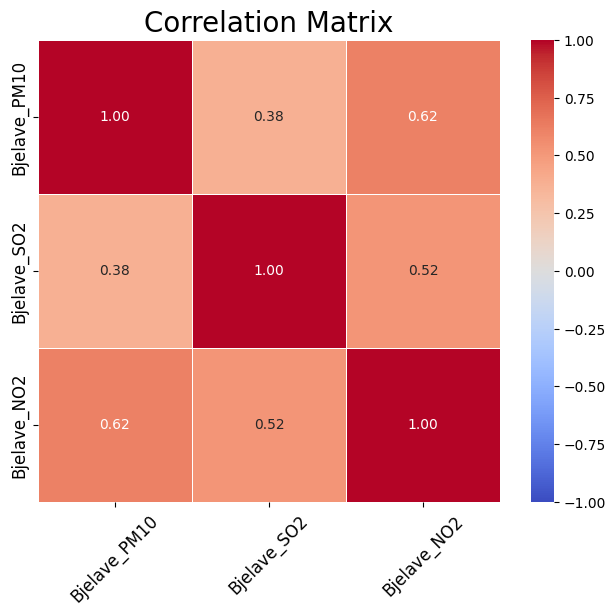

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select columns with index 1 to 13
selected_columns = df_processed_combined_data_daily.iloc[:, 9:]

# Calculate correlation matrix
correlation_matrix = selected_columns.corr()

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, square=True, linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

In [173]:
df_processed_combined_data_daily['Bjelave_PM10'].min()

2.206643477730129

In [174]:
df_processed_combined_data_daily['Bjelave_PM10'].max()

486.23462804158527

# Dataset splitting

In [175]:
def train_test_split(df, date):
    df = df.copy()
    train_data = df[df['DateTime'] < date].copy()
    test_data = df[df['DateTime'] >= date].copy() # df.DateTime = df.DateTime.dt.strftime('%d/%m/%Y %H:%M')
    return train_data, test_data

def train_test_split_from_to(df, start_date, end_date, slice_date):
    df = df.copy()
    train_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < slice_date)].copy()
    test_data = df[(df['DateTime'] >= slice_date) & (df['DateTime'] <= end_date)].copy()
    return train_data, test_data

def plot_train_test_data(train_data, test_data, date_column, label):
    plt.figure(figsize=(20,10))
    plt.plot(train_data[date_column], train_data[label], color='blue', label='Train Data')
    plt.plot(test_data[date_column], test_data[label], color='orange', label='Test Data')
    plt.xlabel(date_column)
    plt.ylabel(label)
    plt.title(label + ' Train and Test Data')
    plt.legend()
    plt.show()

In [176]:
#input window = 30
date = df_aqi_daily['DateTime'].max() - pd.Timedelta(days=30)
train_data_aqi_ws_thirty, test_data_aqi_ws_thirty = train_test_split(df_aqi_daily, date) #

date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=30)
train_data_combined_ws_thirty, test_data_combined_ws_thirty = train_test_split(df_processed_combined_data_daily, date) #

#input window = 60
date = df_aqi_daily['DateTime'].max() - pd.Timedelta(days=60)
train_data_aqi_ws_sixty, test_data_aqi_ws_sixty = train_test_split(df_aqi_daily, date) #

date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=60)
train_data_combined_ws_sixty, test_data_combined_ws_sixty = train_test_split(df_processed_combined_data_daily, date)

#input window = 90
date = df_aqi_daily['DateTime'].max() - pd.Timedelta(days=90)
train_data_aqi_ws_ninety, test_data_aqi_ws_ninety = train_test_split(df_aqi_daily, date) #

date = df_processed_combined_data_daily['DateTime'].max() - pd.Timedelta(days=90)
train_data_combined_ws_ninety, test_data_combined_ws_ninety = train_test_split(df_processed_combined_data_daily, date) #

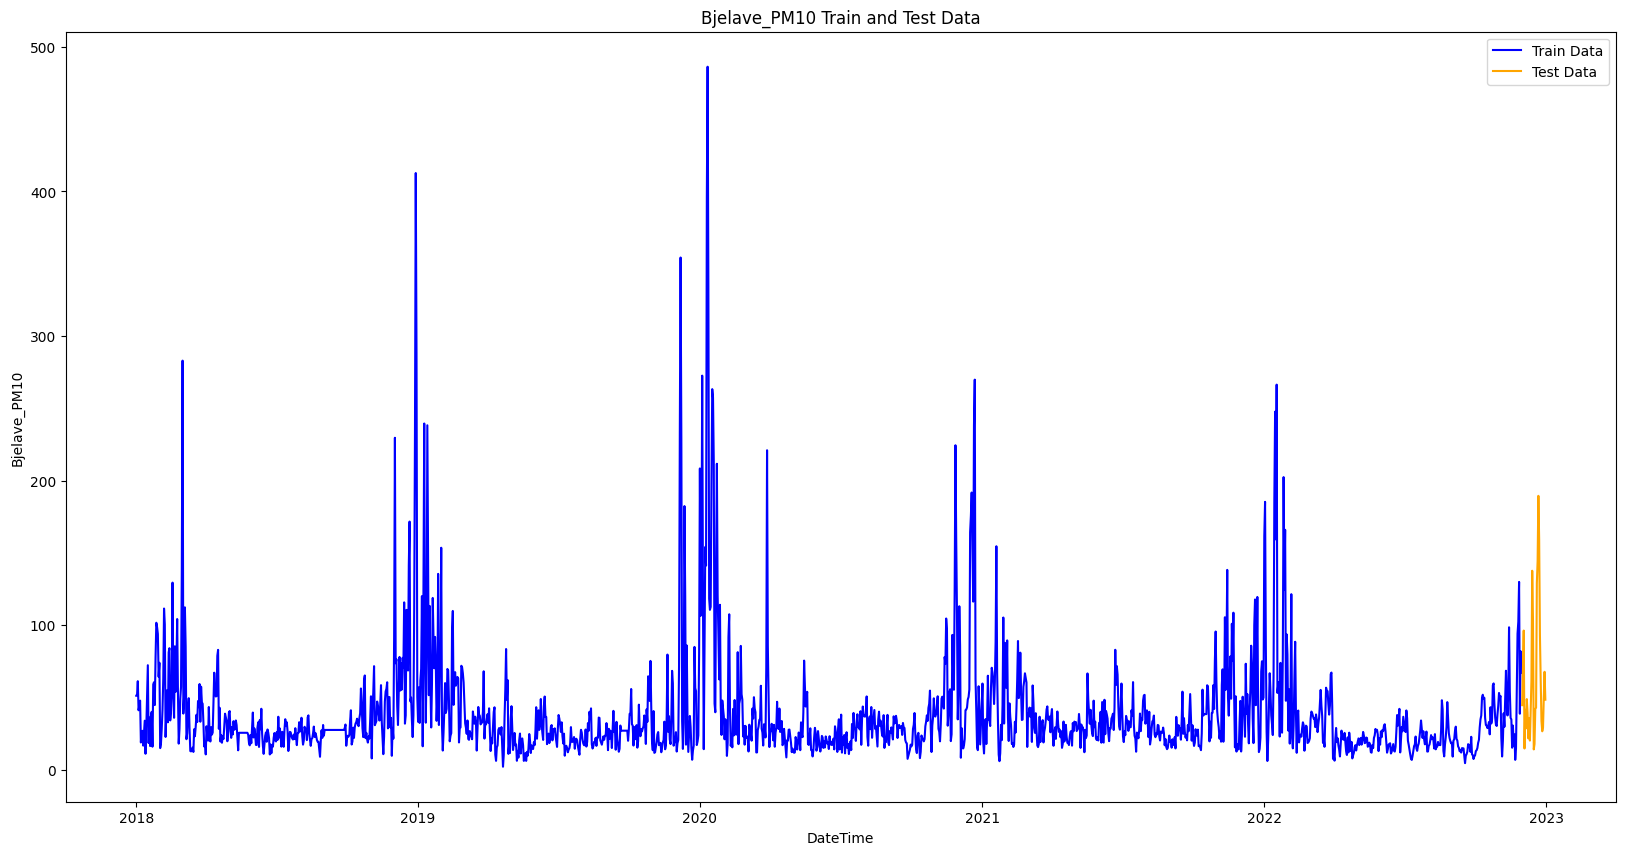

In [178]:
plot_train_test_data(train_data_combined_ws_thirty, test_data_combined_ws_thirty, 'DateTime', 'Bjelave_PM10')
#plot_train_test_data(train_data_combined_ws_sixty, test_data_combined_ws_sixty, 'DateTime', 'Bjelave_PM10')
#plot_train_test_data(train_data_combined_ws_ninety, test_data_combined_ws_ninety, 'DateTime', 'Bjelave_PM10')

In [179]:
train_data_combined_ws_thirty.rename(columns={'DateTime': 'ds', 'Bjelave_PM10': 'y'}, inplace=True)
test_data_combined_ws_thirty.rename(columns={'DateTime': 'ds', 'Bjelave_PM10': 'y'}, inplace=True)

train_data_combined_ws_sixty.rename(columns={'DateTime': 'ds', 'Bjelave_PM10': 'y'}, inplace=True)
test_data_combined_ws_sixty.rename(columns={'DateTime': 'ds', 'Bjelave_PM10': 'y'}, inplace=True)

train_data_combined_ws_ninety.rename(columns={'DateTime': 'ds', 'Bjelave_PM10': 'y'}, inplace=True)
test_data_combined_ws_ninety.rename(columns={'DateTime': 'ds', 'Bjelave_PM10': 'y'}, inplace=True)

# Univariate Time Series Forecasting using FBProphet

In [180]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

def train_prophet(train_data):
    model = Prophet(daily_seasonality=True)
    model.fit(train_data)
    return model

def predict_prophet(model, test_data):
    forecast = model.predict(test_data)
    return forecast

def calculate_metrics(test, forecast, true_label='y', predicted_label='yhat'):
    mae = mean_absolute_error(test[true_label], forecast[predicted_label])
    mse = mean_squared_error(test[true_label], forecast[predicted_label])
    rmse = sqrt(mse)
    r2 = r2_score(test[true_label], forecast[predicted_label])
    return rmse, mae, r2

def plot_boxplot(prediction_data, test_data):
    error = abs(prediction_data - test_data)
    # plot boxplot of error
    plt.figure(figsize=(7,4))
    plt.boxplot(error)
    plt.show()

In [181]:
train_data_aqi_ws_thirty.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)
test_data_aqi_ws_thirty.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)

train_data_aqi_ws_sixty.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)
test_data_aqi_ws_sixty.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)

train_data_aqi_ws_ninety.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)
test_data_aqi_ws_ninety.rename(columns={'DateTime': 'ds', 'AQI': 'y'}, inplace=True)

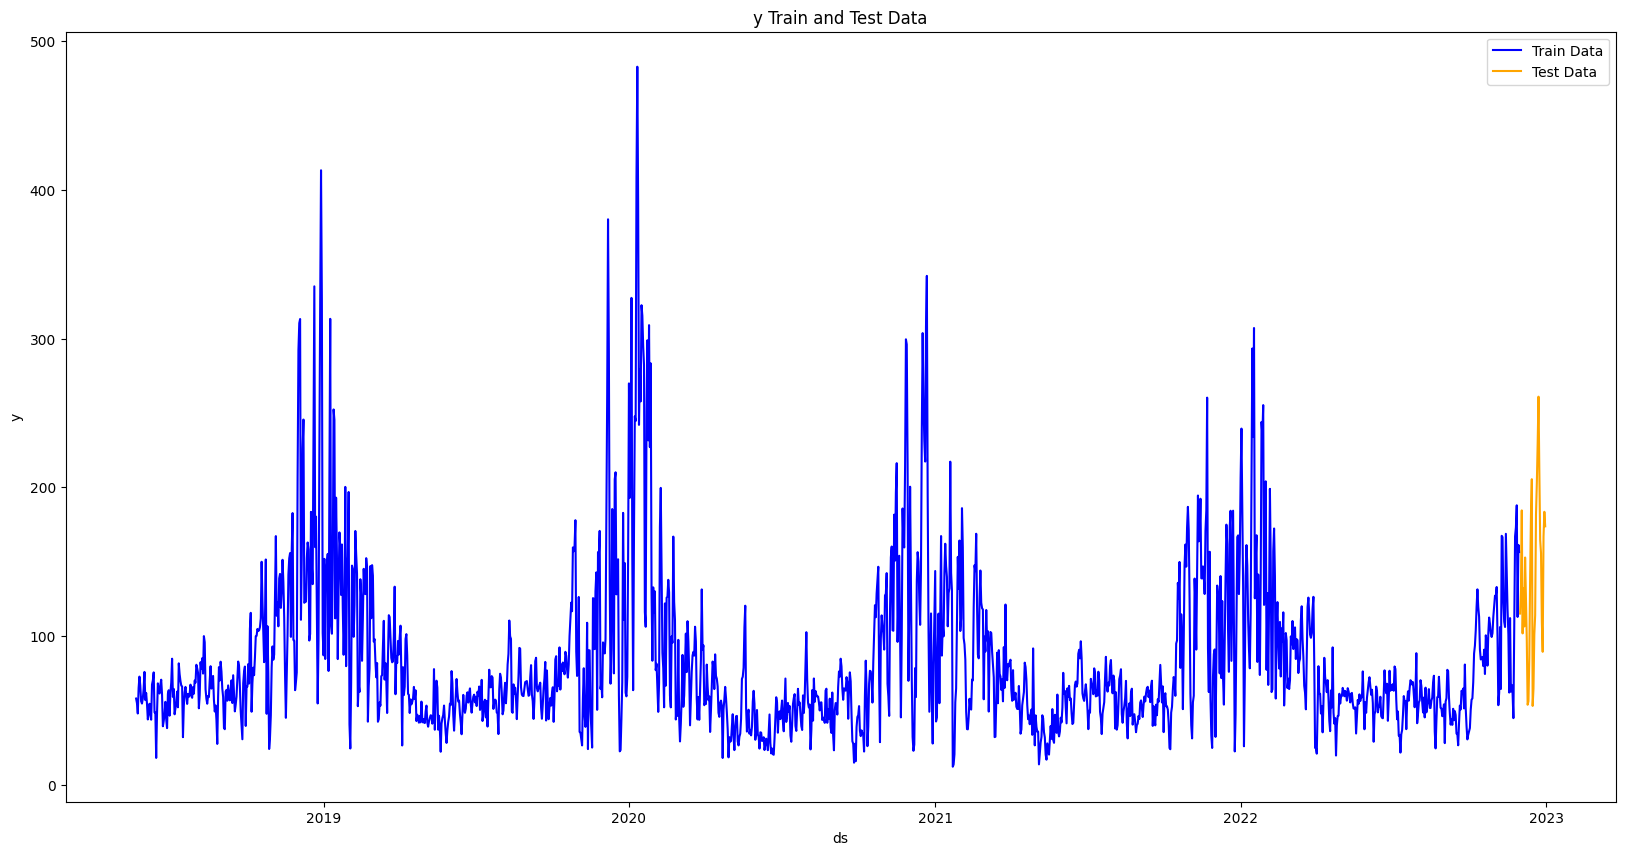

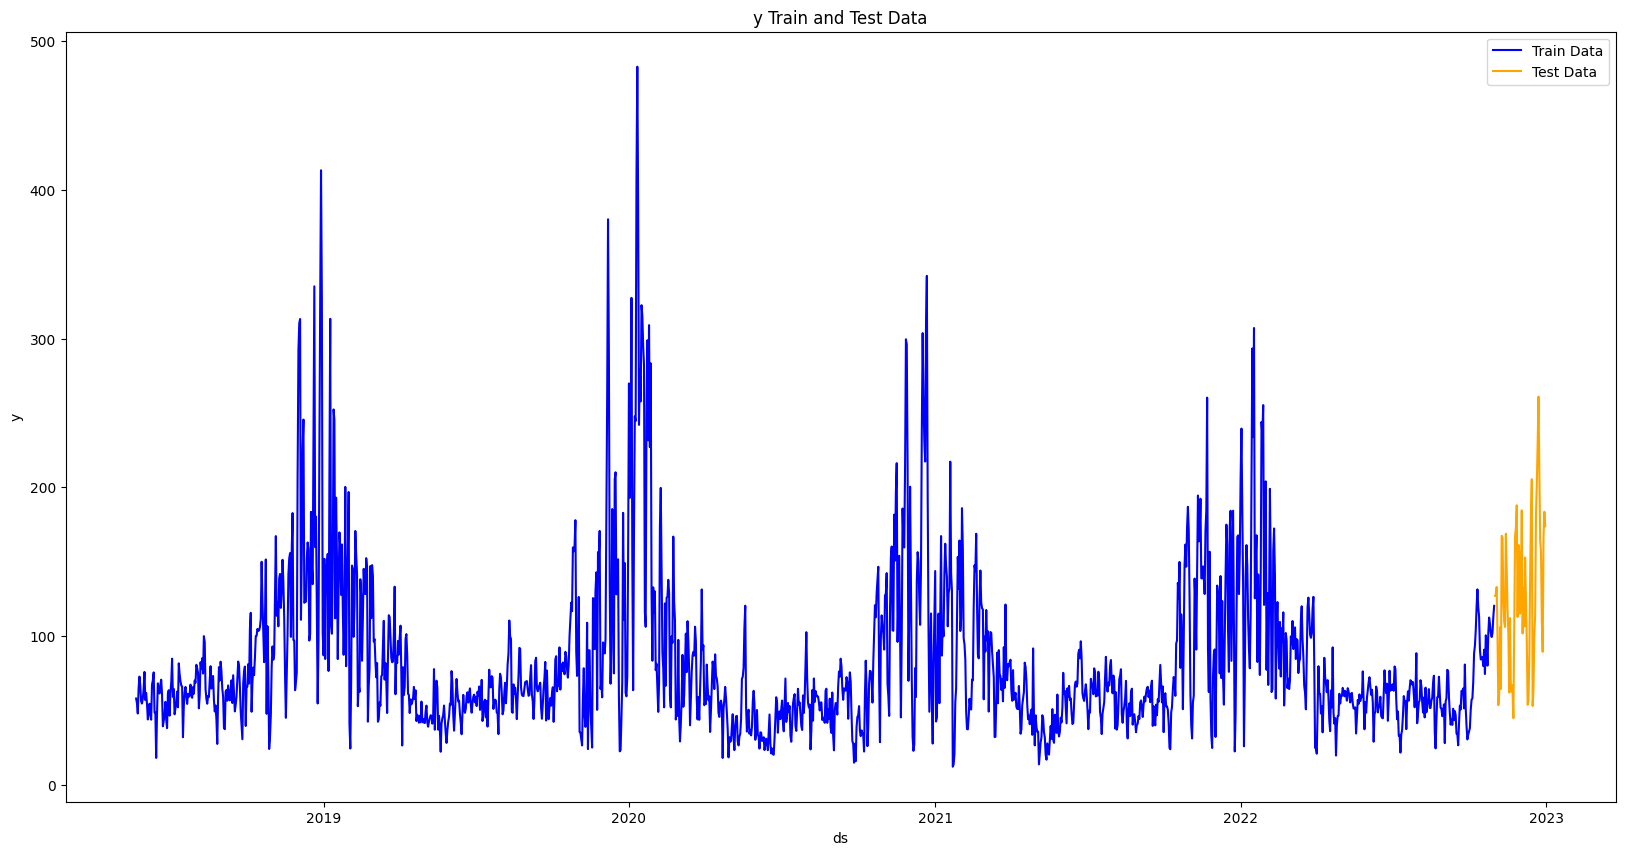

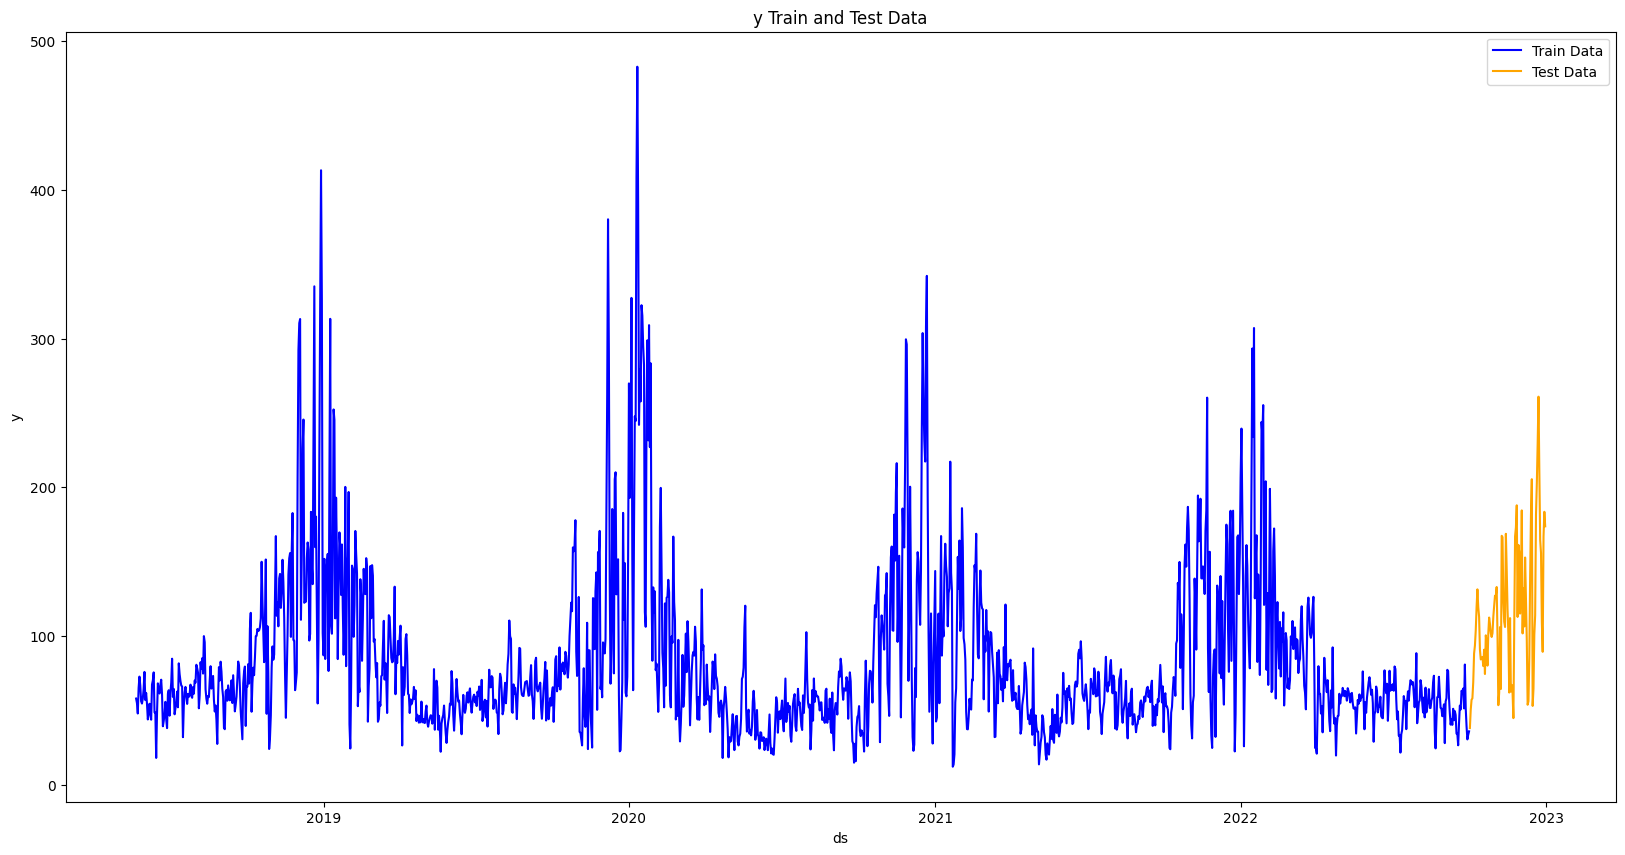

In [182]:
plot_train_test_data(train_data_aqi_ws_thirty, test_data_aqi_ws_thirty, 'ds', 'y')
plot_train_test_data(train_data_aqi_ws_sixty, test_data_aqi_ws_sixty, 'ds', 'y')
plot_train_test_data(train_data_aqi_ws_ninety, test_data_aqi_ws_ninety, 'ds', 'y')

In [183]:
model_aqi_ws_thirty = train_prophet(train_data_aqi_ws_ninety)
forecast_aqi_ws_thirty = predict_prophet(model_aqi_ws_thirty, test_data_aqi_ws_ninety[:30])
rmse, mae, r2 = calculate_metrics(test_data_aqi_ws_ninety[:30], forecast_aqi_ws_thirty)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/8s33xtja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/dtpttbkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62681', 'data', 'file=/tmp/tmp562_wkws/8s33xtja.json', 'init=/tmp/tmp562_wkws/dtpttbkk.json', 'output', 'file=/tmp/tmp562_wkws/prophet_modelgb2zv3fe/prophet_model-20250817175118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 22.763
MAE: 15.146
R2: -0.089


In [184]:
model_aqi_ws_sixty = train_prophet(train_data_aqi_ws_ninety)
forecast_aqi_ws_sixty = predict_prophet(model_aqi_ws_sixty, test_data_aqi_ws_ninety[:60])
rmse, mae, r2 = calculate_metrics(test_data_aqi_ws_ninety[:60], forecast_aqi_ws_sixty)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/ah9qcbrv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/8kxt8kyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19842', 'data', 'file=/tmp/tmp562_wkws/ah9qcbrv.json', 'init=/tmp/tmp562_wkws/8kxt8kyq.json', 'output', 'file=/tmp/tmp562_wkws/prophet_modelccelbi1s/prophet_model-20250817175119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 32.265
MAE: 24.069
R2: 0.140


In [185]:
model_aqi_ws_ninety = train_prophet(train_data_aqi_ws_ninety)
forecast_aqi_ws_ninety = predict_prophet(model_aqi_ws_ninety, test_data_aqi_ws_ninety)
rmse, mae, r2 = calculate_metrics(test_data_aqi_ws_ninety, forecast_aqi_ws_ninety)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/aym4ieys.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/achpstil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13944', 'data', 'file=/tmp/tmp562_wkws/aym4ieys.json', 'init=/tmp/tmp562_wkws/achpstil.json', 'output', 'file=/tmp/tmp562_wkws/prophet_modelp9qz1tpq/prophet_model-20250817175119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 40.857
MAE: 31.266
R2: 0.188


In [186]:
#plot_forecast(test_data_aqi_ws_thirty, forecast_aqi_ws_thirty)
#plot_boxplot(forecast_aqi_ws_thirty['yhat'].values.reshape(-1,1), test_data_aqi_ws_thirty['y'].values.reshape(-1,1))
#plot_forecast(test_data_aqi_ws_thirty, model_aqi_ws_thirty)
#plot_boxplot(model_aqi_ws_thirty['yhat'].values.reshape(-1,1), test_data_aqi_ws_thirty['y'].values.reshape(-1,1))

In [187]:
train_data_aqi_ws_ninety.shape

(1594, 2)

In [188]:
model_aqi = train_prophet(train_data_aqi_ws_ninety)
forecast_aqi_ws_fifteen = predict_prophet(model_aqi, test_data_aqi_ws_ninety[:15])
forecast_aqi_ws_thirty = predict_prophet(model_aqi, test_data_aqi_ws_ninety[:30])
forecast_aqi_ws_fourtyfive = predict_prophet(model_aqi, test_data_aqi_ws_ninety[:45])
forecast_aqi_ws_sixty = predict_prophet(model_aqi, test_data_aqi_ws_ninety[:60])
forecast_aqi_ws_ninety = predict_prophet(model_aqi, test_data_aqi_ws_ninety)

rmse_fifteen, mae_fifteen, r2_fifteen = calculate_metrics(test_data_aqi_ws_ninety[:15], forecast_aqi_ws_fifteen)
rmse_thirty, mae_thirty, r2_thirty = calculate_metrics(test_data_aqi_ws_ninety[:30], forecast_aqi_ws_thirty)
rmse_fourtyfive, mae_fourtyfive, r2_fourtyfive = calculate_metrics(test_data_aqi_ws_ninety[:45], forecast_aqi_ws_fourtyfive)
rmse_sixty, mae_sixty, r2_sixty = calculate_metrics(test_data_aqi_ws_ninety[:60], forecast_aqi_ws_sixty)
rmse_ninety, mae_ninety, r2_ninety = calculate_metrics(test_data_aqi_ws_ninety, forecast_aqi_ws_ninety)

print("prediction window size: fifteen days")
print(' RMSE: %.3f' % rmse_fifteen)
print(' MAE: %.3f' % mae_fifteen)
print(' R2: %.3f' % r2_fifteen)

print("prediction window size: thirty days")
print(' RMSE: %.3f' % rmse_thirty)
print(' MAE: %.3f' % mae_thirty)
print(' R2: %.3f' % r2_thirty)

print("prediction window size: fourtyfive days")
print(' RMSE: %.3f' % rmse_fourtyfive)
print(' MAE: %.3f' % mae_fourtyfive)
print(' R2: %.3f' % r2_fourtyfive)

print("prediction window size: sixty days")
print(' RMSE: %.3f' % rmse_sixty)
print(' MAE: %.3f' % mae_sixty)
print(' R2: %.3f' % r2_sixty)

print("prediction window size: ninety days")
print(' RMSE: %.3f' % rmse_ninety)
print(' MAE: %.3f' % mae_ninety)
print(' R2: %.3f' % r2_ninety)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/4mcmpq1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/khyr1ltk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62623', 'data', 'file=/tmp/tmp562_wkws/4mcmpq1b.json', 'init=/tmp/tmp562_wkws/khyr1ltk.json', 'output', 'file=/tmp/tmp562_wkws/prophet_modeljtu1tr7i/prophet_model-20250817175119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:51:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


prediction window size: fifteen days
 RMSE: 30.567
 MAE: 22.516
 R2: -0.288
prediction window size: thirty days
 RMSE: 22.763
 MAE: 15.146
 R2: -0.089
prediction window size: fourtyfive days
 RMSE: 28.436
 MAE: 20.169
 R2: 0.087
prediction window size: sixty days
 RMSE: 32.265
 MAE: 24.069
 R2: 0.140
prediction window size: ninety days
 RMSE: 40.857
 MAE: 31.266
 R2: 0.188


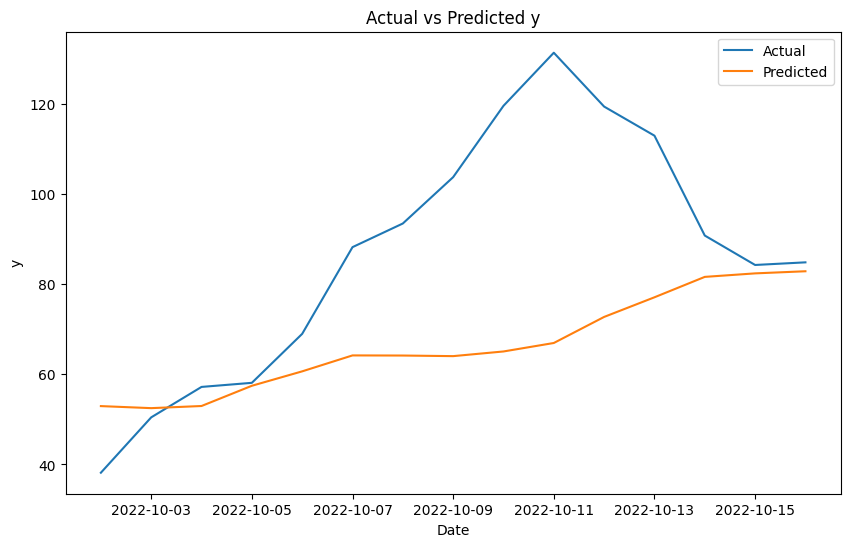

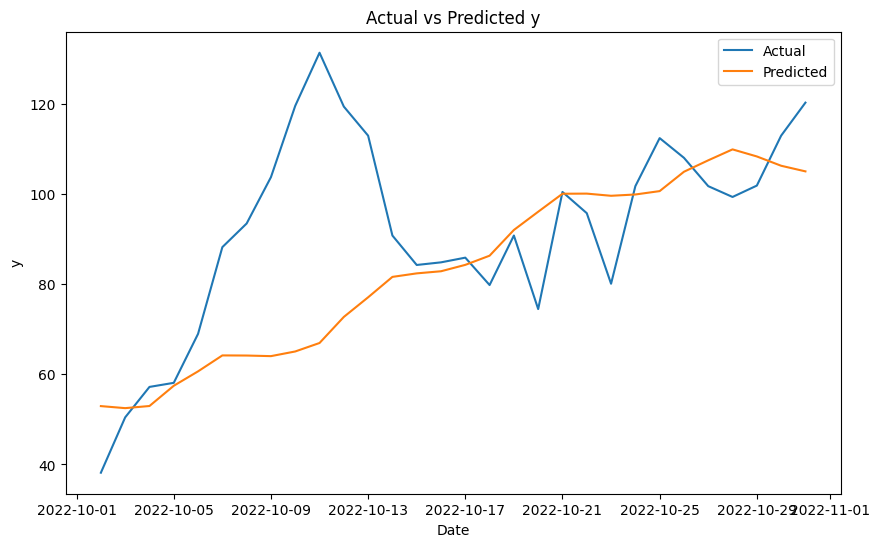

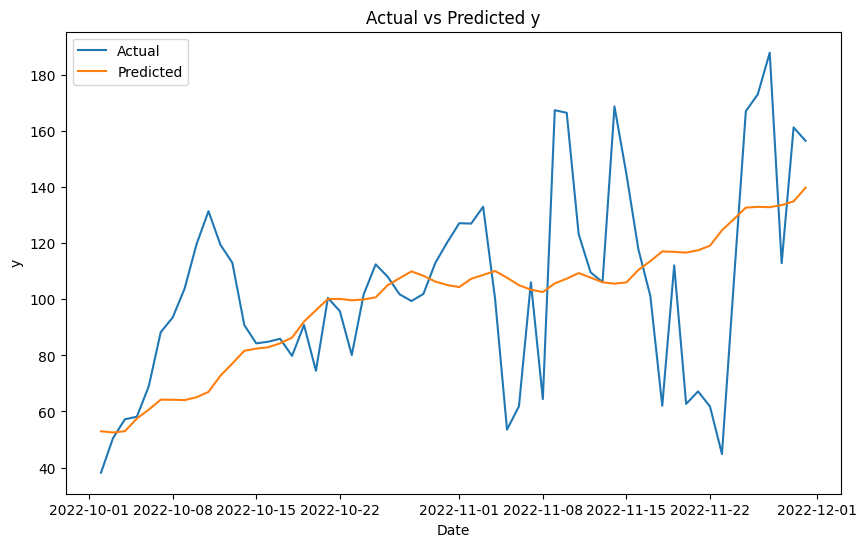

In [189]:
plot_forecast(test_data_aqi_ws_ninety[:15], forecast_aqi_ws_fifteen)
plot_forecast(test_data_aqi_ws_ninety[:30], forecast_aqi_ws_thirty) #forecast_aqi_ws_fifteen
plot_forecast(test_data_aqi_ws_ninety[:60], forecast_aqi_ws_sixty)


In [190]:
# Visualizing the components of the forecast, such as the trend, yearly seasonality, and weekly seasonality. This can be done using the 'plot_components' method of the Prophet model
#model_aqi_ws_thirty.plot_components(forecast_aqi_ws_thirty)
#plt.show()

In [191]:
#print(forecast_aqi_ws_thirty[['ds', 'yhat', 'trend', 'yearly', 'weekly']].head(2))

In [192]:
#model_aqi_ws_sixty.plot_components(forecast_aqi_ws_sixty)
#plt.show()

In [193]:
#plot_forecast(test_data_aqi_ws_ninety, forecast_aqi_ws_ninety)
#plot_boxplot(forecast_aqi_ws_ninety['yhat'].values.reshape(-1,1), test_data_aqi_ws_ninety['y'].values.reshape(-1,1))

In [194]:
#model_aqi_ws_ninety.plot_components(forecast_aqi_ws_ninety)
#plt.show()

# Multivariate Time Series Forecasting using FBProphet

In [227]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [228]:
def train_prophet_multivariate(train_data):
    model = Prophet(daily_seasonality=True)
    #added
    model.add_regressor('wind_speed')
    model.add_regressor('wind_direction')
    model.add_regressor('precipitation')
    model.add_regressor('pressure')
    model.add_regressor('temperature')
    model.add_regressor('humidity')
    model.add_regressor('visibility')
    model.add_regressor('cloudiness') #model.add_regressor('Bjelave_PM10')
    model.add_regressor('Bjelave_SO2')
    model.add_regressor('Bjelave_NO2')
    #added
    model.fit(train_data)
    return model

In [229]:
model_combined_ws_thirty = train_prophet_multivariate(train_data_combined_ws_thirty)
forecast_combined_ws_thirty = predict_prophet(model_combined_ws_thirty, test_data_combined_ws_thirty)
rmse, mae, r2 = calculate_metrics(test_data_combined_ws_thirty, forecast_combined_ws_thirty)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/c4pa31i2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/zbg1p23r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57587', 'data', 'file=/tmp/tmp562_wkws/c4pa31i2.json', 'init=/tmp/tmp562_wkws/zbg1p23r.json', 'output', 'file=/tmp/tmp562_wkws/prophet_modelx7yp8scq/prophet_model-20250817175159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 27.373
MAE: 23.874
R2: 0.639


In [230]:
print("forecast_combined_ws_thirty[yhat].max(): ", forecast_combined_ws_thirty["yhat"].max())
print("test_data_combined_ws_thirty[y].max(): ", test_data_combined_ws_thirty["y"].max())

print("forecast_combined_ws_thirty[yhat].min(): ", forecast_combined_ws_thirty["yhat"].min())
print("test_data_combined_ws_thirty[y].min(): ", test_data_combined_ws_thirty["y"].min())

forecast_combined_ws_thirty[yhat].max():  173.89318836464128
test_data_combined_ws_thirty[y].max():  189.5142091115316
forecast_combined_ws_thirty[yhat].min():  18.612217943256923
test_data_combined_ws_thirty[y].min():  14.177489851911863


(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'center': 'Predicted Distribution/Classification of PM10 over thirty days'}, xlabel='Date', ylabel='PM10 Concentration (μg/m³)'>)

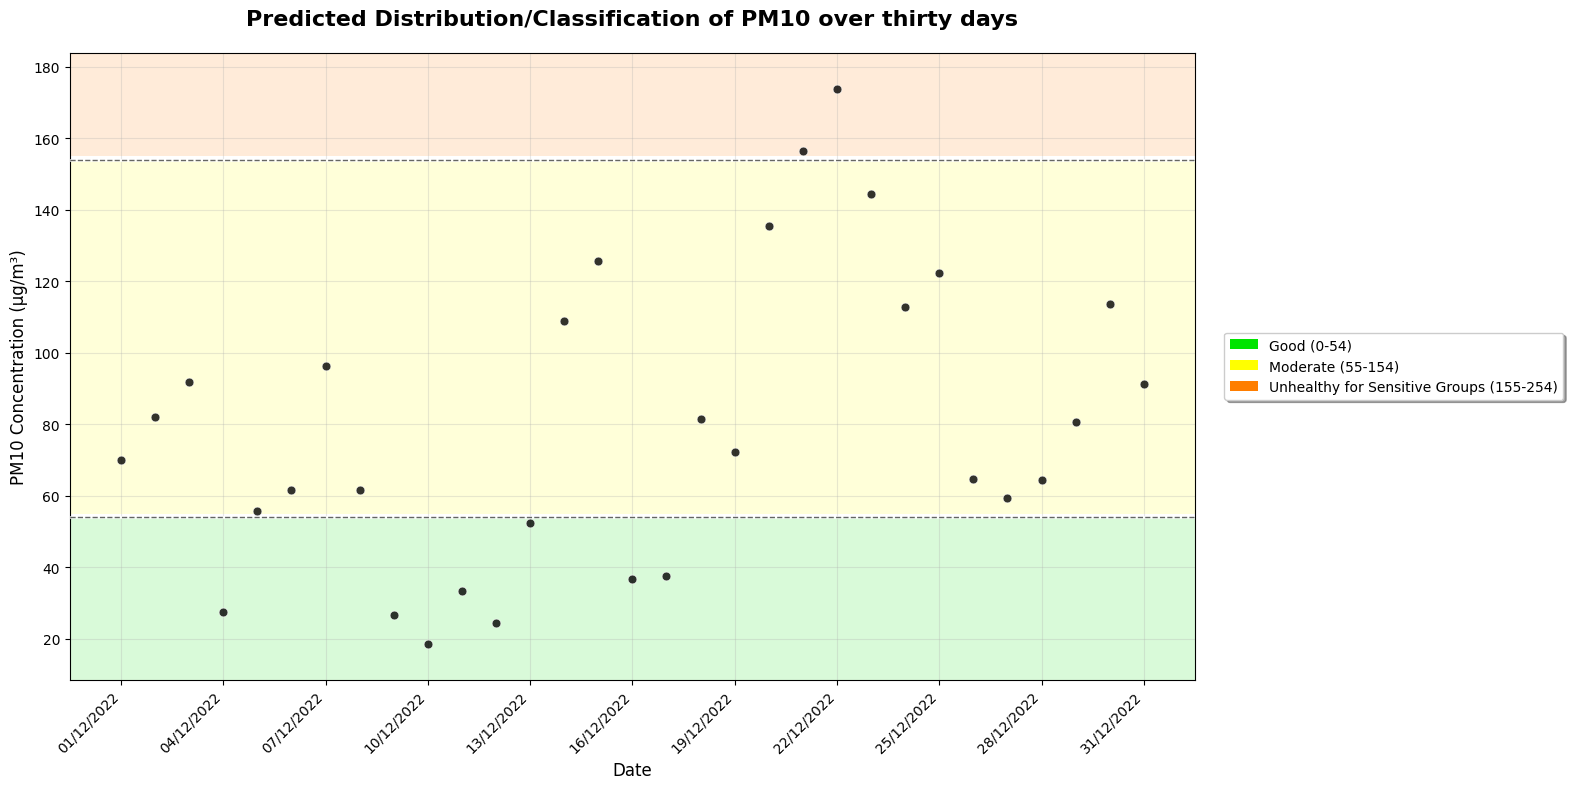

In [231]:
create_pm10_scatter_plot(forecast_combined_ws_thirty, date_column="ds", value_column="yhat", title="Predicted Distribution/Classification of PM10 over thirty days")


(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'center': 'Actual Distribution/Classification of PM10 over thirty days'}, xlabel='Date', ylabel='PM10 Concentration (μg/m³)'>)

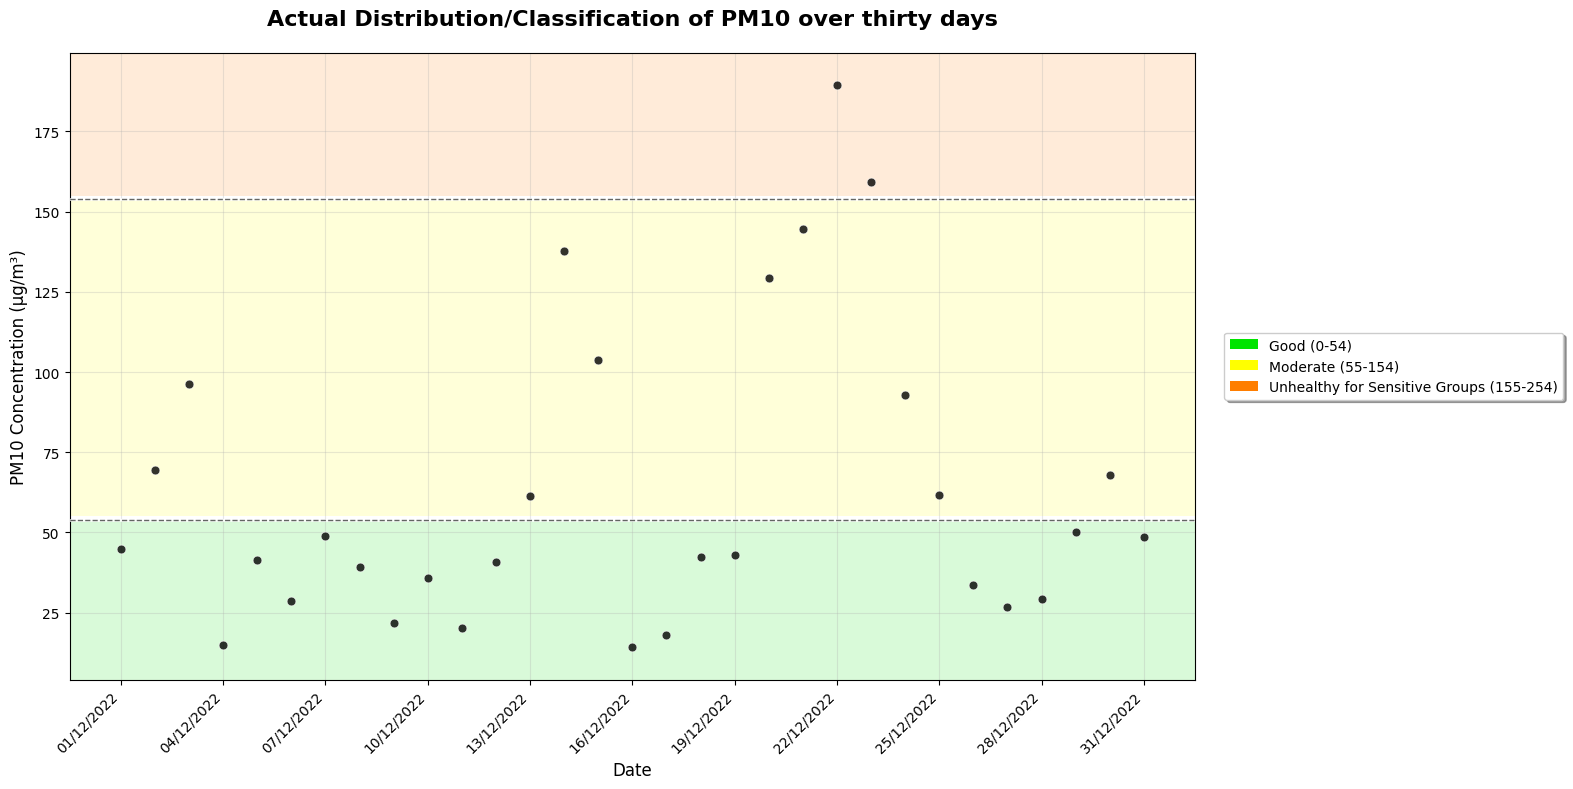

In [232]:
create_pm10_scatter_plot(test_data_combined_ws_thirty, date_column="ds", value_column="y",title="Actual Distribution/Classification of PM10 over thirty days")


In [233]:
forecast_combined_ws_thirty.shape

(31, 55)

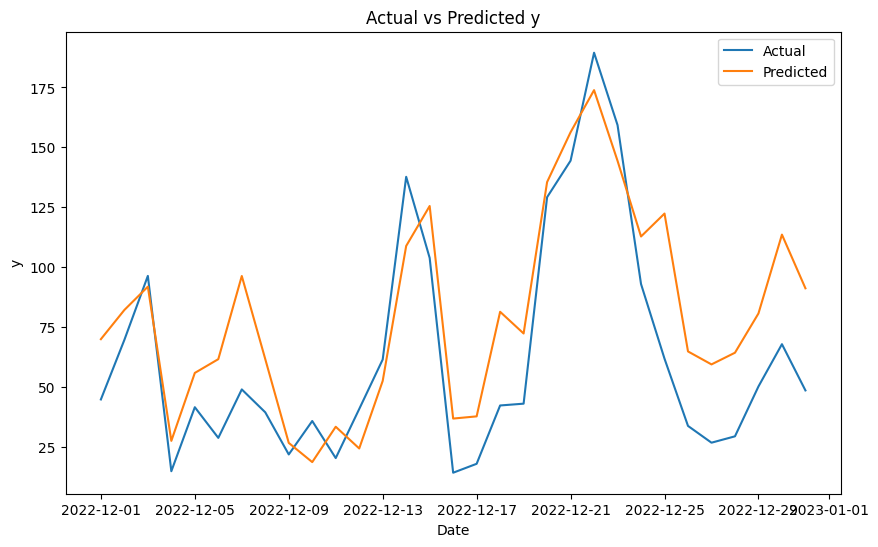

In [234]:
#plot_forecast(test_data_combined_ws_thirty, forecast_combined_ws_thirty, "DateTime", "Bjelave_PM10")
plot_forecast(test_data_combined_ws_thirty, forecast_combined_ws_thirty)

#plot_boxplot(forecast_combined_ws_thirty['yhat'].values.reshape(-1,1), test_data_combined_ws_thirty['y'].values.reshape(-1,1))

In [235]:
model_combined_ws_sixty = train_prophet_multivariate(train_data_combined_ws_sixty)
forecast_combined_ws_sixty = predict_prophet(model_combined_ws_sixty, test_data_combined_ws_sixty)
rmse, mae, r2 = calculate_metrics(test_data_combined_ws_sixty, forecast_combined_ws_sixty)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/_pp1es5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/ujvafgw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23947', 'data', 'file=/tmp/tmp562_wkws/_pp1es5e.json', 'init=/tmp/tmp562_wkws/ujvafgw7.json', 'output', 'file=/tmp/tmp562_wkws/prophet_model2lo_3wws/prophet_model-20250817175201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 23.121
MAE: 19.263
R2: 0.653


In [236]:
print("forecast_combined_ws_sixty[yhat].max(): ", forecast_combined_ws_sixty["yhat"].max())
print("test_data_combined_ws_sixty[y].max(): ", test_data_combined_ws_sixty["y"].max())

print("forecast_combined_ws_sixty[yhat].min(): ", forecast_combined_ws_sixty["yhat"].min())
print("test_data_combined_ws_sixty[y].min(): ", test_data_combined_ws_sixty["y"].min())

forecast_combined_ws_sixty[yhat].max():  173.31467449162204
test_data_combined_ws_sixty[y].max():  189.5142091115316
forecast_combined_ws_sixty[yhat].min():  -7.646125238400579
test_data_combined_ws_sixty[y].min():  6.960133294264476


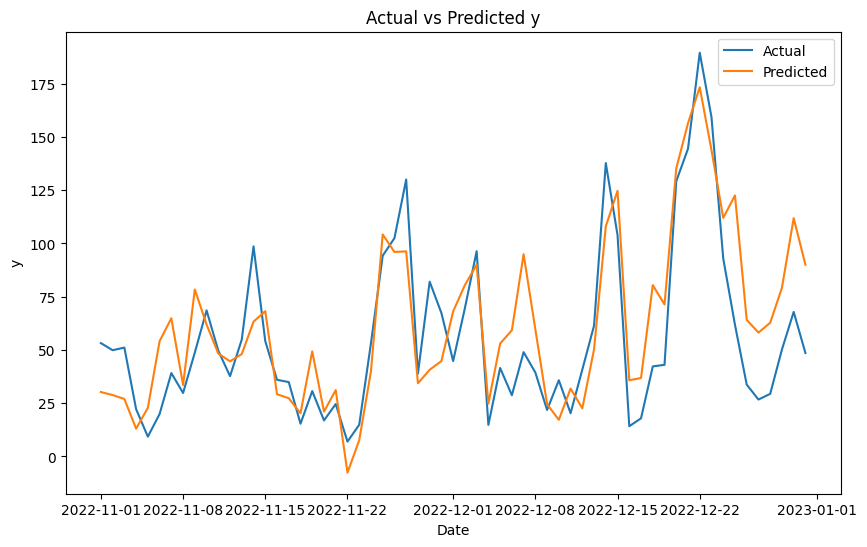

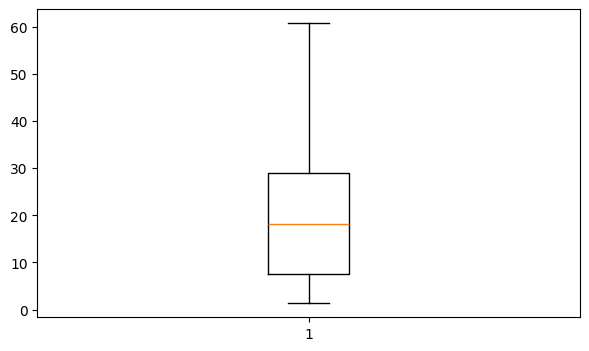

In [237]:
plot_forecast(test_data_combined_ws_sixty, forecast_combined_ws_sixty)
plot_boxplot(forecast_combined_ws_sixty['yhat'].values.reshape(-1,1), test_data_combined_ws_sixty['y'].values.reshape(-1,1))

(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'center': 'Actual Distribution/Classification of PM10 over sixty days'}, xlabel='Date', ylabel='PM10 Concentration (μg/m³)'>)

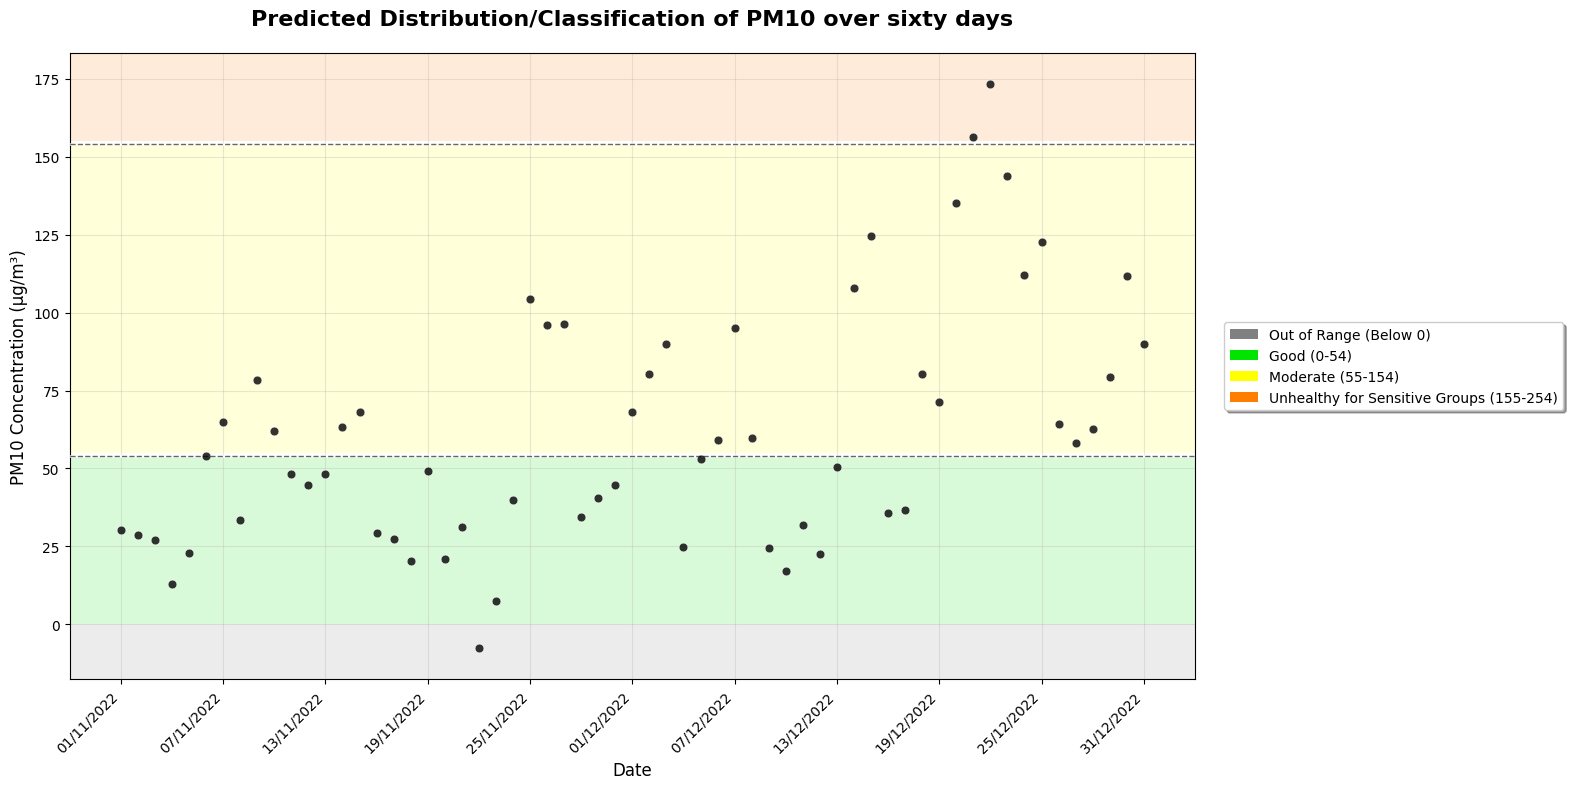

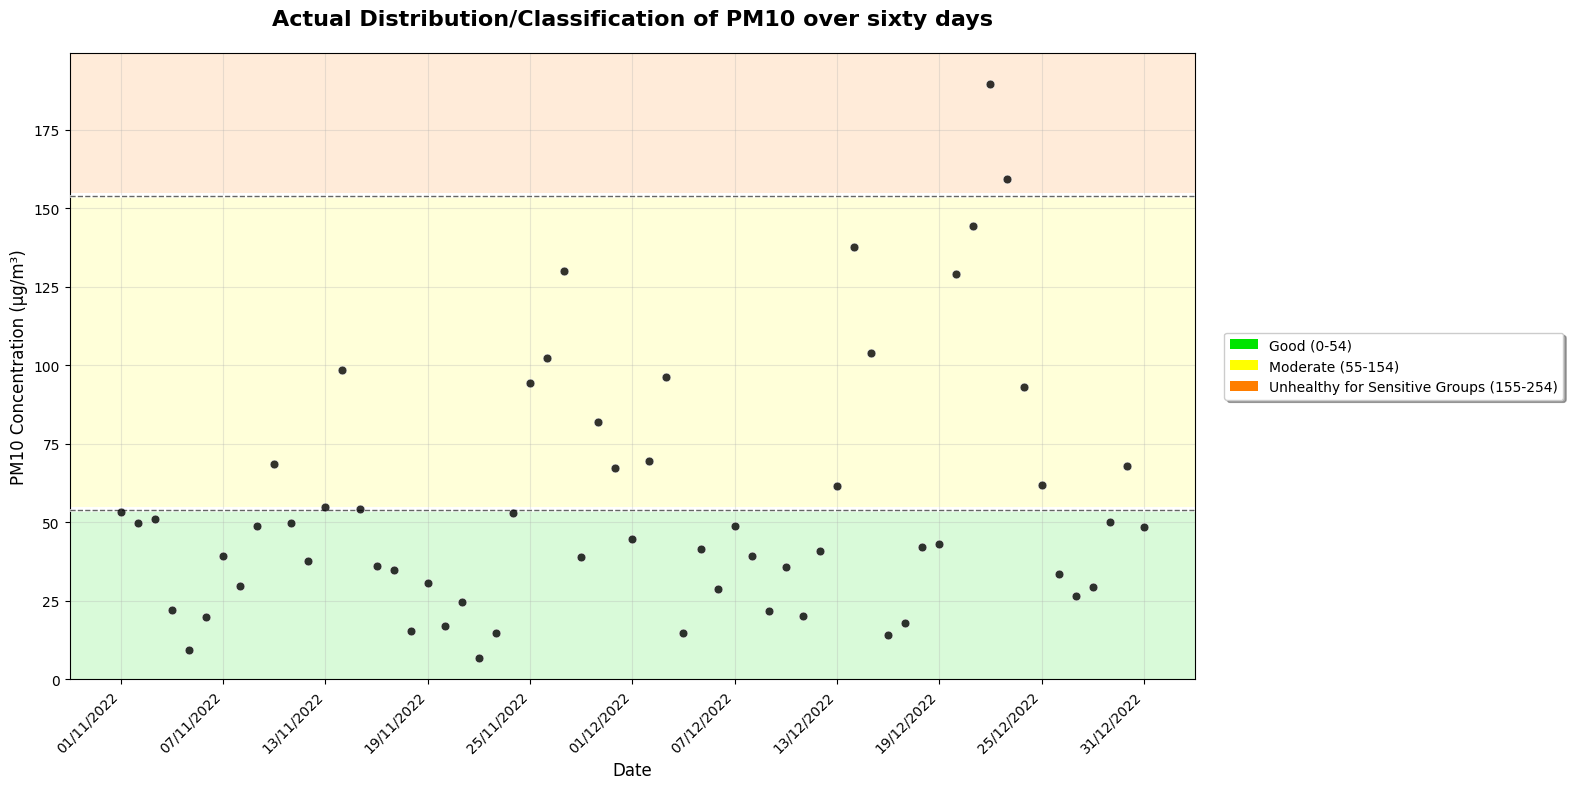

In [238]:
create_pm10_scatter_plot(forecast_combined_ws_sixty, date_column="ds", value_column="yhat", title="Predicted Distribution/Classification of PM10 over sixty days")
create_pm10_scatter_plot(test_data_combined_ws_sixty, date_column="ds", value_column="y", title="Actual Distribution/Classification of PM10 over sixty days")

In [239]:
model_combined_ws_ninety = train_prophet_multivariate(train_data_combined_ws_ninety)
forecast_combined_ws_ninety = predict_prophet(model_combined_ws_ninety, test_data_combined_ws_ninety)
rmse, mae, r2 = calculate_metrics(test_data_combined_ws_ninety, forecast_combined_ws_ninety)

print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/nl2k6v4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/5_m1um_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17365', 'data', 'file=/tmp/tmp562_wkws/nl2k6v4k.json', 'init=/tmp/tmp562_wkws/5_m1um_1.json', 'output', 'file=/tmp/tmp562_wkws/prophet_modely07b35ev/prophet_model-20250817175203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 19.712
MAE: 15.695
R2: 0.669


In [240]:
print("forecast_combined_ws_ninety[yhat].max(): ", forecast_combined_ws_ninety["yhat"].max())
print("test_data_combined_ws_ninety[y].max(): ", test_data_combined_ws_ninety["y"].max())

print("forecast_combined_ws_ninety[yhat].min(): ", forecast_combined_ws_ninety["yhat"].min())
print("test_data_combined_ws_ninety[y].min(): ", test_data_combined_ws_ninety["y"].min())

forecast_combined_ws_ninety[yhat].max():  172.19059432480913
test_data_combined_ws_ninety[y].max():  189.5142091115316
forecast_combined_ws_ninety[yhat].min():  -8.62879392080297
test_data_combined_ws_ninety[y].min():  6.960133294264476


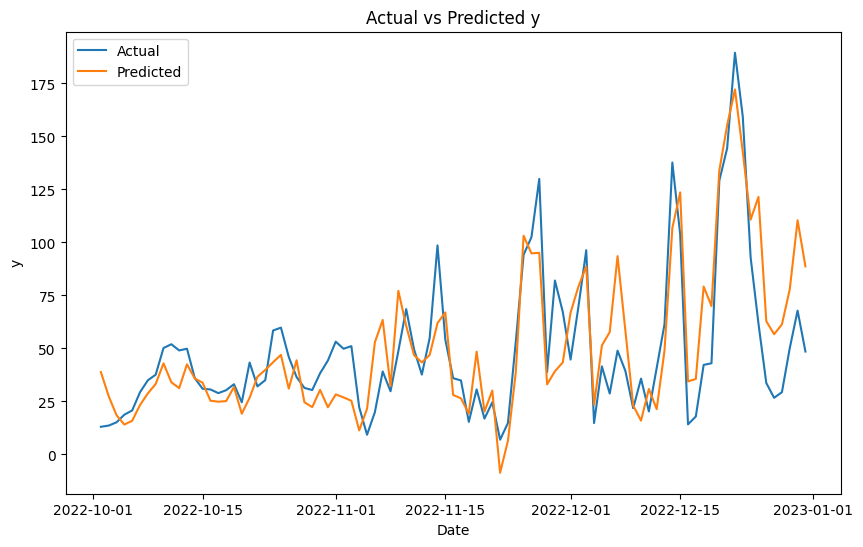

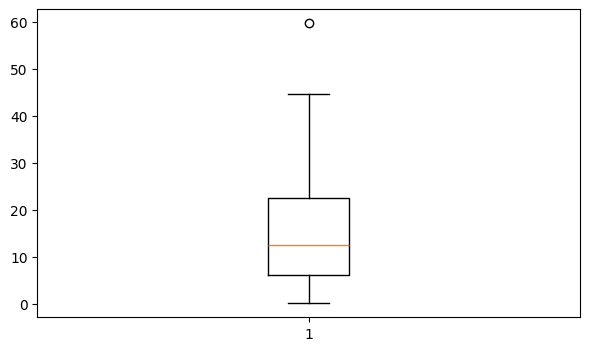

In [241]:
plot_forecast(test_data_combined_ws_ninety, forecast_combined_ws_ninety)
plot_boxplot(forecast_combined_ws_ninety['yhat'].values.reshape(-1,1), test_data_combined_ws_ninety['y'].values.reshape(-1,1))


(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'center': 'Actual Distribution/Classification of PM10 over ninety days'}, xlabel='Date', ylabel='PM10 Concentration (μg/m³)'>)

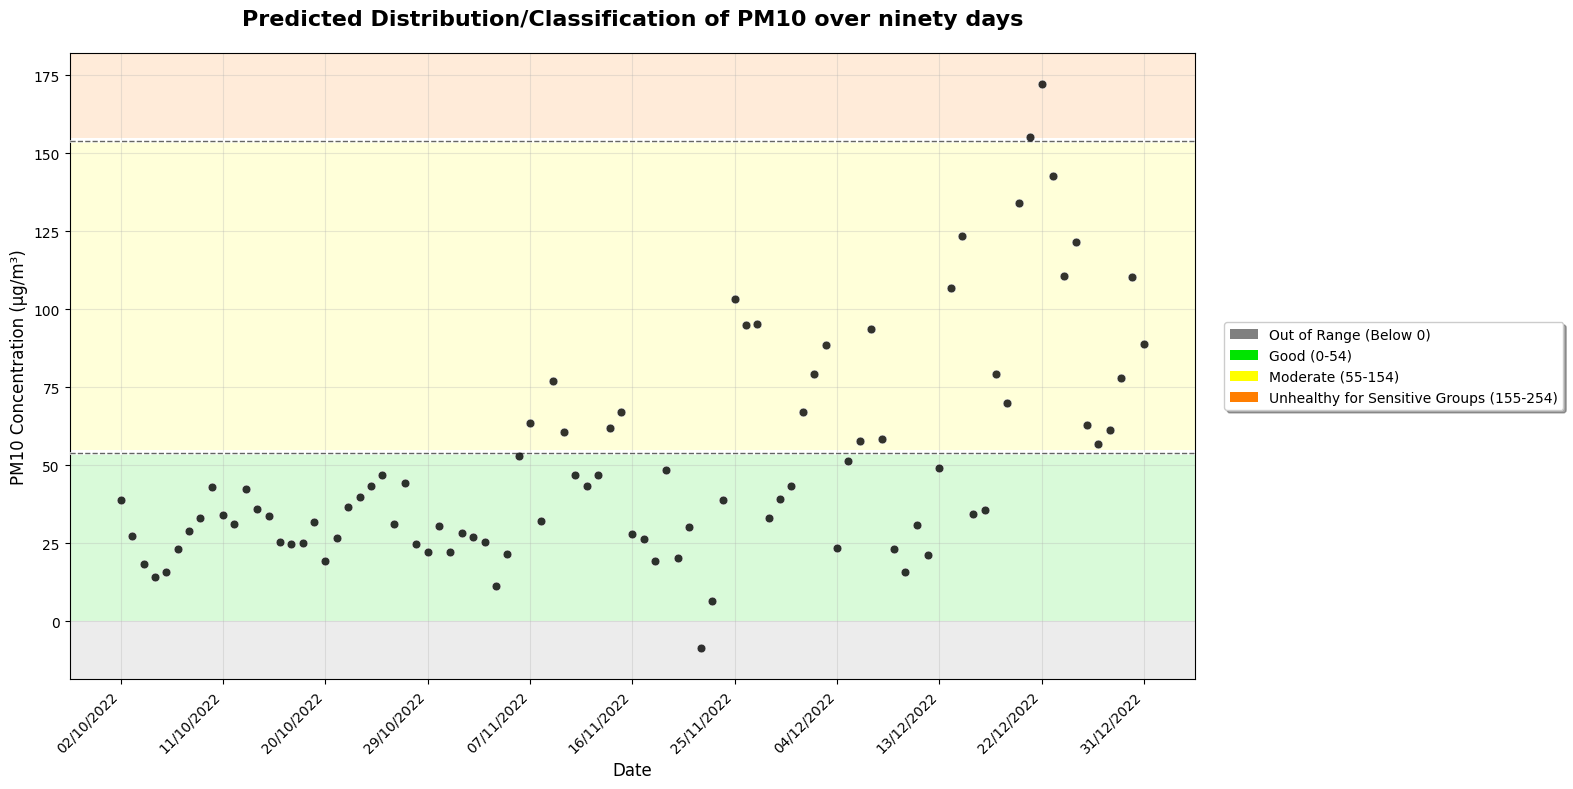

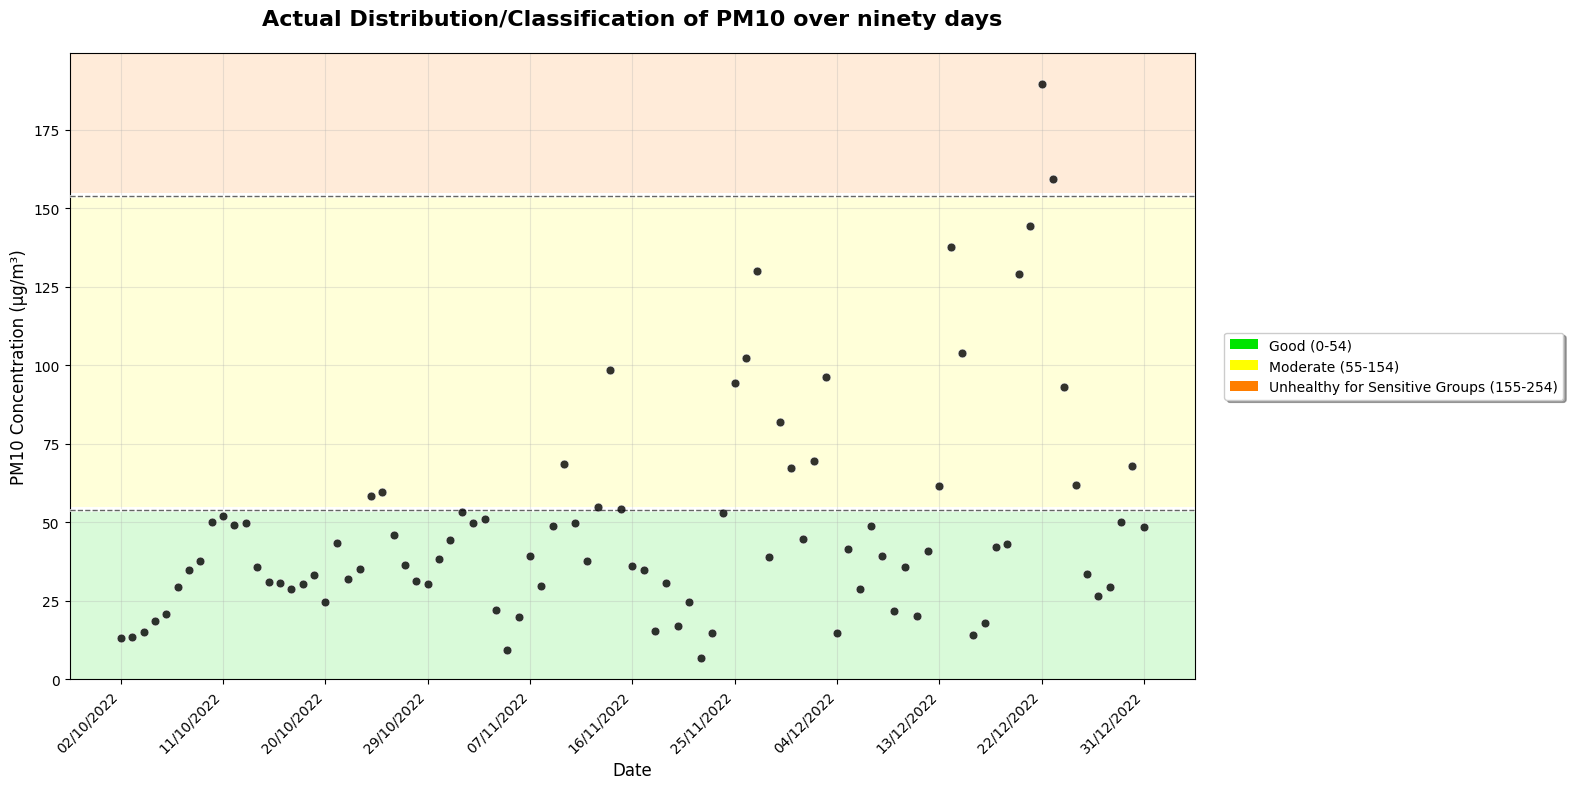

In [242]:
create_pm10_scatter_plot(forecast_combined_ws_ninety, date_column="ds", value_column="yhat", title="Predicted Distribution/Classification of PM10 over ninety days")
create_pm10_scatter_plot(test_data_combined_ws_ninety, date_column="ds", value_column="y", title="Actual Distribution/Classification of PM10 over ninety days")

In [243]:
def plot_forecast_mod(test, forecast, date_col='ds', true_label='y', predicted_label='yhat', title_label='y'):
    plt.figure(figsize=(10, 6))
    plt.plot(test[date_col], test[true_label], label='Actual')
    plt.plot(test[date_col], forecast[predicted_label], label='Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(true_label)
    plt.title('Actual vs Predicted ' + title_label)
    plt.show()

In [244]:
#same model
model_combined = train_prophet_multivariate(train_data_combined_ws_thirty)
forecast_mt_combined_ws_five = predict_prophet(model_combined, test_data_combined_ws_thirty[-5:])
forecast_mt_combined_ws_fifteen = predict_prophet(model_combined, test_data_combined_ws_thirty[-15:])
forecast_mt_combined_ws_thirty = predict_prophet(model_combined, test_data_combined_ws_thirty)

rmse_five, mae_five, r2_five = calculate_metrics(test_data_combined_ws_thirty[-5:], forecast_mt_combined_ws_five)
rmse_fifteen, mae_fifteen, r2_fifteen = calculate_metrics(test_data_combined_ws_thirty[-15:], forecast_mt_combined_ws_fifteen)
rmse_thirty, mae_thirty, r2_thirty = calculate_metrics(test_data_combined_ws_thirty, forecast_mt_combined_ws_thirty)

print("\ntrain_data_combined_ws_thirty, test_data_combined_ws_thirty")
print("prediction window size: five days")
print(' RMSE: %.3f' % rmse_five)
print(' MAE: %.3f' % mae_five)
print(' R2: %.3f' % r2_five)

print("\nprediction window size: fifteen days")
print(' RMSE: %.3f' % rmse_fifteen)
print(' MAE: %.3f' % mae_fifteen)
print(' R2: %.3f' % r2_fifteen)

print("\nprediction window size: thirty days")
print(' RMSE: %.3f' % rmse_thirty)
print(' MAE: %.3f' % mae_thirty)
print(' R2: %.3f' % r2_thirty)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/1ihi3n6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/zp_7obvu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96622', 'data', 'file=/tmp/tmp562_wkws/1ihi3n6t.json', 'init=/tmp/tmp562_wkws/zp_7obvu.json', 'output', 'file=/tmp/tmp562_wkws/prophet_modelucdc3d_o/prophet_model-20250817175204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



train_data_combined_ws_thirty, test_data_combined_ws_thirty
prediction window size: five days
 RMSE: 37.749
 MAE: 37.287
 R2: -5.257

prediction window size: fifteen days
 RMSE: 32.233
 MAE: 28.994
 R2: 0.623

prediction window size: thirty days
 RMSE: 27.373
 MAE: 23.874
 R2: 0.639


In [245]:
#same model
model_combined = train_prophet_multivariate(train_data_combined_ws_sixty)
forecast_ms_combined_ws_five = predict_prophet(model_combined, test_data_combined_ws_sixty[-5:])
forecast_ms_combined_ws_fifteen = predict_prophet(model_combined, test_data_combined_ws_sixty[-15:])
forecast_ms_combined_ws_thirty = predict_prophet(model_combined, test_data_combined_ws_sixty[-30:])
forecast_ms_combined_ws_fourtyfive = predict_prophet(model_combined, test_data_combined_ws_sixty[-45:])
forecast_ms_combined_ws_sixty = predict_prophet(model_combined, test_data_combined_ws_sixty)

rmse_five, mae_five, r2_five = calculate_metrics(test_data_combined_ws_sixty[-5:], forecast_ms_combined_ws_five)
rmse_fifteen, mae_fifteen, r2_fifteen = calculate_metrics(test_data_combined_ws_sixty[-15:], forecast_ms_combined_ws_fifteen)
rmse_thirty, mae_thirty, r2_thirty = calculate_metrics(test_data_combined_ws_sixty[-30:], forecast_ms_combined_ws_thirty)
rmse_fourtyfive, mae_fourtyfive, r2_fourtyfive = calculate_metrics(test_data_combined_ws_sixty[-45:], forecast_ms_combined_ws_fourtyfive)
rmse_sixty, mae_sixty, r2_sixty = calculate_metrics(test_data_combined_ws_sixty, forecast_ms_combined_ws_sixty)

print("\ntrain_data_combined_ws_sixty, test_data_combined_ws_sixty")

print("\nprediction window size: five days")
print(' RMSE: %.3f' % rmse_five)
print(' MAE: %.3f' % mae_five)
print(' R2: %.3f' % r2_five)

print("\nprediction window size: fifteen days")
print(' RMSE: %.3f' % rmse_fifteen)
print(' MAE: %.3f' % mae_fifteen)
print(' R2: %.3f' % r2_fifteen)

print("\nprediction window size: thirty days")
print(' RMSE: %.3f' % rmse_thirty)
print(' MAE: %.3f' % mae_thirty)
print(' R2: %.3f' % r2_thirty)

print("\nprediction window size: fourtyfive days")
print(' RMSE: %.3f' % rmse_fourtyfive)
print(' MAE: %.3f' % mae_fourtyfive)
print(' R2: %.3f' % r2_fourtyfive)

print("\nprediction window size: sixty days")
print(' RMSE: %.3f' % rmse_sixty)
print(' MAE: %.3f' % mae_sixty)
print(' R2: %.3f' % r2_sixty)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/s48zy_9x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/b51xbsbt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15393', 'data', 'file=/tmp/tmp562_wkws/s48zy_9x.json', 'init=/tmp/tmp562_wkws/b51xbsbt.json', 'output', 'file=/tmp/tmp562_wkws/prophet_modeleg27pcb4/prophet_model-20250817175205.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



train_data_combined_ws_sixty, test_data_combined_ws_sixty

prediction window size: five days
 RMSE: 36.331
 MAE: 35.856
 R2: -4.796

prediction window size: fifteen days
 RMSE: 31.490
 MAE: 28.301
 R2: 0.640

prediction window size: thirty days
 RMSE: 26.735
 MAE: 23.141
 R2: 0.665

prediction window size: fourtyfive days
 RMSE: 24.237
 MAE: 20.289
 R2: 0.689

prediction window size: sixty days
 RMSE: 23.121
 MAE: 19.263
 R2: 0.653


In [246]:
#same model
model_combined = train_prophet_multivariate(train_data_combined_ws_ninety)
forecast_mn_combined_ws_five = predict_prophet(model_combined, test_data_combined_ws_ninety[:5])
forecast_mn_combined_ws_fifteen = predict_prophet(model_combined, test_data_combined_ws_ninety[:15])
forecast_mn_combined_ws_thirty = predict_prophet(model_combined, test_data_combined_ws_ninety[:30])
forecast_mn_combined_ws_fourtyfive = predict_prophet(model_combined, test_data_combined_ws_ninety[:45])
forecast_mn_combined_ws_sixty = predict_prophet(model_combined, test_data_combined_ws_ninety[:60])
forecast_mn_combined_ws_ninety = predict_prophet(model_combined, test_data_combined_ws_ninety)

rmse_five, mae_five, r2_five = calculate_metrics(test_data_combined_ws_ninety[:5], forecast_mn_combined_ws_five)
rmse_fifteen, mae_fifteen, r2_fifteen = calculate_metrics(test_data_combined_ws_ninety[:15], forecast_mn_combined_ws_fifteen)
rmse_thirty, mae_thirty, r2_thirty = calculate_metrics(test_data_combined_ws_ninety[:30], forecast_mn_combined_ws_thirty)
rmse_fourtyfive, mae_fourtyfive, r2_fourtyfive = calculate_metrics(test_data_combined_ws_ninety[:45], forecast_mn_combined_ws_fourtyfive)
rmse_sixty, mae_sixty, r2_sixty = calculate_metrics(test_data_combined_ws_ninety[:60], forecast_mn_combined_ws_sixty)
rmse_ninety, mae_ninety, r2_ninety = calculate_metrics(test_data_combined_ws_ninety, forecast_mn_combined_ws_ninety)

print("\ntrain_data_combined_ws_ninety, test_data_combined_ws_ninety")

print("\nprediction window size: five days")
print(' RMSE: %.3f' % rmse_five)
print(' MAE: %.3f' % mae_five)
print(' R2: %.3f' % r2_five)

print("prediction window size: fifteen days")
print(' RMSE: %.3f' % rmse_fifteen)
print(' MAE: %.3f' % mae_fifteen)
print(' R2: %.3f' % r2_fifteen)

print("prediction window size: thirty days")
print(' RMSE: %.3f' % rmse_thirty)
print(' MAE: %.3f' % mae_thirty)
print(' R2: %.3f' % r2_thirty)

print("prediction window size: fourtyfive days")
print(' RMSE: %.3f' % rmse_fourtyfive)
print(' MAE: %.3f' % mae_fourtyfive)
print(' R2: %.3f' % r2_fourtyfive)

print("prediction window size: sixty days")
print(' RMSE: %.3f' % rmse_sixty)
print(' MAE: %.3f' % mae_sixty)
print(' R2: %.3f' % r2_sixty)

print("prediction window size: ninety days")
print(' RMSE: %.3f' % rmse_ninety)
print(' MAE: %.3f' % mae_ninety)
print(' R2: %.3f' % r2_ninety)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/adpkn2k4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp562_wkws/ktoaw9oy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11526', 'data', 'file=/tmp/tmp562_wkws/adpkn2k4.json', 'init=/tmp/tmp562_wkws/ktoaw9oy.json', 'output', 'file=/tmp/tmp562_wkws/prophet_modeld190ibp4/prophet_model-20250817175206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:52:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



train_data_combined_ws_ninety, test_data_combined_ws_ninety

prediction window size: five days
 RMSE: 13.531
 MAE: 10.508
 R2: -19.306
prediction window size: fifteen days
 RMSE: 10.923
 MAE: 8.513
 R2: 0.335
prediction window size: thirty days
 RMSE: 10.826
 MAE: 8.831
 R2: 0.216
prediction window size: fourtyfive days
 RMSE: 14.730
 MAE: 11.639
 R2: 0.195
prediction window size: sixty days
 RMSE: 15.590
 MAE: 12.216
 R2: 0.557
prediction window size: ninety days
 RMSE: 19.712
 MAE: 15.695
 R2: 0.669


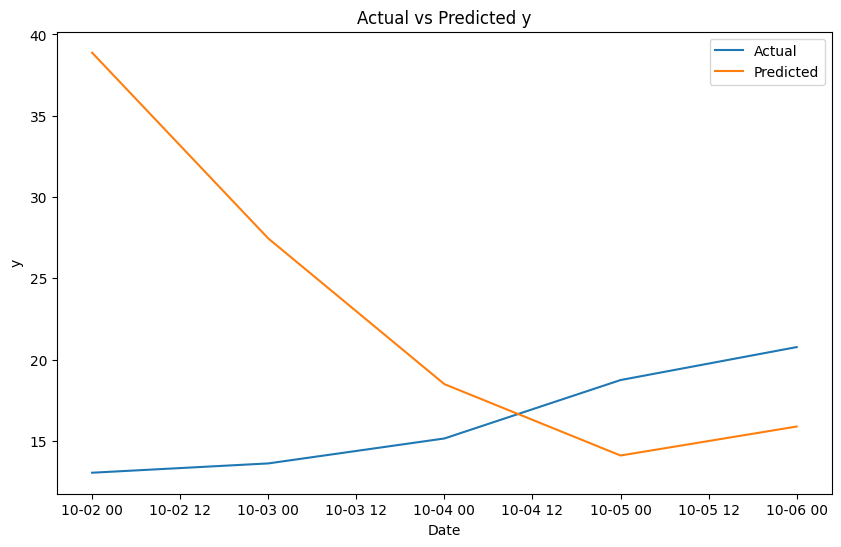

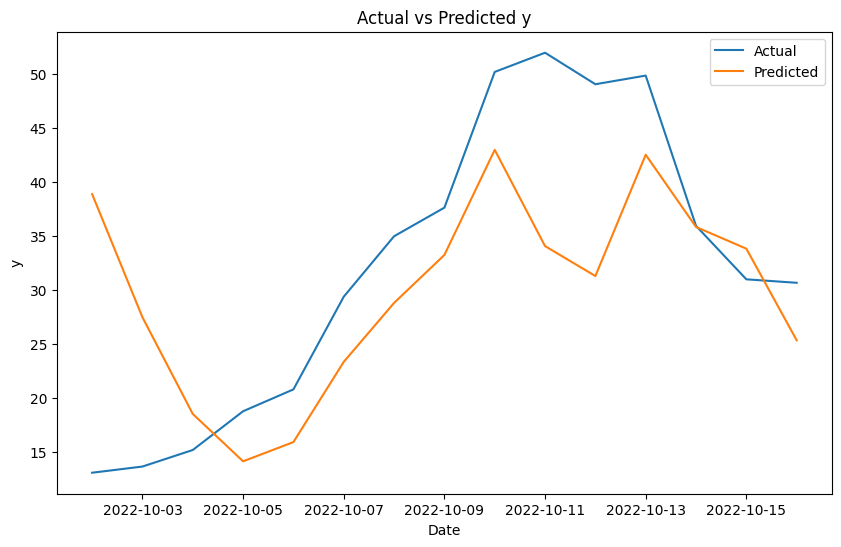

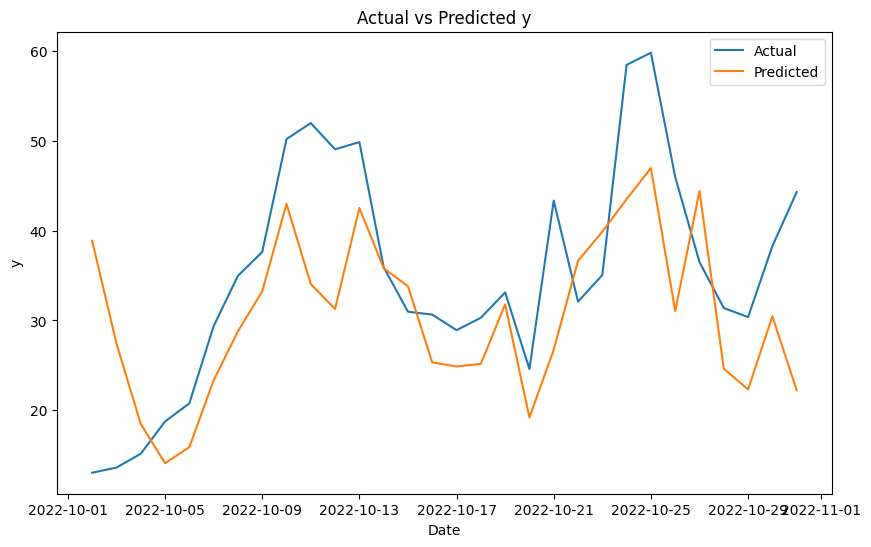

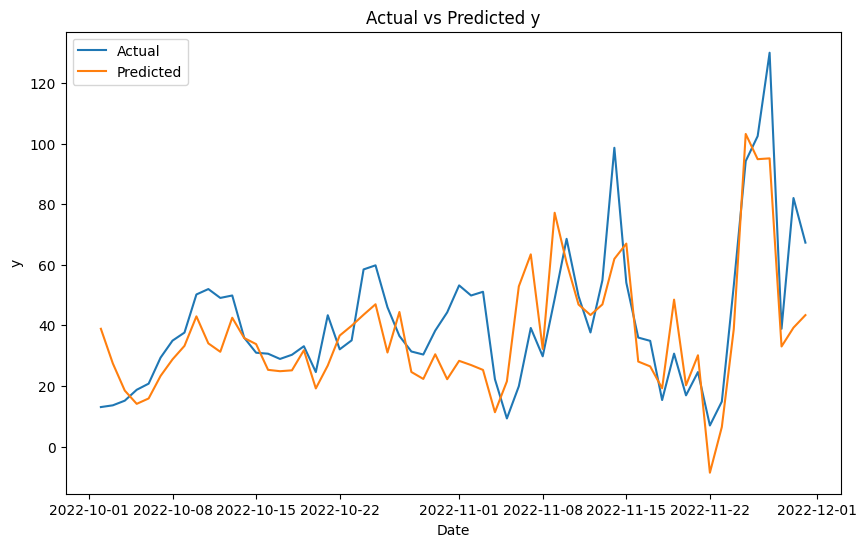

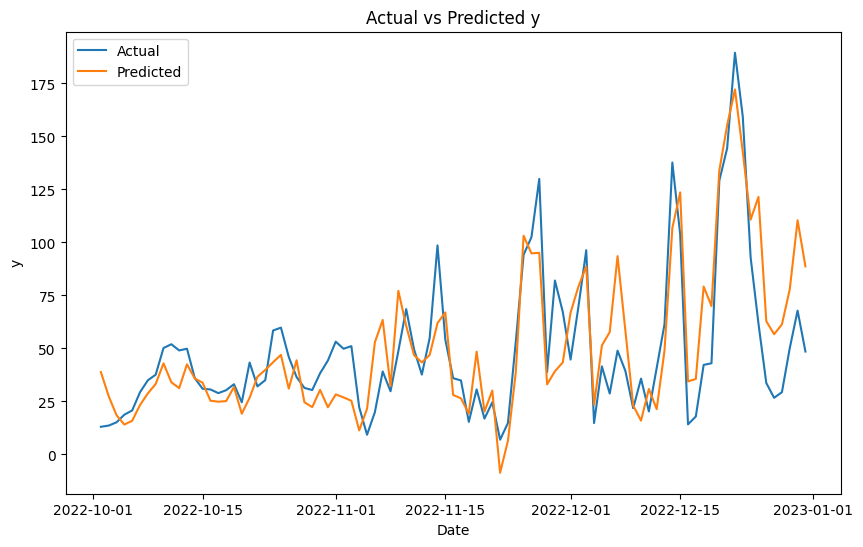

In [247]:
plot_forecast(test_data_combined_ws_ninety[:5], forecast_mn_combined_ws_five)
plot_forecast(test_data_combined_ws_ninety[:15], forecast_mn_combined_ws_fifteen)
plot_forecast(test_data_combined_ws_ninety[:30], forecast_mn_combined_ws_thirty)
plot_forecast(test_data_combined_ws_ninety[:60], forecast_mn_combined_ws_sixty)
plot_forecast(test_data_combined_ws_ninety, forecast_mn_combined_ws_ninety)


# Prerequisites and Data Preparation for SHAP Analysis of Facebook Prophet Models

In [248]:
len(train_data_aqi_ws_thirty)/6

275.6666666666667

In [249]:
import shap
num_samples=50
len_train_data=len(train_data_aqi_ws_thirty)

background_data_combined_ws_thirty = shap.sample(train_data_combined_ws_thirty, num_samples)
background_data_combined_ws_sixty= shap.sample(train_data_combined_ws_sixty, num_samples)
background_data_combined_ws_ninety = shap.sample(train_data_combined_ws_ninety, num_samples)


In [250]:
background_data_aqi_ws_thirty = shap.sample(train_data_aqi_ws_thirty, num_samples)
background_data_aqi_ws_sixty= shap.sample(train_data_aqi_ws_sixty, num_samples)
background_data_aqi_ws_ninety = shap.sample(train_data_aqi_ws_ninety, num_samples)

In [251]:
feature_columns_combined=['ds', 'y','wind_speed','wind_direction','precipitation','pressure', 'temperature','humidity','visibility','cloudiness','Bjelave_SO2','Bjelave_NO2']
feature_columns_aqi=['ds','y']

In [252]:
def prophet_predict_ws_thirty_for_shap(data_df):
    if not isinstance(data_df, pd.DataFrame):
         data_df = pd.DataFrame(data_df, columns=feature_columns_aqi)
    predictions = model_aqi_ws_thirty.predict(data_df)
    return predictions['yhat'].values # Vrati samo yhat kao NumPy array


def prophet_predict_ws_sixty_for_shap(data_df):
    if not isinstance(data_df, pd.DataFrame):
         data_df = pd.DataFrame(data_df, columns=feature_columns_aqi)
    predictions = model_aqi_ws_sixty.predict(data_df)
    return predictions['yhat'].values


def prophet_predict_ws_ninety_for_shap(data_df):
    if not isinstance(data_df, pd.DataFrame):
         data_df = pd.DataFrame(data_df, columns=feature_columns_aqi)
    predictions = model_aqi_ws_ninety.predict(data_df)
    return predictions['yhat'].values

In [253]:
feature_columns_combined

['ds',
 'y',
 'wind_speed',
 'wind_direction',
 'precipitation',
 'pressure',
 'temperature',
 'humidity',
 'visibility',
 'cloudiness',
 'Bjelave_SO2',
 'Bjelave_NO2']

In [254]:
feature_columns_combined = background_data_combined_ws_thirty.columns

In [255]:
def prophet_predict_ws_thirty_for_shap_combined(data_df):
    if not isinstance(data_df, pd.DataFrame):
        data_df = pd.DataFrame(data_df, columns=background_data_combined_ws_thirty.columns)

        for col in background_data_combined_ws_thirty.columns:
            if col in data_df.columns:
                original_dtype = background_data_combined_ws_thirty[col].dtype

                # Posebno rukovanje datetime kolonama
                if original_dtype == 'datetime64[ns]':
                    try:
                        data_df[col] = pd.to_datetime(data_df[col], unit='s', errors='coerce')
                    except:
                        data_df[col] = pd.to_datetime(data_df[col], errors='coerce')
                else:
                    # Ostali tipovi
                    data_df[col] = data_df[col].astype(original_dtype)

    predictions = model_combined_ws_thirty.predict(data_df)
    return predictions['yhat'].values

def prophet_predict_ws_sixty_for_shap_combined_simple(data_df):
    if not isinstance(data_df, pd.DataFrame):
        data_df = pd.DataFrame(data_df, columns=background_data_combined_ws_thirty.columns)

        # Jednostavno kopiraj sve tipove iz originalnog DataFrame-a
        for col in background_data_combined_ws_sixty.columns:
            if col in data_df.columns:
                try:
                    data_df[col] = data_df[col].astype(background_data_combined_ws_sixty[col].dtype)
                except:
                    # Ako astype ne radi za datetime, pokušaj pd.to_datetime
                    if background_data_combined_ws_sixty[col].dtype == 'datetime64[ns]':
                        data_df[col] = pd.to_datetime(data_df[col], unit='s', errors='coerce')

    predictions = model_combined_ws_sixty.predict(data_df)
    return predictions['yhat'].values


def prophet_predict_ws_ninety_for_shap_combined_simple(data_df):
    if not isinstance(data_df, pd.DataFrame):
        data_df = pd.DataFrame(data_df, columns=feature_columns_combined)

        for col in background_data_combined_ws_ninety.columns:
            if col in data_df.columns:
                try:
                    data_df[col] = data_df[col].astype(background_data_combined_ws_ninety[col].dtype)
                except:
                    if background_data_combined_ws_ninety[col].dtype == 'datetime64[ns]':
                        data_df[col] = pd.to_datetime(data_df[col], unit='s', errors='coerce')

    predictions = model_combined_ws_ninety.predict(data_df)
    return predictions['yhat'].values

In [256]:
#train_data_aqi_ws_sixty.rename(columns={'DateTime': 'ds', 'Ambasada_PM2.5': 'y'}, inplace=True)\
data_aqi_to_explain_ws_thirty=test_data_aqi_ws_thirty.rename(columns={'y': 'yhat'})
data_aqi_to_explain_ws_sixty=test_data_aqi_ws_sixty.rename(columns={'y': 'yhat'})
data_aqi_to_explain_ws_ninety=test_data_aqi_ws_ninety.rename(columns={'y': 'yhat'})

day_aqi_to_explain_ws_thirty=test_data_aqi_ws_thirty.rename(columns={'y': 'yhat'}).tail(1)
day_aqi_to_explain_ws_sixty=test_data_aqi_ws_sixty.rename(columns={'y': 'yhat'}).tail(1)
day_aqi_to_explain_ws_ninety=test_data_aqi_ws_ninety.rename(columns={'y': 'yhat'}).tail(1)

In [257]:
"""
data_combined_to_explain_ws_thirty_scaled=test_data_combined_ws_thirty_scaled_with_datetime.rename(columns={'y': 'yhat'})
data_combined_to_explain_ws_sixty_scaled=test_data_combined_ws_sixty_scaled_with_datetime.rename(columns={'y': 'yhat'})
data_combined_to_explain_ws_ninety_scaled=test_data_combined_ws_ninety_scaled_with_datetime.rename(columns={'y': 'yhat'})
"""
data_combined_to_explain_ws_thirty=test_data_combined_ws_thirty.rename(columns={'y': 'yhat'})
data_combined_to_explain_ws_sixty=test_data_combined_ws_sixty.rename(columns={'y': 'yhat'})
data_combined_to_explain_ws_ninety=test_data_combined_ws_ninety.rename(columns={'y': 'yhat'})

day_combined_to_explain_ws_thirty=test_data_combined_ws_thirty.rename(columns={'y': 'yhat'}).tail(1)
day_combined_to_explain_ws_sixty=test_data_combined_ws_sixty.rename(columns={'y': 'yhat'}).tail(1)
day_combined_to_explain_ws_ninety=test_data_combined_ws_ninety.rename(columns={'y': 'yhat'}).tail(1)
"""
day_combined_to_explain_ws_thirty_scaled=test_data_combined_ws_thirty_scaled_with_datetime.rename(columns={'y': 'yhat'}).tail(1)
day_combined_to_explain_ws_sixty_scaled=test_data_combined_ws_sixty_scaled_with_datetime.rename(columns={'y': 'yhat'}).tail(1)
day_combined_to_explain_ws_ninety_scaled=test_data_combined_ws_ninety_scaled_with_datetime.rename(columns={'y': 'yhat'}).tail(1)
"""


"\nday_combined_to_explain_ws_thirty_scaled=test_data_combined_ws_thirty_scaled_with_datetime.rename(columns={'y': 'yhat'}).tail(1)\nday_combined_to_explain_ws_sixty_scaled=test_data_combined_ws_sixty_scaled_with_datetime.rename(columns={'y': 'yhat'}).tail(1)\nday_combined_to_explain_ws_ninety_scaled=test_data_combined_ws_ninety_scaled_with_datetime.rename(columns={'y': 'yhat'}).tail(1)\n"

In [258]:
print("len(data_aqi_to_explain_ws_sixty)", len(data_aqi_to_explain_ws_sixty))
print("len(data_combined_to_explain_ws_sixty)", len(data_combined_to_explain_ws_sixty))

print("len(background_data_aqi_ws_sixty)", len(background_data_aqi_ws_sixty))

len(data_aqi_to_explain_ws_sixty) 61
len(data_combined_to_explain_ws_sixty) 61
len(background_data_aqi_ws_sixty) 50


# SHAP Analysis of Selected Forecast Horizons in Facebook Prophet Model

In [259]:
def analyze_pm10_dataframe(df, pm10_column='y'):

    if pm10_column not in df.columns:
        raise ValueError(f"Kolona '{pm10_column}' ne postoji u DataFrame-u")

    df_analyzed = df.copy()
    categories, colors = classify_pm10_values(df[pm10_column].values)

    df_analyzed['pm10_category'] = categories
    df_analyzed['pm10_color'] = colors

    stats = {}
    unique_categories = df_analyzed['pm10_category'].value_counts()

    for category, count in unique_categories.items():
        percentage = (count / len(df_analyzed)) * 100
        stats[category] = {
            'count': count,
            'percentage': round(percentage, 2)
        }

    return df_analyzed[["ds", pm10_column, "pm10_category", "pm10_color"]], stats

In [260]:
def get_category_arrays(df, pm10_column='y'):
    df_analyzed, _ = analyze_pm10_dataframe(df, pm10_column)
    category_arrays = {}

    for category in df_analyzed['pm10_category'].unique():
        category_data = df_analyzed[df_analyzed['pm10_category'] == category].copy()
        category_arrays[category] = category_data

    return category_arrays

In [261]:
import pandas as pd
import numpy as np

def compare_predictions_by_category(df_predictions, df_actual, categories_of_PM10_in_a_month, top_n=3):
    merged_df = pd.merge(df_predictions, df_actual, on='ds', suffixes=('_pred', '_actual'))
    matching_categories = merged_df[merged_df['pm10_category_pred'] == merged_df['pm10_category_actual']]
    filtered_df = matching_categories[matching_categories['pm10_category_actual'].isin(categories_of_PM10_in_a_month)]
    filtered_df = filtered_df.copy()
    filtered_df['absolute_error'] = abs(filtered_df['yhat'] - filtered_df['y'])
    filtered_df['mape'] = (filtered_df['absolute_error'] / abs(filtered_df['y']) * 100)

    filtered_df['accuracy_percentage'] = np.maximum(0, 100 - filtered_df['mape'])  # Nikad negativno

    best_predictions = []

    for category in categories_of_PM10_in_a_month:
        category_data = filtered_df[filtered_df['pm10_category_actual'] == category]

        if len(category_data) > 0:
            best_for_category = category_data.nsmallest(top_n, 'absolute_error')
            best_predictions.append(best_for_category)

    if best_predictions:
        result_df = pd.concat(best_predictions, ignore_index=True)

        final_df = pd.DataFrame({
            'ds': result_df['ds'],
            'PM10_Category': result_df['pm10_category_actual'],
            'Predicted_Value': result_df['yhat'],
            'Actual_Value': result_df['y'],
            'Absolute_Error': result_df['absolute_error'],
            'MAPE_Error': result_df['mape'].round(2),
            'Accuracy_Percentage': result_df['accuracy_percentage'].round(2)
        })

        final_df = final_df.sort_values(['PM10_Category', 'Absolute_Error'])

        return final_df
    else:
        return pd.DataFrame()

In [262]:
df_with_categories_ws_thirty_predicted, statistics_ws_thirty_predicted = analyze_pm10_dataframe(forecast_combined_ws_thirty, 'yhat')

In [577]:
df_with_categories_ws_thirty_predicted

ds        yhat                             pm10_category pm10_color
0  2022-12-01   69.928907                         Moderate (55-154)    #ffff00
1  2022-12-02   82.118854                         Moderate (55-154)    #ffff00
2  2022-12-03   91.850573                         Moderate (55-154)    #ffff00
3  2022-12-04   27.478195                               Good (0-54)    #00e400
4  2022-12-05   55.840018                         Moderate (55-154)    #ffff00
5  2022-12-06   61.587447                         Moderate (55-154)    #ffff00
6  2022-12-07   96.296073                         Moderate (55-154)    #ffff00
7  2022-12-08   61.591069                         Moderate (55-154)    #ffff00
8  2022-12-09   26.627137                               Good (0-54)    #00e400
9  2022-12-10   18.612218                               Good (0-54)    #00e400
10 2022-12-11   33.366610                               Good (0-54)    #00e400
11 2022-12-12   24.302408                               Good (0-54)    #00e400
12 2022-12-13   52.498659                               Good (0-54)    #00e400
13 2022-12-14  108.843129                         Moderate (55-154)    #ffff00
14 2022-12-15  125.522162                         Moderate (55-154)    #ffff00
15 2022-12-16   36.784574                               Good (0-54)    #00e400
16 2022-12-17   37.702995                               Good (0-54)    #00e400
17 2022-12-18   81.360594                         Moderate (55-154)    #ffff00
18 2022-12-19   72.302758                         Moderate (55-154)    #ffff00
19 2022-12-20  135.507572                         Moderate (55-154)    #ffff00
20 2022-12-21  156.327325  Unhealthy for Sensitive Groups (155-254)    #ff7e00
21 2022-12-22  173.893188  Unhealthy for Sensitive Groups (155-254)    #ff7e00
22 2022-12-23  144.377145                         Moderate (55-154)    #ffff00
23 2022-12-24  112.796013                         Moderate (55-154)    #ffff00
24 2022-12-25  122.370263                         Moderate (55-154)    #ffff00
25 2022-12-26   64.811268                         Moderate (55-154)    #ffff00
26 2022-12-27   59.395399                         Moderate (55-154)    #ffff00
27 2022-12-28   64.274275                         Moderate (55-154)    #ffff00
28 2022-12-29   80.670440                         Moderate (55-154)    #ffff00
29 2022-12-30  113.578486                         Moderate (55-154)    #ffff00
30 2022-12-31   91.170299                         Moderate (55-154)    #ffff00

In [263]:
df_with_categories_ws_thirty_predicted['pm10_category'].unique()

array(['Moderate (55-154)', 'Good (0-54)',
       'Unhealthy for Sensitive Groups (155-254)'], dtype=object)

In [264]:
df_with_categories_ws_thirty_actual, statistics_ws_thirty_actual = analyze_pm10_dataframe(test_data_combined_ws_thirty, 'y')

In [265]:
df_with_categories_ws_sixty_predicted, statistics_ws_sixty_predicted = analyze_pm10_dataframe(forecast_combined_ws_sixty, 'yhat')

In [266]:
df_with_categories_ws_sixty_actual, statistics_ws_sixty_actual = analyze_pm10_dataframe(test_data_combined_ws_sixty, 'y')

In [571]:
categories_list = ['Good (0-54)', 'Moderate (55-154)', 'Unhealthy for Sensitive Groups (155-254)']
best_predictions_df = compare_predictions_by_category(
     df_predictions=df_with_categories_ws_thirty_predicted,
     df_actual=df_with_categories_ws_thirty_actual,
     categories_of_PM10_in_a_month=df_with_categories_ws_thirty_predicted['pm10_category'].unique(),
     top_n=4
)
print("Best predictions:")
best_predictions_df

Best predictions:


ds                             PM10_Category  Predicted_Value  \
4 2022-12-09                               Good (0-54)        26.627137   
5 2022-12-04                               Good (0-54)        27.478195   
6 2022-12-11                               Good (0-54)        33.366610   
7 2022-12-12                               Good (0-54)        24.302408   
0 2022-12-03                         Moderate (55-154)        91.850573   
1 2022-12-20                         Moderate (55-154)       135.507572   
2 2022-12-02                         Moderate (55-154)        82.118854   
3 2022-12-24                         Moderate (55-154)       112.796013   
8 2022-12-22  Unhealthy for Sensitive Groups (155-254)       173.893188   

   Actual_Value  Absolute_Error  MAPE_Error  Accuracy_Percentage  
4     21.807971        4.819167       22.10                77.90  
5     14.803542       12.674653       85.62                14.38  
6     20.287982       13.078628       64.46                35.54  
7     40.775529       16.473121       40.40                59.60  
0     96.345830        4.495257        4.67                95.33  
1    129.196500        6.311072        4.88                95.12  
2     69.622508       12.496346       17.95                82.05  
3     92.948049       19.847963       21.35                78.65  
8    189.514209       15.621021        8.24                91.76

In [500]:
pm10_good_prediction.columns

Index(['ds', 'PM10_Category', 'Predicted_Value', 'Actual_Value',
       'Absolute_Error', 'MAPE_Error', 'Accuracy_Percentage'],
      dtype='object')

In [574]:
filter_query = lambda df, col, value: df.query(f"{col} == @value")

pm10_good_prediction=filter_query(best_predictions_df, 'PM10_Category', 'Good (0-54)')
pm10_moderate_prediction=filter_query(best_predictions_df, 'PM10_Category', 'Moderate (55-154)')
pm10_unhealthy_for_sensitive_groups_best_prediction=filter_query(best_predictions_df, 'PM10_Category', 'Unhealthy for Sensitive Groups (155-254)')
prediction_data = {
    'good': pm10_good_prediction,
    'moderate': pm10_moderate_prediction,
    'unhealthy_for_sensitive_groups': pm10_unhealthy_for_sensitive_groups_best_prediction
}

actual_rows = {}

for PM10_Category, prediction_df in prediction_data.items():
    target_date = prediction_df['ds'].iloc[0]
    print("PM10_Category: ", PM10_Category)

    if(PM10_Category=="moderate"): #delete later
      target_date = prediction_df['ds'].iloc[0]# delete later
      print("moderatee") #delete later
    actual_row = test_data_combined_ws_thirty.query(f"ds == @target_date")
    actual_rows[PM10_Category] = actual_row

    print(f"Category: {PM10_Category}")
    print(f"Target date: {target_date}")
    print(f"Found rows: {len(actual_row)}")
    print("-" * 40)

actual_row_pm10_good_prediction = actual_rows['good']
actual_row_pm10_moderate_prediction = actual_rows['moderate']
actual_row_pm10_unhealthy_for_sensitive_groups_prediction = actual_rows['unhealthy_for_sensitive_groups']


PM10_Category:  good
Category: good
Target date: 2022-12-09 00:00:00
Found rows: 1
----------------------------------------
PM10_Category:  moderate
moderatee
Category: moderate
Target date: 2022-12-03 00:00:00
Found rows: 1
----------------------------------------
PM10_Category:  unhealthy_for_sensitive_groups
Category: unhealthy_for_sensitive_groups
Target date: 2022-12-22 00:00:00
Found rows: 1
----------------------------------------


In [560]:
actual_row_pm10_good_prediction[['ds', 'y']]

ds          y
1803 2022-12-09  21.807971

In [561]:
actual_row_pm10_moderate_prediction[['ds', 'y']]

ds         y
1814 2022-12-20  129.1965

In [562]:
actual_row_pm10_unhealthy_for_sensitive_groups_prediction[['ds', 'y']]

ds           y
1816 2022-12-22  189.514209

In [563]:
custom_feature_names = [
    'Bjelave_PM10' if col == 'yhat' else
    'DateTime' if col == 'ds' else
    col
    for col in data_combined_to_explain_ws_thirty.columns
]

In [564]:
def calculate_index_of_shap_value(df_test_data, index_of_predicted_value):
  index_of_first_element_in_test_data = df_test_data.index[0]
  return (index_of_predicted_value - index_of_first_element_in_test_data)[0]

In [575]:
index_of_good_pm10_sv = calculate_index_of_shap_value(test_data_combined_ws_thirty, actual_row_pm10_good_prediction.index)
index_of_moderate_pm10_sv = calculate_index_of_shap_value(test_data_combined_ws_thirty, actual_row_pm10_moderate_prediction.index)
index_of_unhealthy_for_sensitive_groups_pm10_sv = calculate_index_of_shap_value(test_data_combined_ws_thirty, actual_row_pm10_unhealthy_for_sensitive_groups_prediction.index)
print("index_of_good_pm10_sv: ", index_of_good_pm10_sv)
print("index_of_moderate_pm10_sv: ", index_of_moderate_pm10_sv)
print("index_of_unhealthy_for_sensitive_groups_pm10_sv: ", index_of_unhealthy_for_sensitive_groups_pm10_sv)


index_of_good_pm10_sv:  8
index_of_moderate_pm10_sv:  2
index_of_unhealthy_for_sensitive_groups_pm10_sv:  21


In [523]:
explainer_data_combined_ws_thirty = shap.KernelExplainer(prophet_predict_ws_thirty_for_shap_combined, background_data_combined_ws_thirty)
shap_values_data_combined_ws_thirty = explainer_data_combined_ws_thirty.shap_values(data_combined_to_explain_ws_thirty)

  0%|          | 0/31 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [346]:
explainer_data_combined_ws_thirty_mod = shap.Explanation(
    values=shap_values_data_combined_ws_thirty,
    base_values=np.array([explainer_data_combined_ws_thirty.expected_value] * len(shap_values_data_combined_ws_thirty)),
    data=data_combined_to_explain_ws_thirty,
    feature_names=custom_feature_names
)

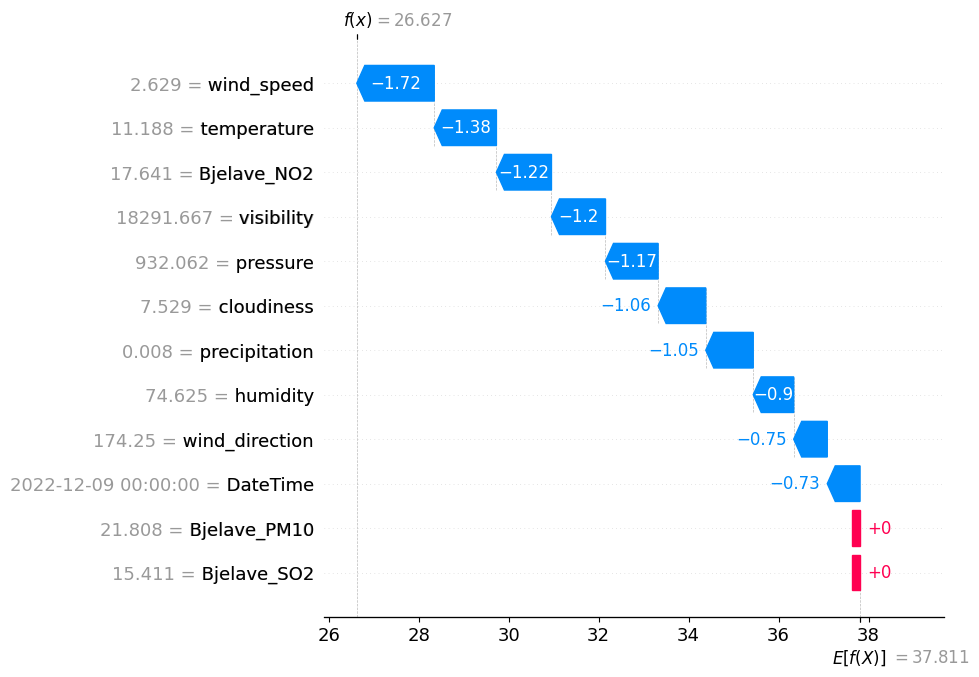

In [566]:
shap.plots.waterfall(explainer_data_combined_ws_thirty_mod[index_of_good_pm10_sv], max_display=len(custom_feature_names))

In [418]:
import shap
print(f"SHAP verzija: {shap.__version__}")

SHAP verzija: 0.48.0


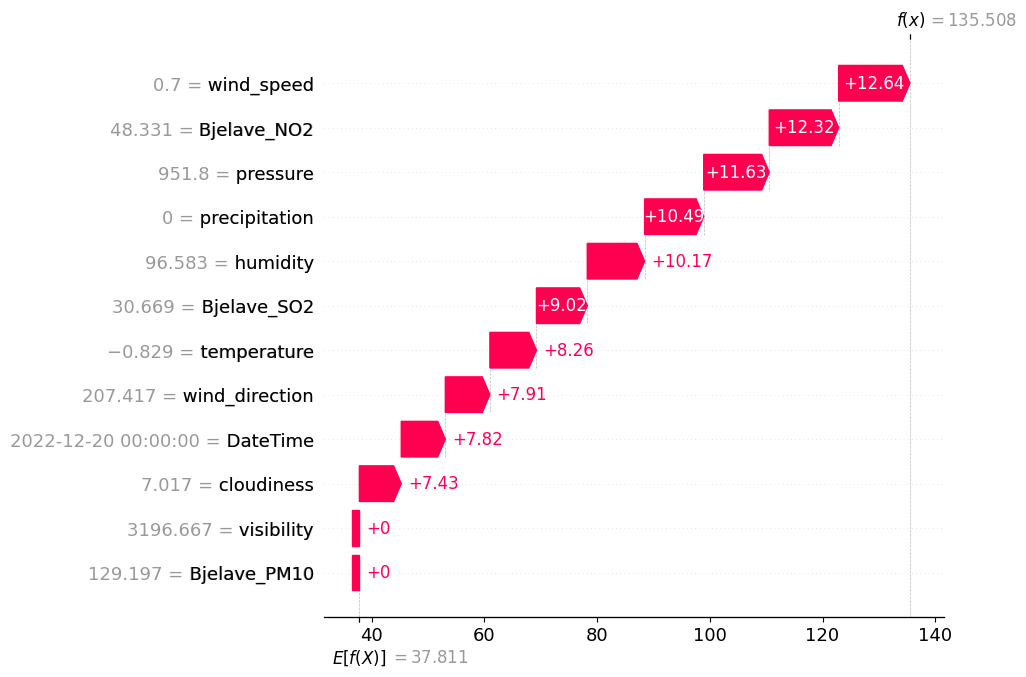

In [573]:
shap.plots.waterfall(explainer_data_combined_ws_thirty_mod[index_of_moderate_pm10_sv], max_display=len(custom_feature_names))

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_thirty_mod[index_of_unhealthy_for_sensitive_groups_pm10_sv], max_display=len(custom_feature_names))

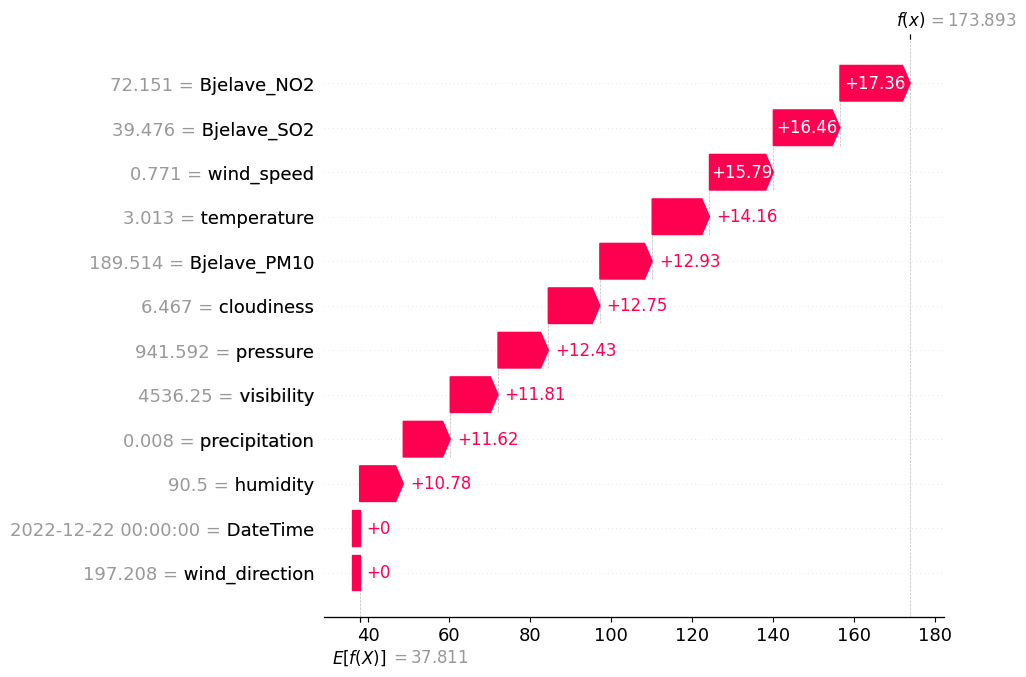

In [349]:
shap.plots.waterfall(explainer_data_combined_ws_thirty_mod[index_of_unhealthy_for_sensitive_groups_pm10_sv], max_display=len(custom_feature_names))

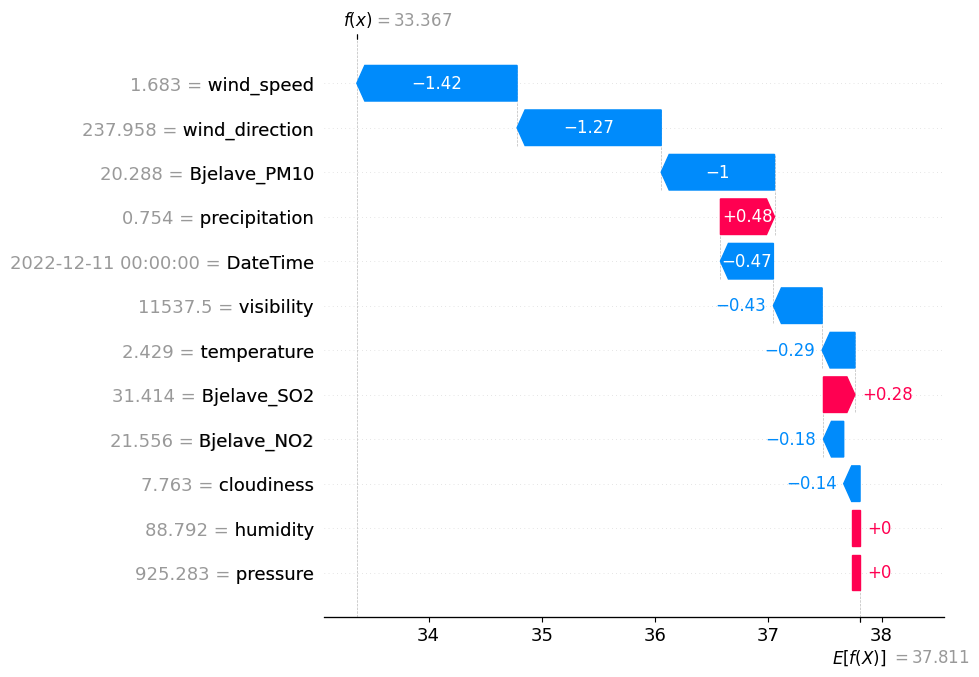

In [545]:
shap.plots.waterfall(explainer_data_combined_ws_thirty_mod[10], max_display=len(custom_feature_names))

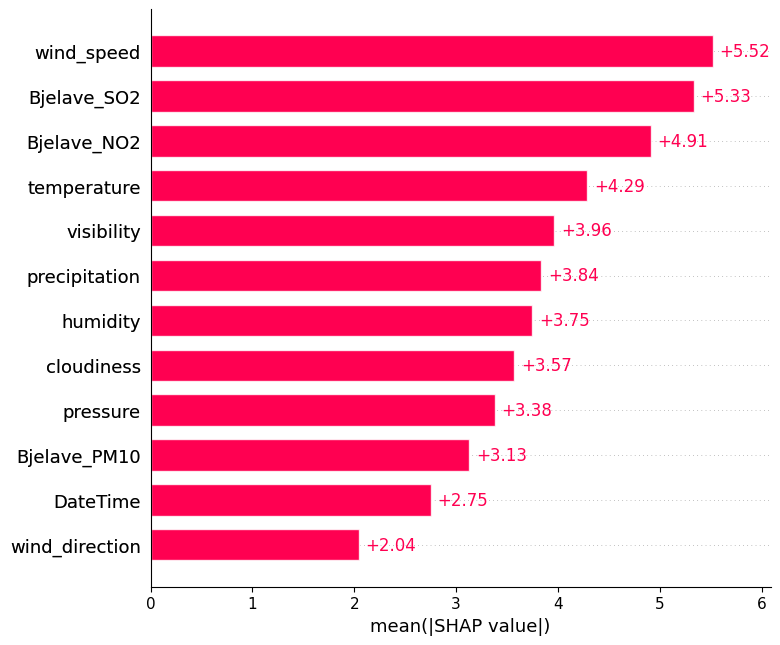

In [350]:
shap.plots.bar(explainer_data_combined_ws_thirty_mod, max_display=len(custom_feature_names))

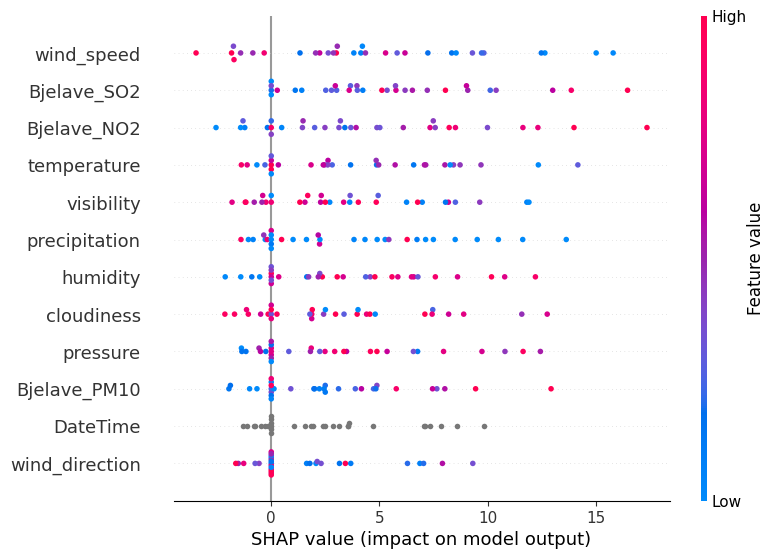

In [351]:
shap.plots.beeswarm(explainer_data_combined_ws_thirty_mod, max_display=len(custom_feature_names))

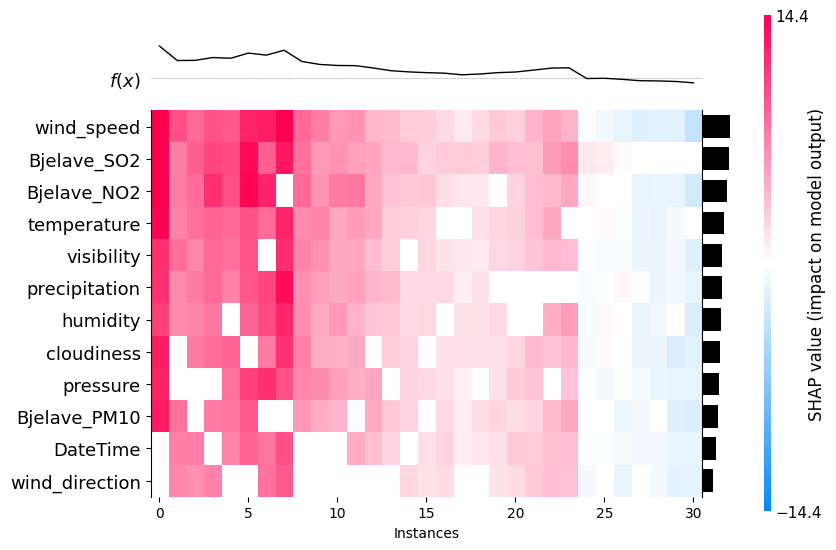

<Axes: xlabel='Instances'>

In [352]:
shap.plots.heatmap(explainer_data_combined_ws_thirty_mod, max_display=len(custom_feature_names))


In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))

feature_importance = np.abs(shap_values_data_combined_ws_thirty).mean(axis=0)
top_features_idx = np.argsort(feature_importance)[-8:]

violin_data = [shap_values_data_combined_ws_thirty[:, i] for i in top_features_idx]
top_feature_names = [custom_feature_names[i] for i in top_features_idx]

parts = ax.violinplot(violin_data,
                     positions=range(len(top_feature_names)),
                     vert=False,
                     showmeans=True,
                     showmedians=True)

for pc in parts['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)

ax.set_yticks(range(len(top_feature_names)))
ax.set_yticklabels(top_feature_names, fontsize=12)
ax.set_xlabel('SHAP Value', fontsize=14)
ax.set_title('Feature Impact Distribution', fontsize=16)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2281788681.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=shap_long, x='Feature', y='SHAP_Value',


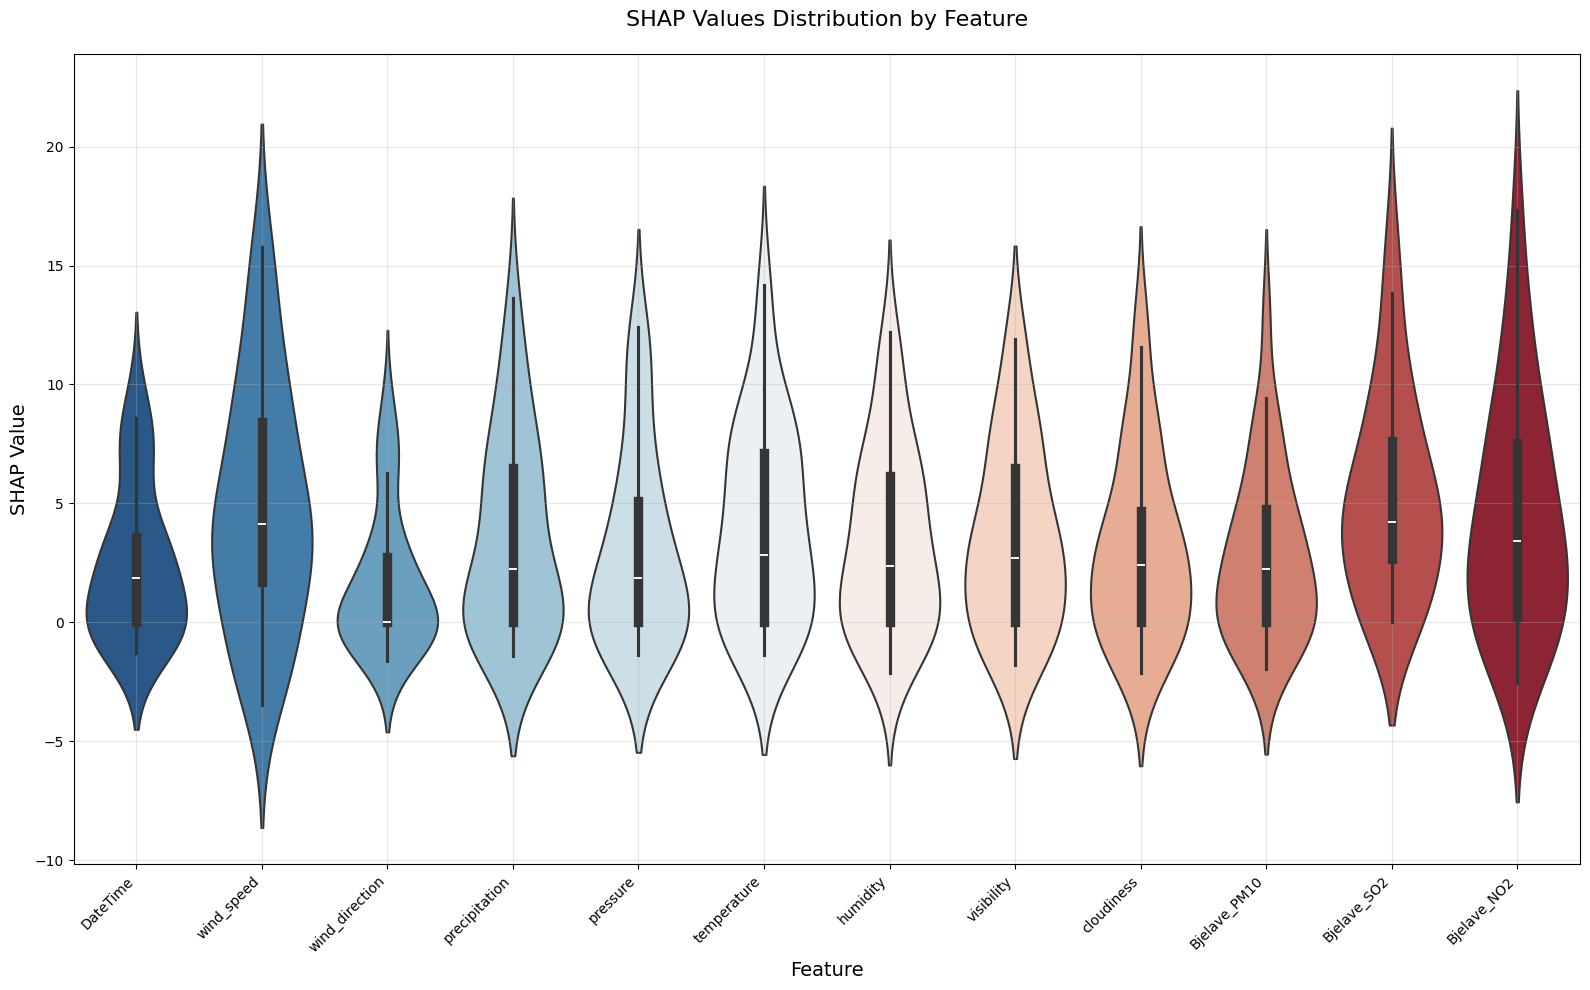

In [534]:
shap_df = pd.DataFrame(shap_values_data_combined_ws_thirty, columns=custom_feature_names)
shap_long = shap_df.melt(var_name='Feature', value_name='SHAP_Value')

plt.figure(figsize=(16, 10))
sns.violinplot(data=shap_long, x='Feature', y='SHAP_Value',
               palette='RdBu_r',
               inner='box',
               linewidth=1.5)

plt.xticks(rotation=45, ha='right')
plt.title('SHAP Values Distribution by Feature', fontsize=16, pad=20)
plt.ylabel('SHAP Value', fontsize=14)
plt.xlabel('Feature', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

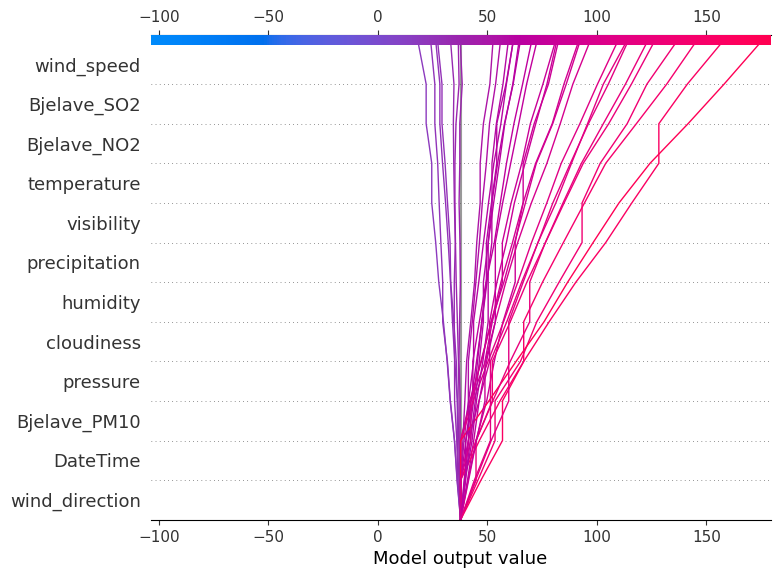

In [353]:
shap.decision_plot(explainer_data_combined_ws_thirty.expected_value, shap_values_data_combined_ws_thirty, custom_feature_names)


In [376]:
print(f"Min indeks: {test_data_combined_ws_thirty.index.min()}")
print(f"Max indeks: {test_data_combined_ws_thirty.index.max()}")
print(f"Broj redova: {len(test_data_combined_ws_thirty)}")

Min indeks: 1795
Max indeks: 1825
Broj redova: 31


In [472]:
explainer_data_combined_ws_thirty_mod.base_values[index_of_good_pm10_sv]

np.float64(37.810535534221124)

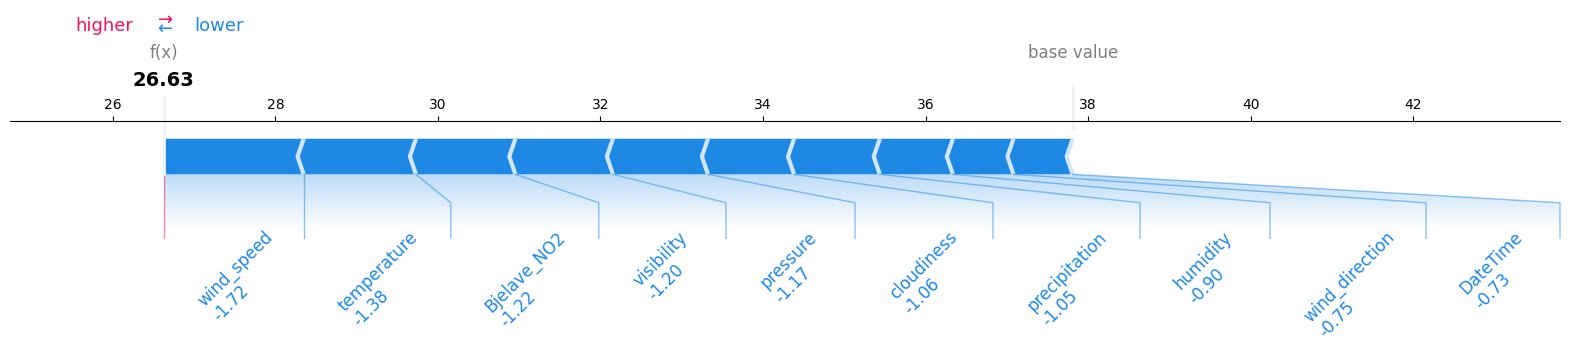

In [525]:
data_row = explainer_data_combined_ws_thirty_mod.data.iloc[index_of_good_pm10_sv]
data_as_strings = [str(val) for val in data_row]
values = explainer_data_combined_ws_thirty_mod.values[index_of_good_pm10_sv]

complete_labels = []
for name, val, shap_val in zip(custom_feature_names, data_as_strings, values):
    short_name = name
    complete_labels.append(f"{short_name}\n{shap_val:+.2f}")

shap.plots.force(explainer_data_combined_ws_thirty_mod.base_values[index_of_good_pm10_sv],
                 explainer_data_combined_ws_thirty_mod.values[index_of_good_pm10_sv],
                 data_as_strings,
                 feature_names=complete_labels,
                 matplotlib=True,
                 text_rotation=45)

In [465]:
print(test_data_combined_ws_thirty.columns)
print(explainer_data_combined_ws_thirty_mod.values[index_of_good_pm10_sv] )


Index(['ds', 'wind_speed', 'wind_direction', 'precipitation', 'pressure',
       'temperature', 'humidity', 'visibility', 'cloudiness', 'y',
       'Bjelave_SO2', 'Bjelave_NO2'],
      dtype='object')
[-0.72858557 -1.72072972 -0.74592149 -1.05498028 -1.16944043 -1.38171387
 -0.8990873  -1.20067058 -1.05910107  0.          0.         -1.22316793]


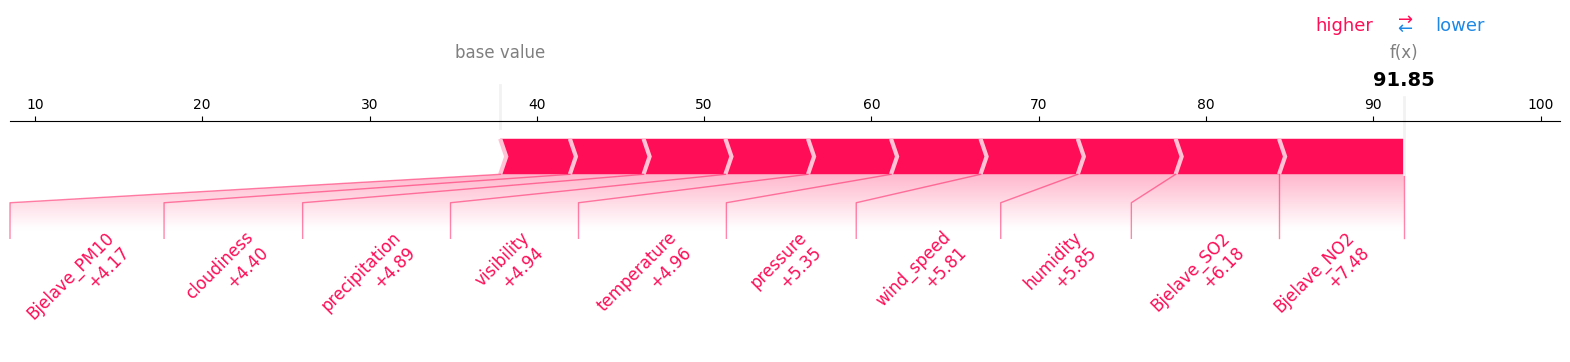

In [480]:
data_row = explainer_data_combined_ws_thirty_mod.data.iloc[index_of_moderate_pm10_sv]
data_as_strings = [str(val) for val in data_row]
values = explainer_data_combined_ws_thirty_mod.values[index_of_moderate_pm10_sv]

complete_labels = []
for name, val, shap_val in zip(custom_feature_names, data_as_strings, values):
    short_name = name
    complete_labels.append(f"{short_name}\n{shap_val:+.2f}")

shap.plots.force(explainer_data_combined_ws_thirty_mod.base_values[index_of_moderate_pm10_sv],
                 explainer_data_combined_ws_thirty_mod.values[index_of_moderate_pm10_sv],
                 data_as_strings,
                 feature_names=complete_labels,
                 matplotlib=True,
                 text_rotation=45)

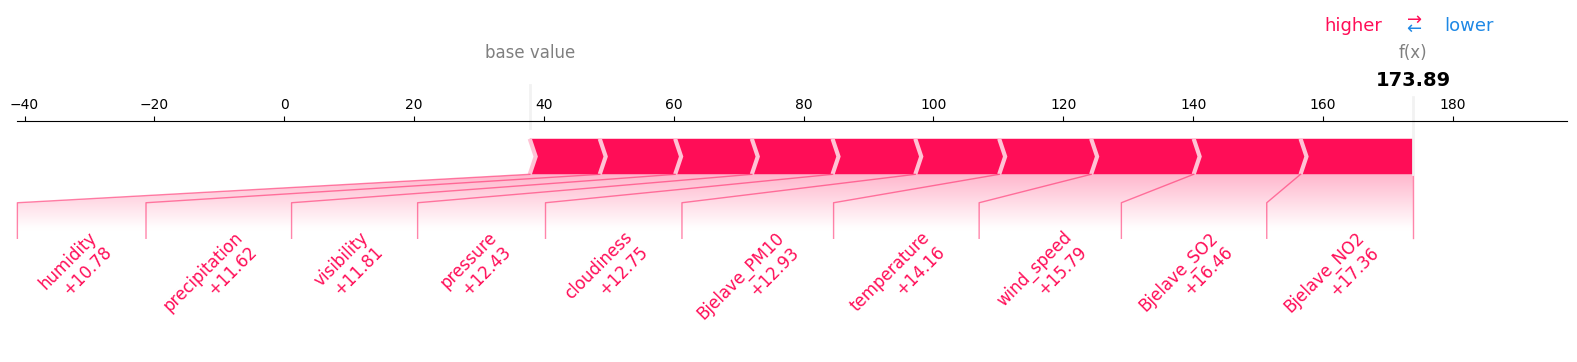

In [481]:
data_row = explainer_data_combined_ws_thirty_mod.data.iloc[index_of_unhealthy_for_sensitive_groups_pm10_sv]
data_as_strings = [str(val) for val in data_row]
values = explainer_data_combined_ws_thirty_mod.values[index_of_unhealthy_for_sensitive_groups_pm10_sv]

complete_labels = []
for name, val, shap_val in zip(custom_feature_names, data_as_strings, values):
    short_name = name
    complete_labels.append(f"{short_name}\n{shap_val:+.2f}")

shap.plots.force(explainer_data_combined_ws_thirty_mod.base_values[index_of_unhealthy_for_sensitive_groups_pm10_sv],
                 explainer_data_combined_ws_thirty_mod.values[index_of_unhealthy_for_sensitive_groups_pm10_sv],
                 data_as_strings,
                 feature_names=complete_labels,
                 matplotlib=True,
                 text_rotation=45)

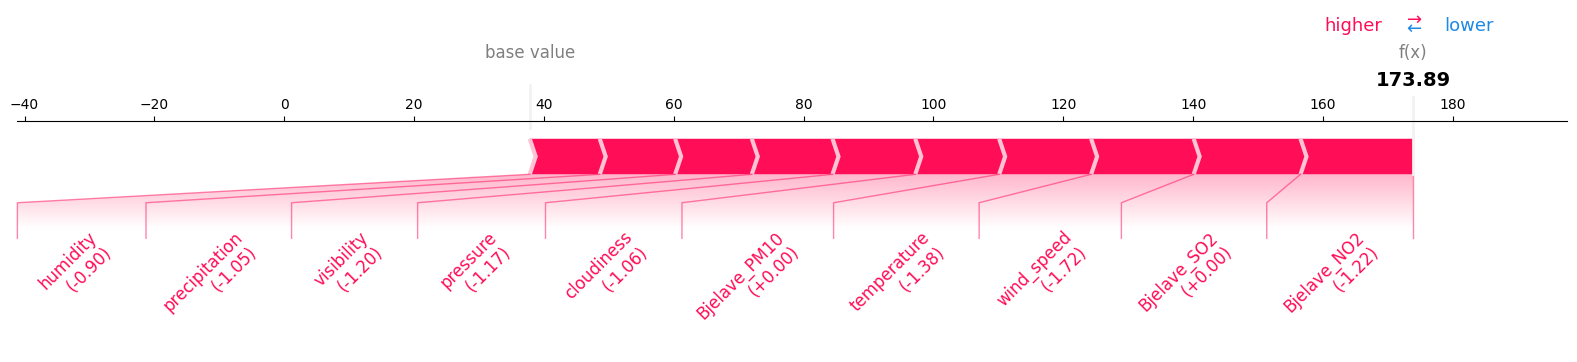

In [540]:
data_row = explainer_data_combined_ws_thirty_mod.data.iloc[index_of_unhealthy_for_sensitive_groups_pm10_sv]
data_as_strings = [str(val) for val in data_row]

shap.plots.force(explainer_data_combined_ws_thirty_mod.base_values[index_of_unhealthy_for_sensitive_groups_pm10_sv],
                 explainer_data_combined_ws_thirty_mod.values[index_of_unhealthy_for_sensitive_groups_pm10_sv],
                 data_as_strings,
                 feature_names=[f"{name}\n({shap_val:+.2f})"
                               for name, val, shap_val in zip(custom_feature_names, data_as_strings, values)],
                 matplotlib=True,
                 text_rotation=45)

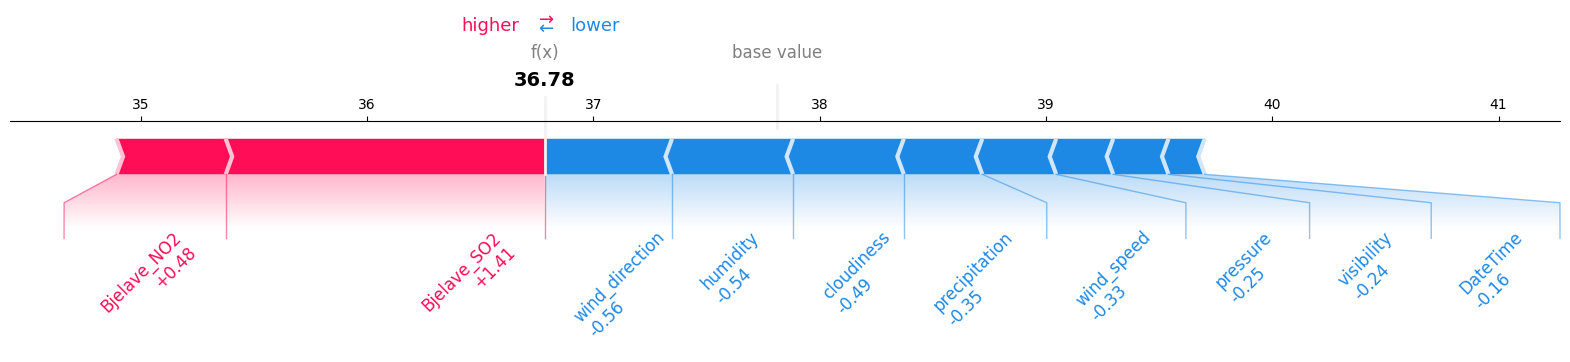

In [570]:
data_row = explainer_data_combined_ws_thirty_mod.data.iloc[15]
data_as_strings = [str(val) for val in data_row]
values = explainer_data_combined_ws_thirty_mod.values[15]

complete_labels = []
for name, val, shap_val in zip(custom_feature_names, data_as_strings, values):
    short_name = name
    complete_labels.append(f"{short_name}\n{shap_val:+.2f}")

shap.plots.force(explainer_data_combined_ws_thirty_mod.base_values[15],
                 explainer_data_combined_ws_thirty_mod.values[15],
                 data_as_strings,
                 feature_names=complete_labels,
                 matplotlib=True,
                 text_rotation=45)

In [456]:
explainer_data_combined_ws_thirty_mod.data.iloc[index_of_unhealthy_for_sensitive_groups_pm10_sv]

ds                2022-12-22 00:00:00
wind_speed                   0.770833
wind_direction             197.208333
precipitation                0.008333
pressure                   941.591667
temperature                    3.0125
humidity                         90.5
visibility                    4536.25
cloudiness                   6.466667
yhat                       189.514209
Bjelave_SO2                 39.475667
Bjelave_NO2                 72.150646
Name: 1816, dtype: object

# Dependence Plots for Window Size 30 (FB Prophet Model)

In [611]:
custom_feature_names_trimmed=list(df_processed_combined_data_daily.iloc[0].index)
custom_feature_names_trimmed.remove('DateTime')
print(custom_feature_names_trimmed)

['wind_speed', 'wind_direction', 'precipitation', 'pressure', 'temperature', 'humidity', 'visibility', 'cloudiness', 'Bjelave_PM10', 'Bjelave_SO2', 'Bjelave_NO2']


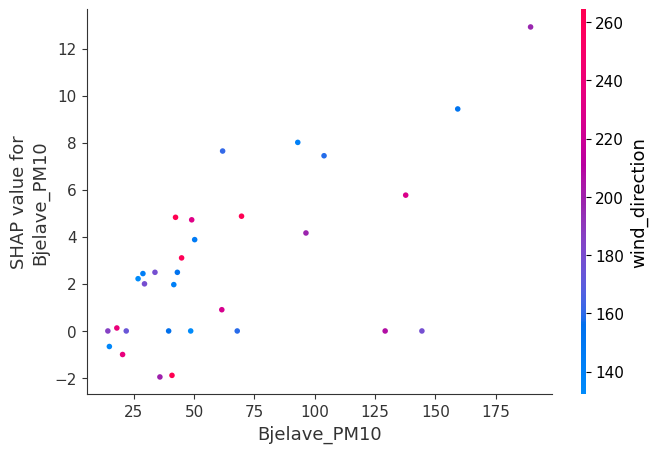

In [613]:
shap.dependence_plot(
    ind=8,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=1
)

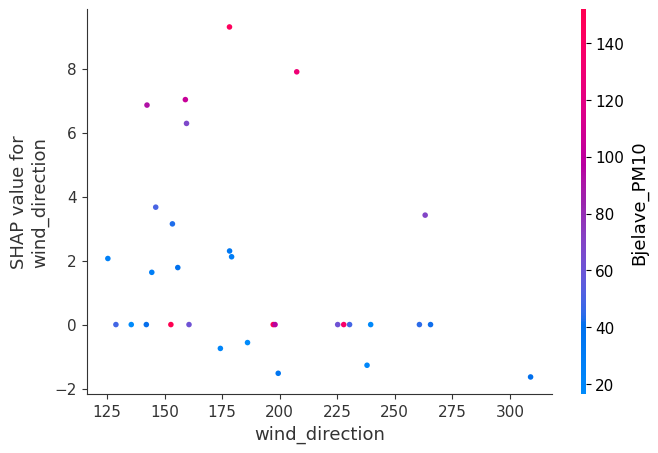

In [614]:
shap.dependence_plot(
    ind=1,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=8
)

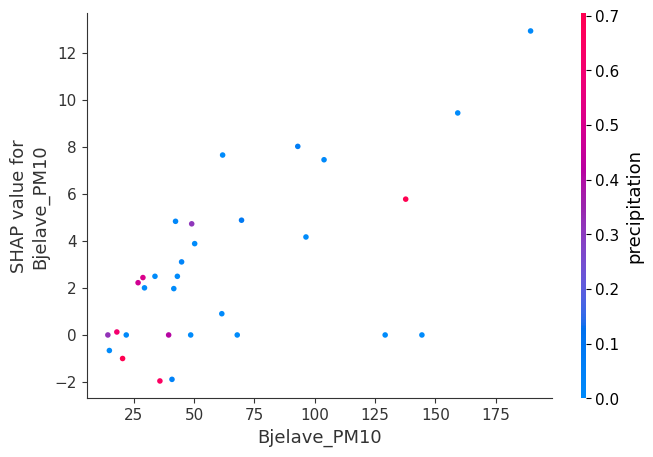

In [615]:
shap.dependence_plot(
    ind=8,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=2
)

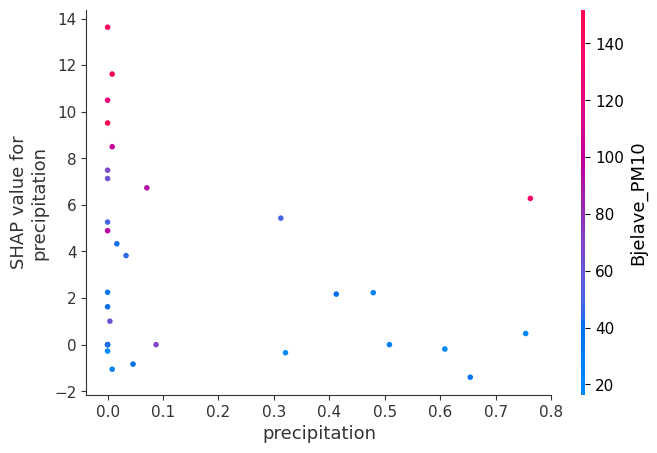

In [616]:
shap.dependence_plot(
    ind=2,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=8
)

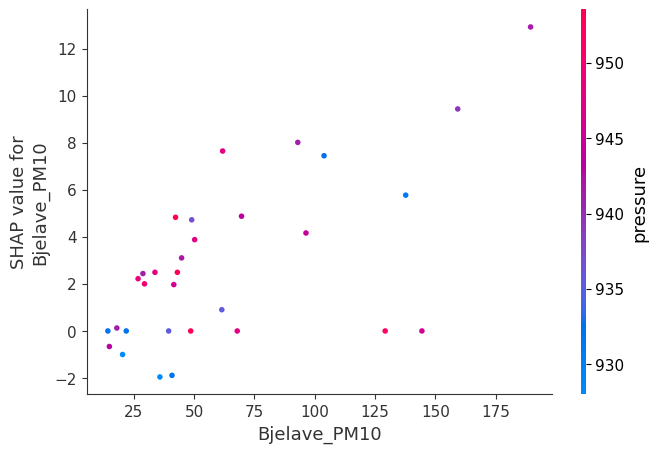

In [617]:
shap.dependence_plot(
    ind=8,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=3
)

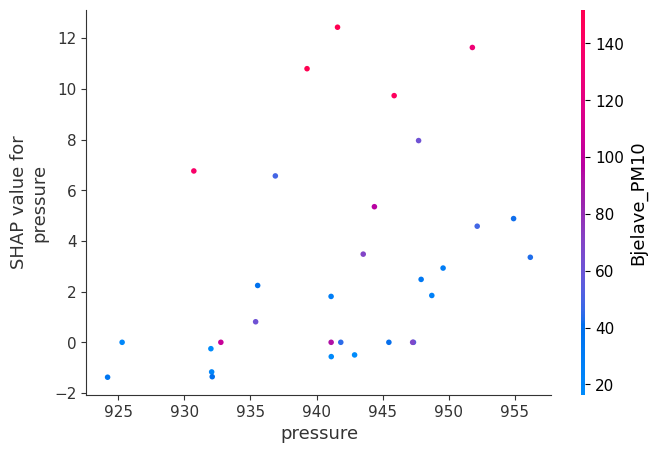

In [618]:
shap.dependence_plot(
    ind=3,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=8
)

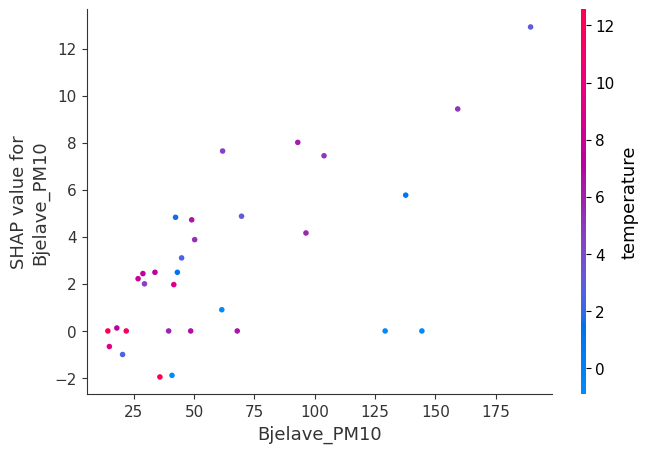

In [619]:
shap.dependence_plot(
    ind=8,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=4
)

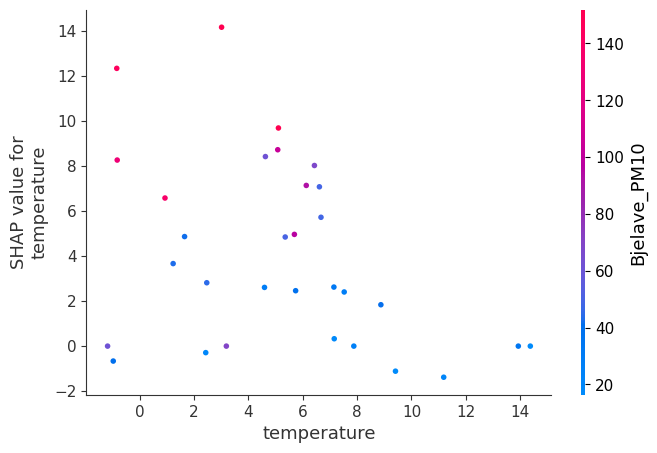

In [620]:
shap.dependence_plot(
    ind=4,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=8
)

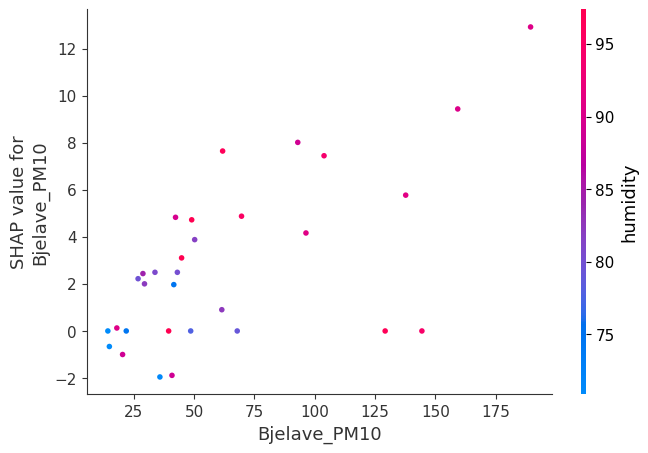

In [621]:
shap.dependence_plot(
    ind=8,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=5
)

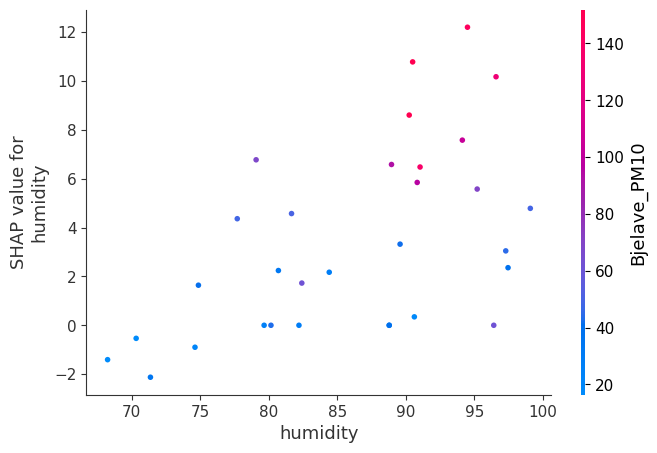

In [622]:
shap.dependence_plot(
    ind=5,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=8
)

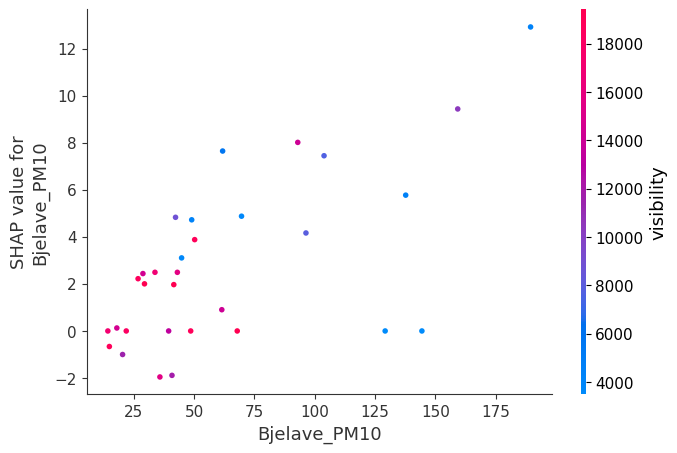

In [623]:
shap.dependence_plot(
    ind=8,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=6
)

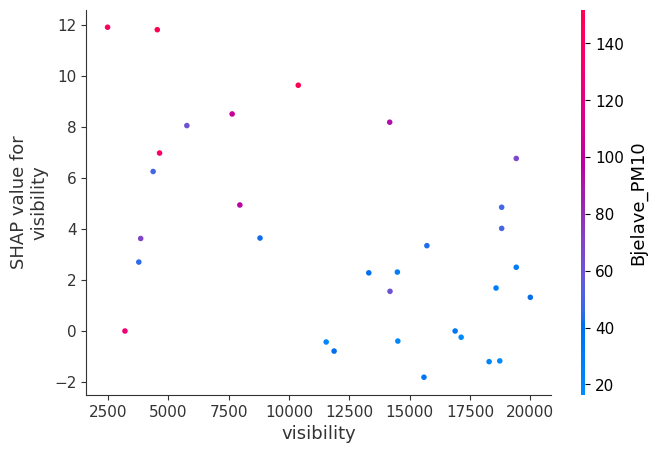

In [624]:
shap.dependence_plot(
    ind=6,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=8
)

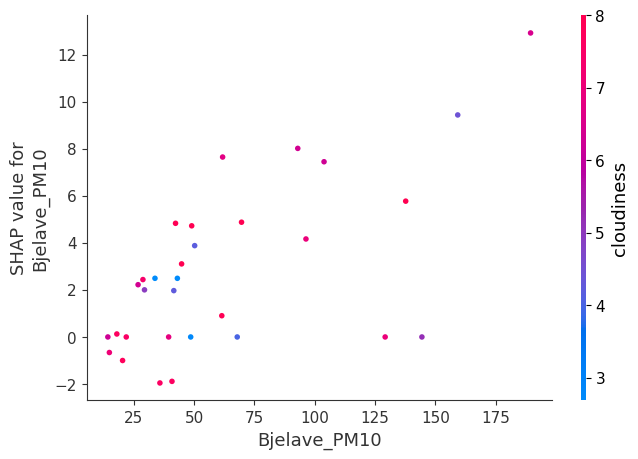

In [625]:
shap.dependence_plot(
    ind=8,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=7
)

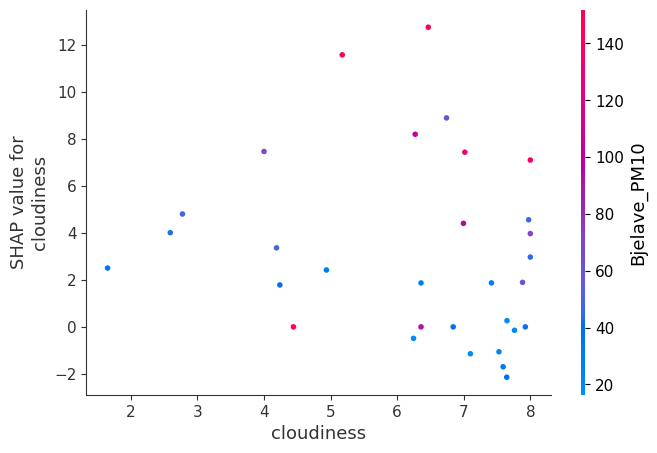

In [626]:
shap.dependence_plot(
    ind=7,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=8
)

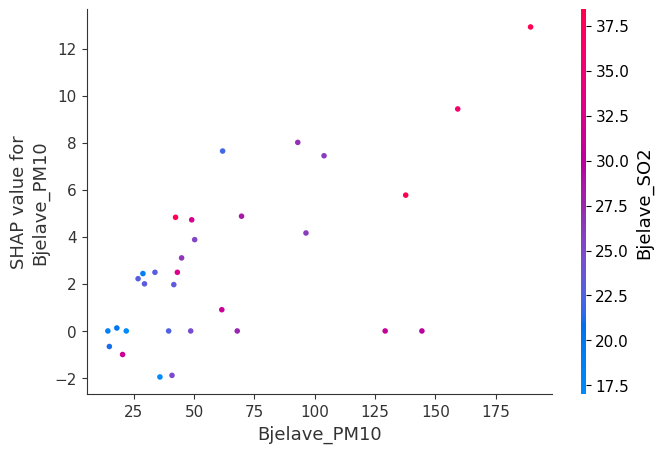

In [627]:
shap.dependence_plot(
    ind=8,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=9
)

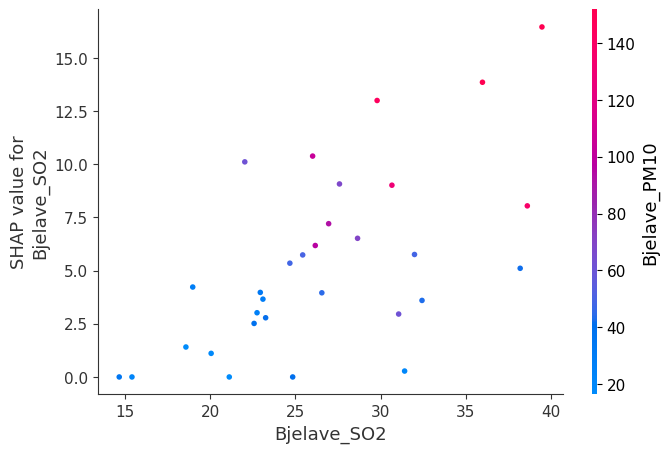

In [628]:
shap.dependence_plot(
    ind=9,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=8
)

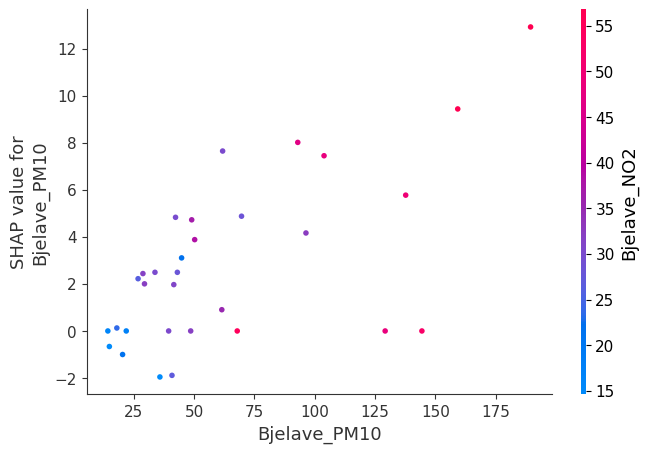

In [629]:
shap.dependence_plot(
    ind=8,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=10
)

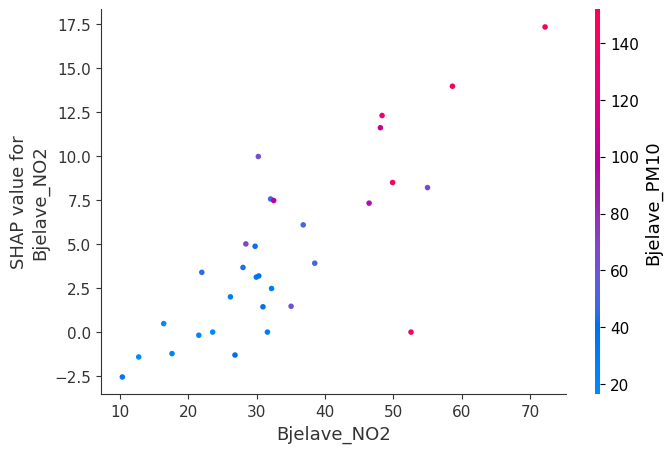

In [630]:
shap.dependence_plot(
    ind=10,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed,
    interaction_index=8
)

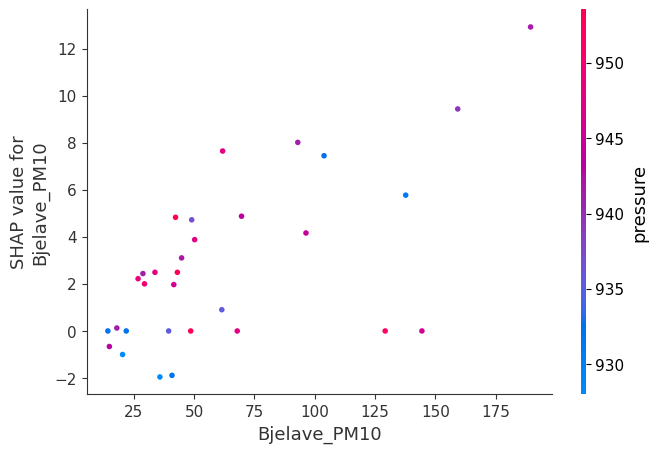

In [631]:
shap.dependence_plot(
    ind=8,
    shap_values=shap_values_data_combined_ws_thirty[:, 1:],
    features=data_combined_to_explain_ws_thirty.iloc[:, 1:],
    feature_names=custom_feature_names_trimmed
    #izostavljen indeks
)

# SHAP Analysis of 60-Days Forecast Horizons in Facebook Prophet Model

In [ ]:
explainer_data_combined_ws_sixty = shap.KernelExplainer(prophet_predict_ws_sixty_for_shap_combined, background_data_combined_ws_sixty)
shap_values_data_combined_ws_sixty = explainer_data_combined_ws_sixty.shap_values(data_combined_to_explain_ws_sixty)

  0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
shap_values_data_combined_ws_sixty

array([[-111.74662818, -118.32029765,  -84.4023362 ,  -87.28493186,
         -74.03460054,  -77.02482374,    0.        ,  -51.74433893,
         -82.1329342 , -101.66626263,  -64.92230263,    0.        ],
       [ -96.22476178,  -60.82763143,  -54.81921581,  -54.28864943,
         -57.99926694,  -63.37843113,    0.        ,  -87.21098426,
         -64.82313342,  -71.41531415,  -34.85808509,    0.        ],
       [-113.44051741,  -90.30699793,  -73.66287486,  -78.38203069,
         -66.62632536,  -78.75888598,    0.        ,  -73.1045927 ,
        -102.229547  ,  -60.72105679,    0.        ,  -46.12506167],
       [ -51.31827616,  -71.65576375,  -33.41444036,  -42.52889594,
         -33.35044211,  -59.11091927,   42.10748501,  -67.13160979,
           0.        ,  -91.45156038,  -26.21101999,    0.        ],
       [ 341.2344645 ,    0.        ,  235.04887975,  332.57017998,
         302.24585449,  234.24352498,  229.49375878,  303.79200232,
         265.46521725,  348.78495314,  332.1

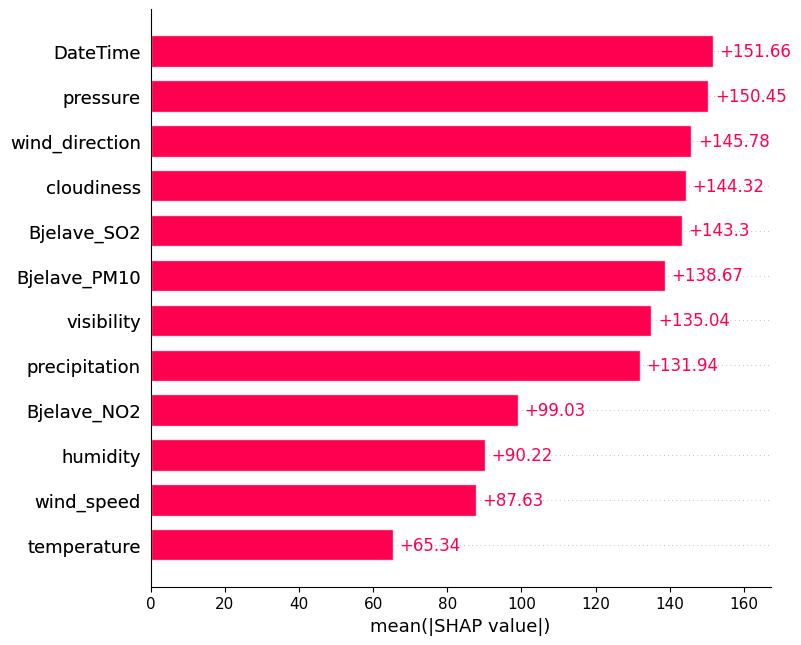

In [ ]:
explainer_data_combined_ws_sixty_mod = shap.Explanation(
    values=shap_values_data_combined_ws_sixty,
    base_values=np.array([explainer_data_combined_ws_sixty.expected_value] * len(shap_values_data_combined_ws_sixty)),
    data=data_combined_to_explain_ws_sixty,
    feature_names=custom_feature_names
)
shap.plots.bar(explainer_data_combined_ws_sixty_mod, max_display=len(custom_feature_names))

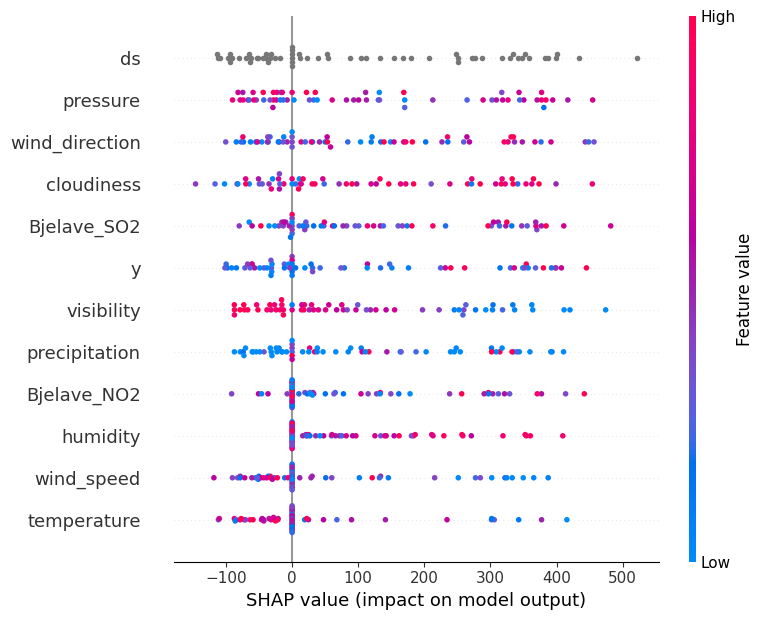

In [ ]:
shap.summary_plot(shap_values_data_combined_ws_sixty, test_data_combined_ws_sixty)

In [ ]:
shap_values_data_combined_ws_sixty_noDT = shap_values_data_combined_ws_sixty[1:]
test_data_combined_ws_sixty_noDT = test_data_combined_ws_sixty[1:]

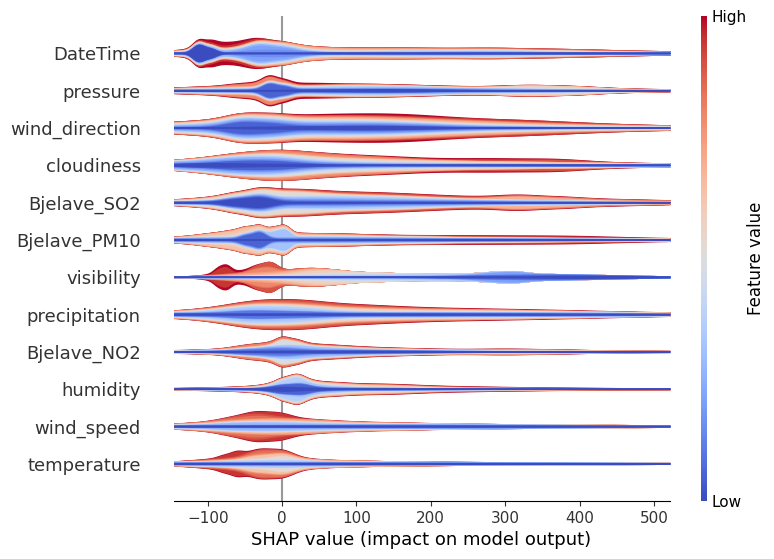

In [ ]:
shap.plots.violin(shap_values_data_combined_ws_sixty, features=test_data_combined_ws_sixty, feature_names=custom_feature_names, plot_type="layered_violin")


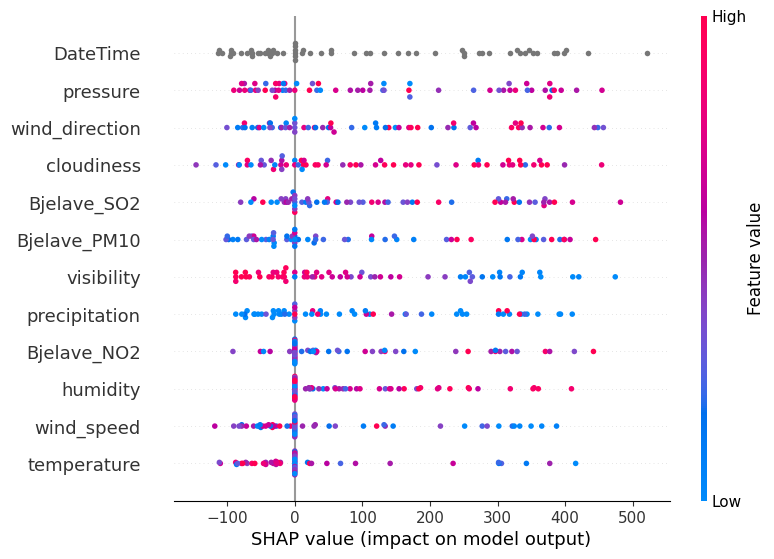

In [ ]:
shap.plots.beeswarm(explainer_data_combined_ws_sixty_mod, max_display=len(custom_feature_names))

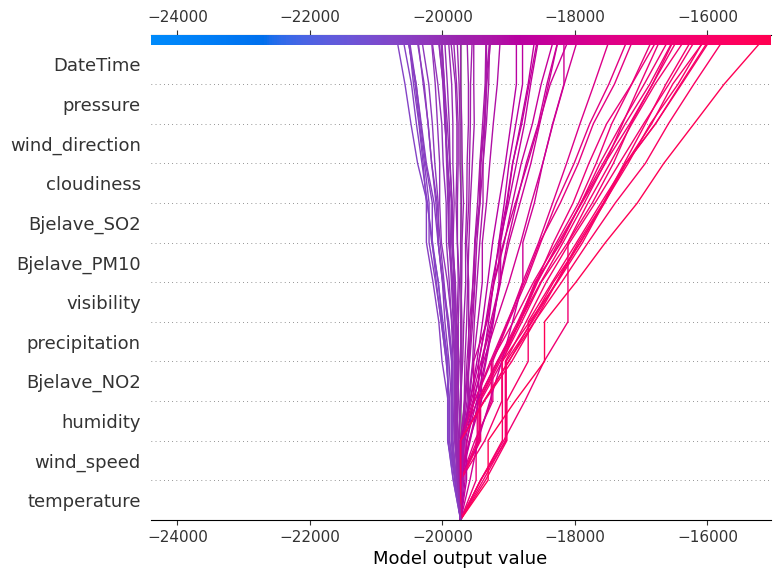

In [ ]:
shap.decision_plot(explainer_data_combined_ws_sixty.expected_value, shap_values_data_combined_ws_sixty, custom_feature_names)


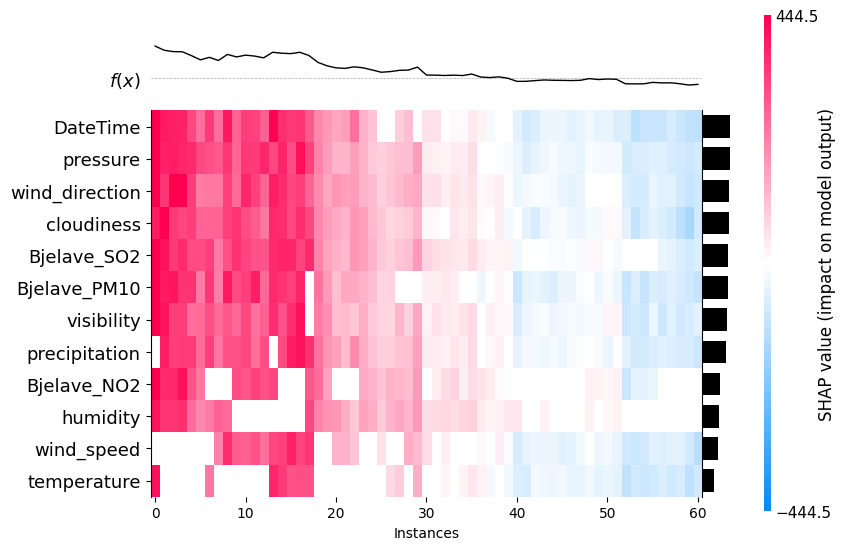

<Axes: xlabel='Instances'>

In [ ]:
shap.plots.heatmap(explainer_data_combined_ws_sixty_mod, max_display=len(custom_feature_names))

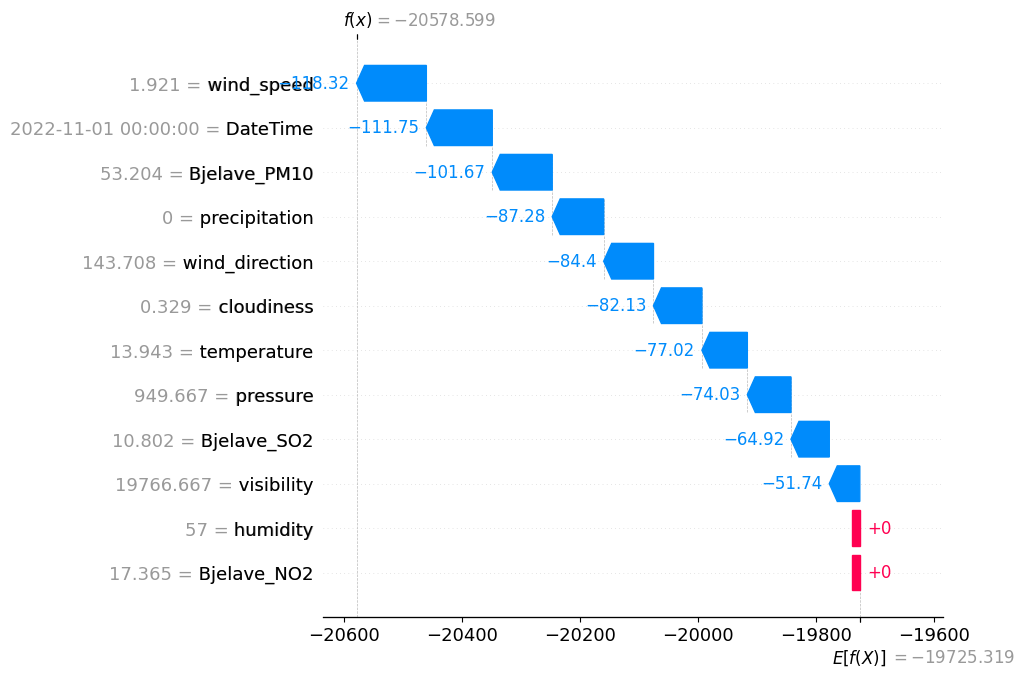

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[0], max_display=len(custom_feature_names))

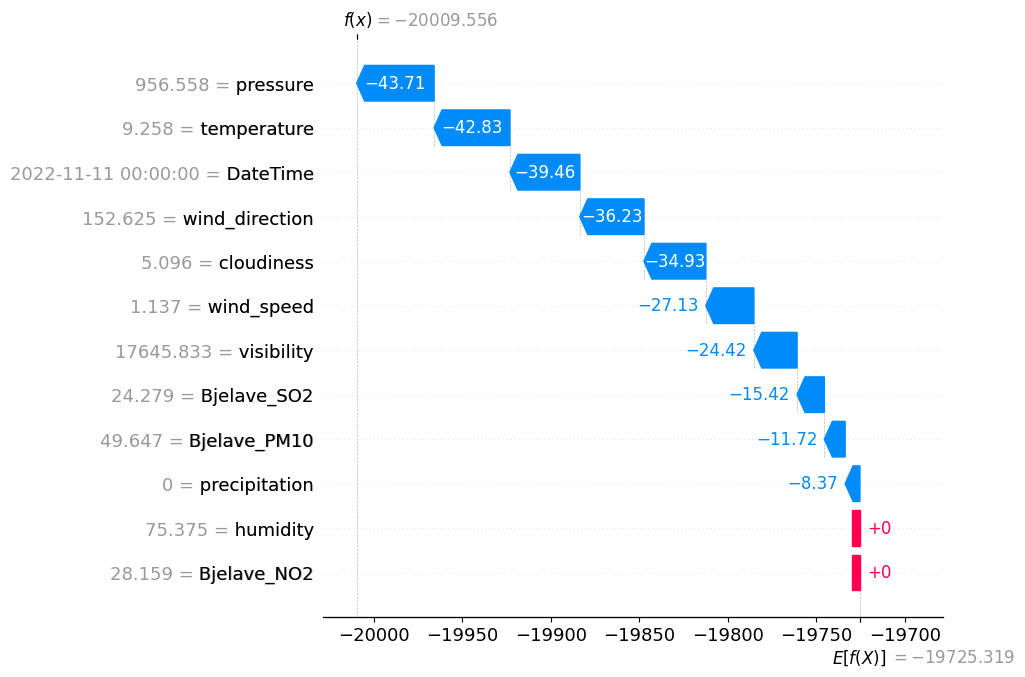

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[10], max_display=len(custom_feature_names))

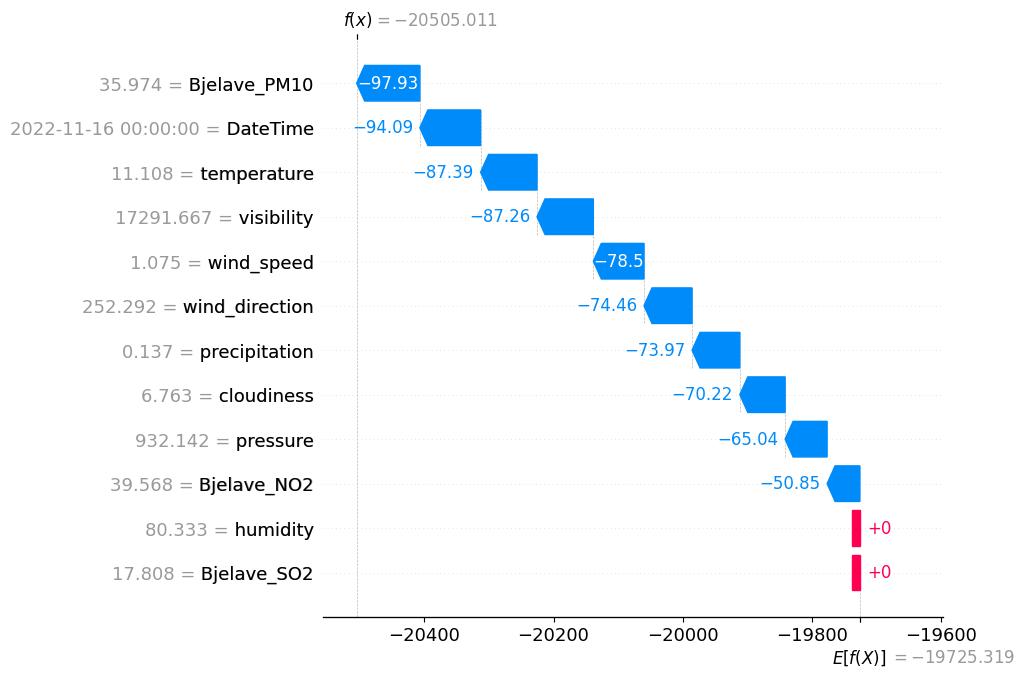

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[15], max_display=len(custom_feature_names))

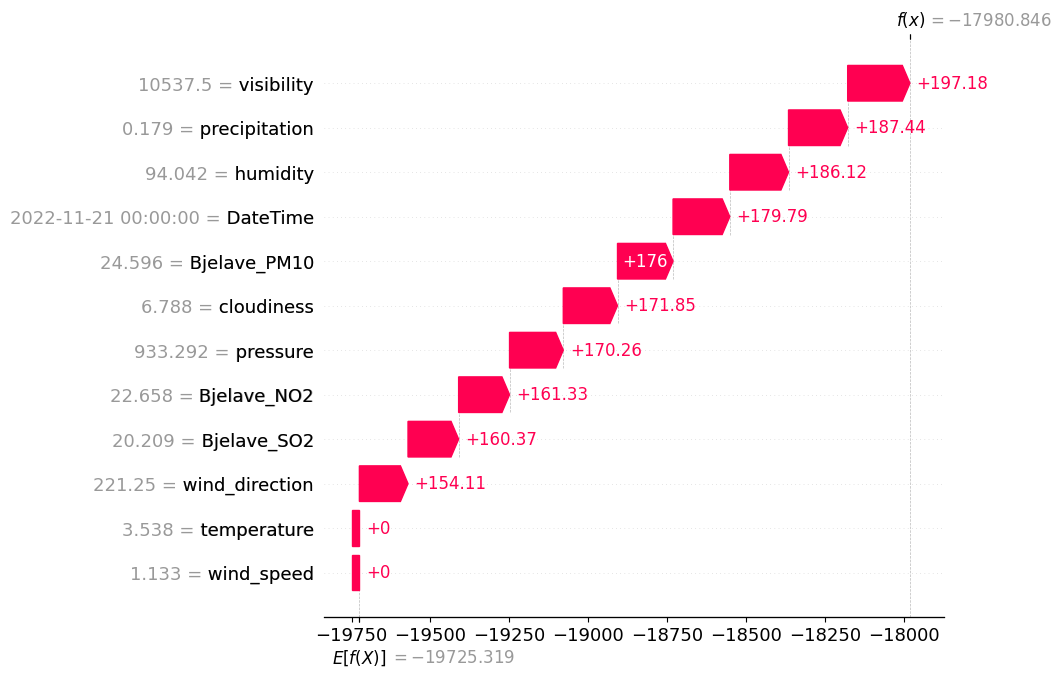

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[20], max_display=len(custom_feature_names))

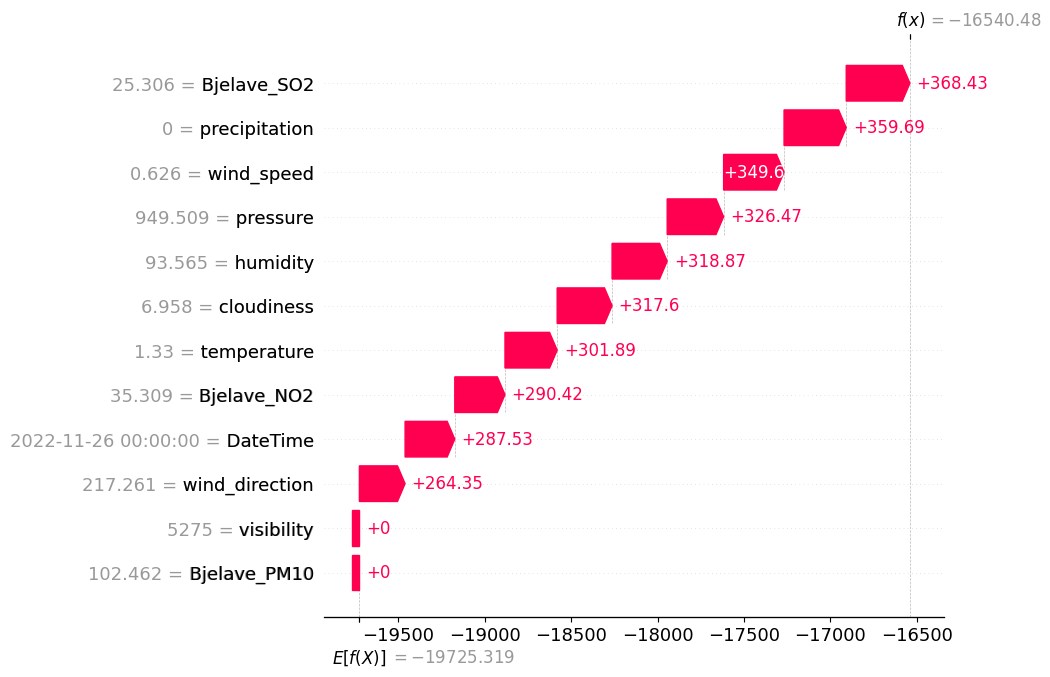

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[25], max_display=len(custom_feature_names))

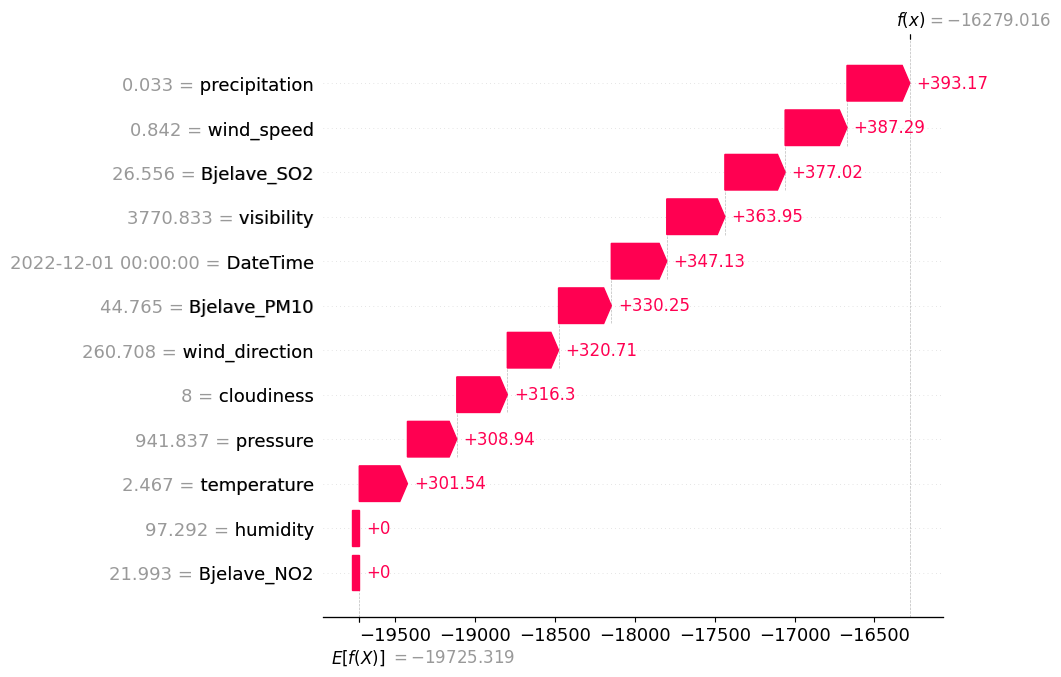

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[30], max_display=len(custom_feature_names))

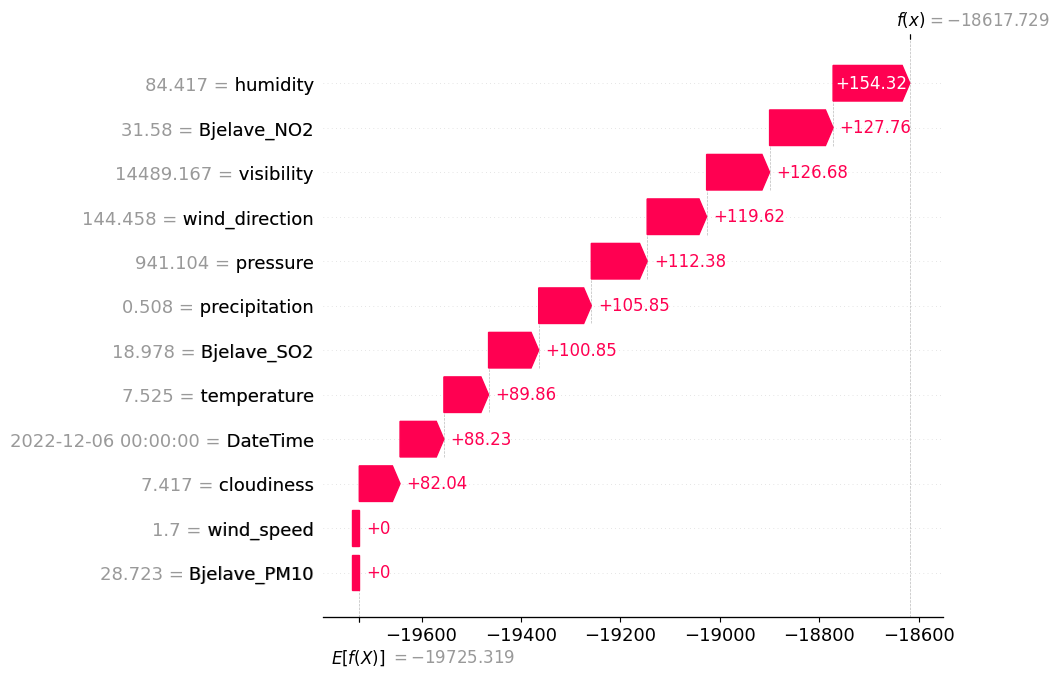

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[35], max_display=len(custom_feature_names))

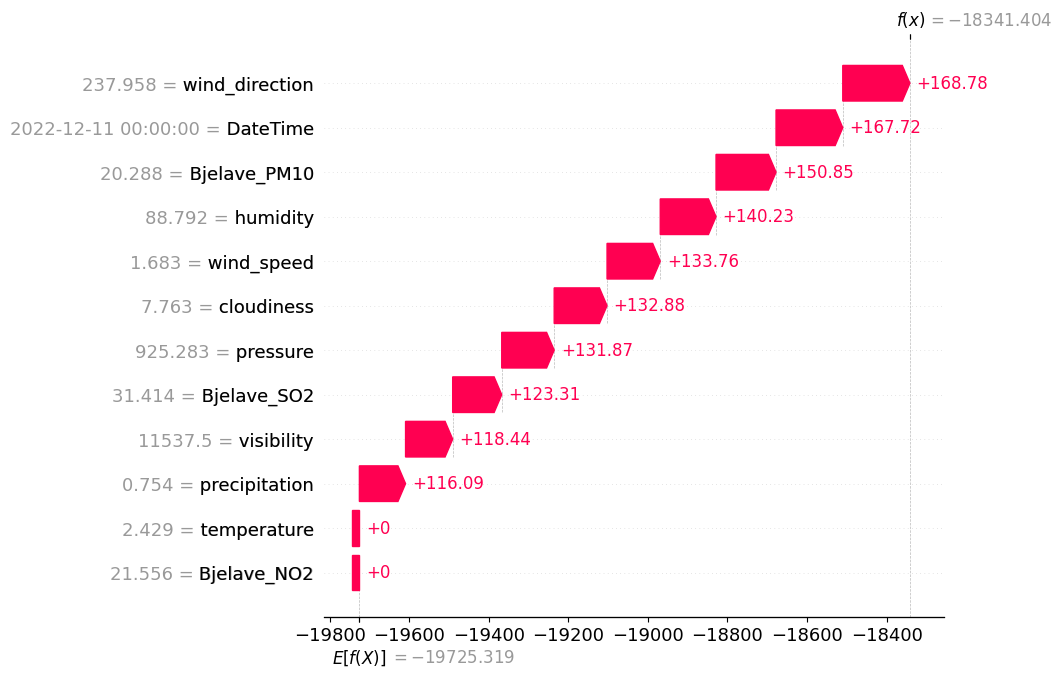

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[40], max_display=len(custom_feature_names))

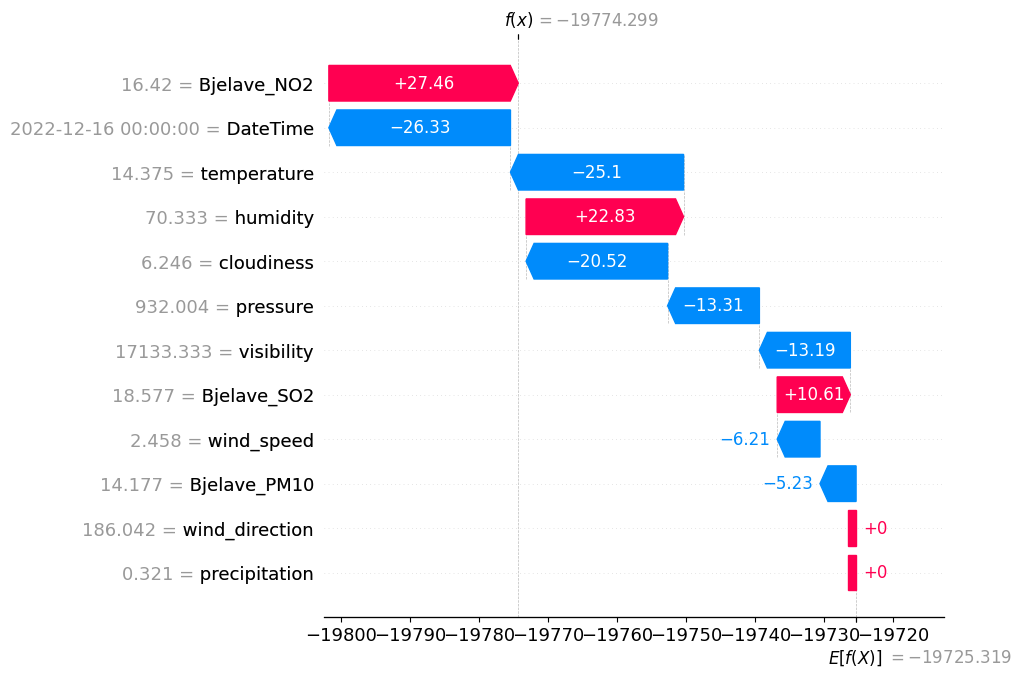

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[45], max_display=len(custom_feature_names))

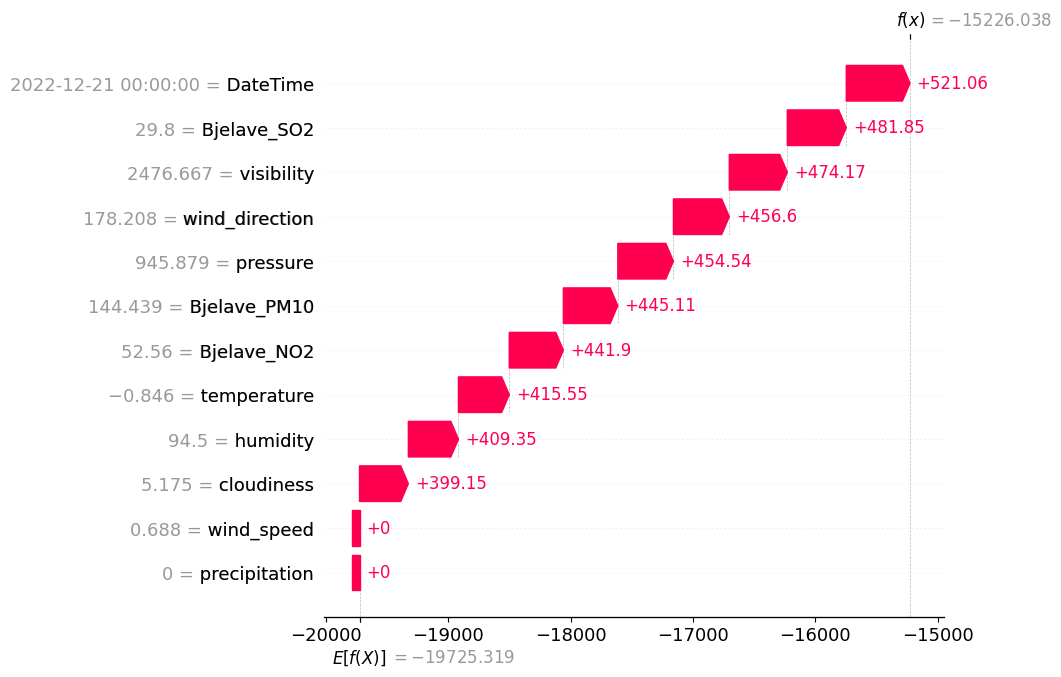

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[50], max_display=len(custom_feature_names))

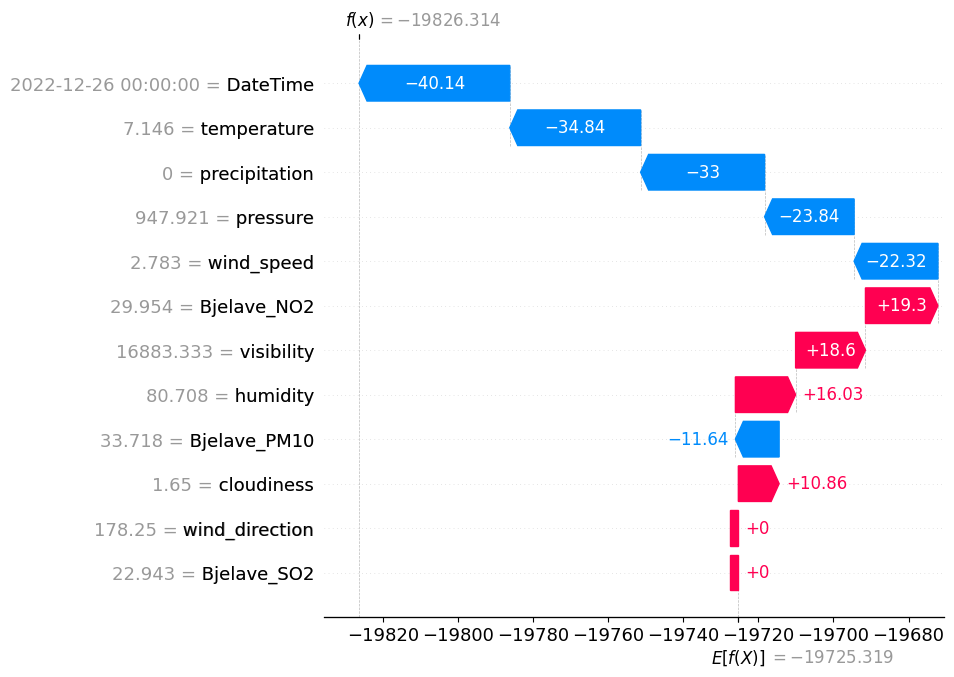

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[55], max_display=len(custom_feature_names))

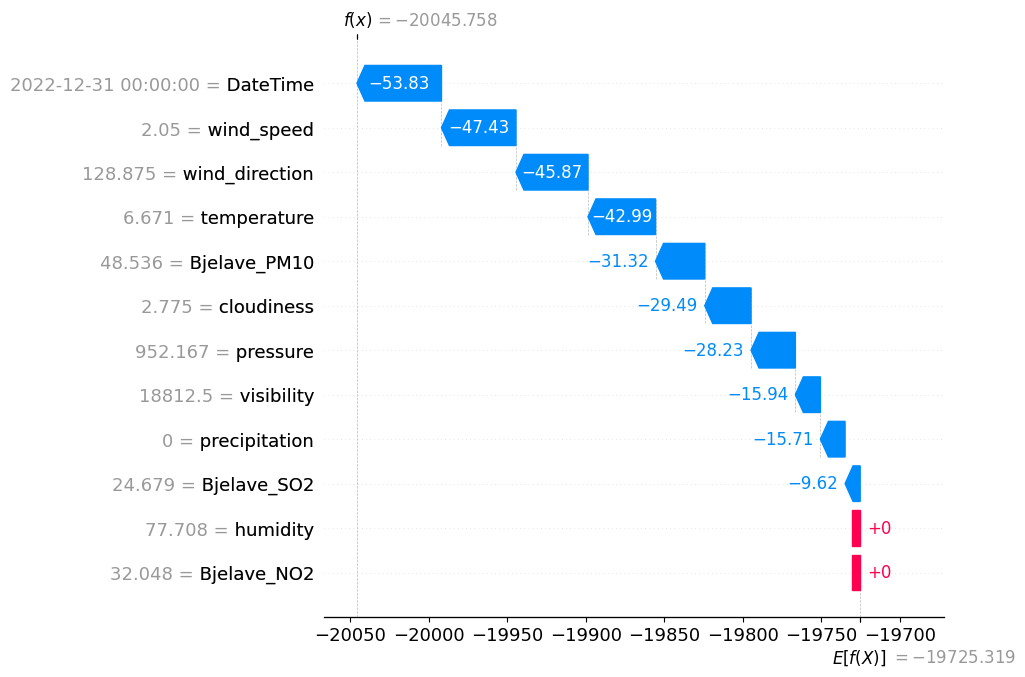

In [ ]:
shap.plots.waterfall(explainer_data_combined_ws_sixty_mod[60], max_display=len(custom_feature_names))

In [ ]:
custom_feature_names_trimmed = custom_feature_names[1:]
custom_feature_names_trimmed[0]

'wind_speed'

In [ ]:
#explainer_data_combined_ws_ninety = shap.KernelExplainer(prophet_predict_ws_ninety_for_shap_combined, background_data_combined_ws_ninety)
#shap_values_data_combined_ws_ninety = explainer_data_combined_ws_ninety.shap_values(data_combined_to_explain_ws_ninety)

In [ ]:
#explainer_data_combined_ws_ninety_mod = shap.Explanation(
#    values=shap_values_data_combined_ws_ninety,
#    base_values=np.array([explainer_data_combined_ws_ninety.expected_value] * len(shap_values_data_combined_ws_ninety)),
#    data=data_combined_to_explain_ws_ninety,
#    feature_names=custom_feature_names
#)
#shap.plots.bar(explainer_data_combined_ws_ninety_mod, max_display=len(custom_feature_names))